# RE-IMAGE GENERATION

In [1]:
# Types of Loss:
# MSE
# BCE
# Perceptual (VGG-based)
# Adversarial Loss
# Hybrid Loss (MSE, Perceptual, Adversarial)

attempt = "baseline"

### EEG Data

In [2]:
import os
import pickle

path = '/kaggle/input/preprocessed-multiband/'
with open(os.path.join(path, "preprocessed_multiband_eeg.pkl"), "rb") as f:
    processed = pickle.load(f)

In [3]:
X_preprocessed = processed['X']
y_preprocessed = processed['y']

print(X_preprocessed['delta'].shape)
print(y_preprocessed.shape)

(34230, 32, 125)
(34230,)


In [4]:
from keras.utils import to_categorical
import numpy as np

X_preprocessed = np.stack([
    X_preprocessed['delta'],
    X_preprocessed['theta'],
    X_preprocessed['alpha'],
    X_preprocessed['beta']
], axis=1)

X_transposed_pre = np.transpose(X_preprocessed, (0, 1, 3, 2))
y_cat_pre = to_categorical(y_preprocessed, num_classes=10)

print(X_transposed_pre.shape)
print(y_cat_pre.shape)

2025-08-01 06:02:25.560950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754028145.938945      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754028146.047723      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(34230, 4, 125, 32)
(34230, 10)


### Image Data

In [5]:
import os
import numpy as np

path = "/kaggle/input/mnist-images/"
images = np.load(os.path.join(path, "MNIST_images.npy"))

#### Data Pairing (MNIST with Combined Signals)

In [6]:
import os
import numpy as np

path = '/kaggle/input/preprocessed-multiband/'
used_indices = np.load(os.path.join(path, 'used_indices.npy'))

In [7]:
global_images = []

for i in range(len(used_indices)):
    group_image = images[used_indices[i]]
    
    # Calculate mean of images from the group
    mean_img = np.mean(group_image, axis=0)

    # Take the most representative one (according to MSE)
    MSE_list = [np.mean((img - mean_img)**2) for img in group_image]
    representative_image = images[used_indices[i][np.argmin(MSE_list)]]
    global_images.append(representative_image)

global_images = np.array(global_images)
print(global_images.shape)

(30000, 28, 28)


#### Add Padding
##### (28x28) => (32x32)

In [8]:
padded = np.pad(np.array(global_images), ((0, 0), (2, 2), (2, 2)), mode='constant', constant_values=0)
print(padded.shape)

(30000, 32, 32)


#### Duplicate Data for Augmented

In [9]:
duplicated = []
for src in processed['duplication_sources']:
    if (isinstance(src, tuple)):
        (src1, src2), lam = src
        if (lam < 0.5):
            duplicated.append(padded[src2])
        else:
            duplicated.append(padded[src1])
    else:
        duplicated.append(padded[src])

print(len(duplicated))

4230


In [10]:
combined = np.concatenate([padded, duplicated], axis=0)
print(combined.shape)

(34230, 32, 32)


### Feature Extraction and Classification Model

In [11]:
from tensorflow.keras.models import Model

def make_pairs(model, X, y, imgs):
    encoder_model = Model(inputs=model.input, outputs=model.get_layer('latent_vector').output)
    encoder_model.compile()
    latent_vectors = encoder_model.predict(X)
    
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y, axis=1)
    true_indices = [i for i in range(len(y_pred)) if y_pred[i] == y_true[i]]

    final_true_pairs = [(latent_vectors[i],
                         y[i],        
                         imgs[i])
                         for i in true_indices]
    
    final_false_pairs = [(latent_vectors[i],
                         y[i],        
                         imgs[i])
                         for i in range(len(y_pred)) 
                         if i not in true_indices]

    return final_true_pairs, final_false_pairs

In [12]:
from sklearn.model_selection import train_test_split

X_train_pre, X_val_pre,    \
y_train_pre, y_val_pre,    \
img_train_pre, img_val_pre \
    = train_test_split (
        X_transposed_pre, 
        y_cat_pre,
        combined,
    
        test_size    = 0.2,
        random_state = 42, 
        shuffle      = True, 
        stratify     = y_cat_pre
    )

In [13]:
# BEST CLASSIFICATION FOR PREPROCESSED DATA
import tensorflow as tf
import os

save_dir = f"/kaggle/input/best-lstm-final-multiband/keras/default/1"
best_model = tf.keras.models.load_model(os.path.join(save_dir, f'best_LSTM_final_multiband.keras'))

I0000 00:00:1754029641.053845      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754029641.054570      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
final_true_pairs, final_false_pairs = make_pairs(best_model, X_train_pre, y_train_pre, img_train_pre)

In [25]:
final_pre_pairs = np.array(final_true_pairs + final_false_pairs, dtype=object)
np.random.shuffle(final_pre_pairs)

## cDCGAN

In [26]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

### Supportive Functions

In [27]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [28]:
import torch

all_z = torch.cat([torch.tensor(z) for z, _, _ in final_pre_pairs], dim=0)
all_y = torch.cat([torch.tensor(y) for _, y, _ in final_pre_pairs], dim=0)

real_imgs = torch.cat([torch.tensor(img).unsqueeze(0) for _, _, img in final_pre_pairs])

# !!!!!!!!!!!!!! NORMALIZATION !!!!!!!!!!!!!!
real_imgs = (real_imgs.float() / 255.0 - 0.5) / 0.5

fixed_z_ = all_z.view(-1, 100, 1, 1).float().cuda()
fixed_y_label_ = all_y.view(-1, 10, 1, 1).float().cuda()
real_imgs = real_imgs.unsqueeze(1).cuda()

In [29]:
print(fixed_z_.shape)
print(fixed_y_label_.shape)
print(real_imgs.shape)

torch.Size([27384, 100, 1, 1])
torch.Size([27384, 10, 1, 1])
torch.Size([27384, 1, 32, 32])


In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def show_result(num_epoch, show=False, save=False, path='result.png'):
    G.eval()
    with torch.no_grad():
        batch_size = 100
        z = fixed_z_.to(device)[:batch_size]
        y = fixed_y_label_.to(device)[:batch_size]
        test_images = G(z, y).cpu()

    # Plotting
    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for idx in range(100):
        i, j = divmod(idx, 10)
        ax[i, j].cla()
        ax[i, j].imshow(test_images[idx, 0].numpy(), cmap='gray')

    label = f'Epoch {num_epoch}'
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path, dpi=150, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()
    G.train()

In [50]:
def show_train_hist(hist, loss_type, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist[loss_type]['D_losses']))

    y1 = hist[loss_type]['D_losses']
    y2 = hist[loss_type]['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

### Generator and Discriminator

#### Generator

In [32]:
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1_1 = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*2)
        self.deconv1_2 = nn.ConvTranspose2d(10, d*2, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.relu(self.deconv1_1_bn(self.deconv1_1(input)))
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x

#### Discriminator

In [33]:
class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1_1 = nn.Conv2d(1, d//2, 4, 2, 1)
        self.conv1_2 = nn.Conv2d(10, d//2, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d * 4, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.leaky_relu(self.conv1_1(input), 0.2)
        y = F.leaky_relu(self.conv1_2(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv4(x))

        return x

### TRAINING

In [35]:
# training parameters
batch_size = 128
lr = 0.0002
train_epoch = 20

# data_loader
img_size = 32
padding_size = (2, 2, 2, 2)

In [41]:
import torch
import torch.nn as nn
import torchvision.models as models
        
def get_loss_functions(loss_type):
    mse_loss = nn.MSELoss()
    bce_loss = nn.BCELoss()

    # VGG for Perceptual Loss
    vgg = models.vgg16(pretrained=True).features[:16].eval().cuda()
    for param in vgg.parameters():
        param.requires_grad = False

    imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).cuda()
    imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).cuda()

    def perceptual_loss(fake, real):
        fake_rgb = (fake.expand(-1, 3, 32, 32) - imagenet_mean) / imagenet_std
        real_rgb = (real.expand(-1, 3, 32, 32) - imagenet_mean) / imagenet_std
        fake_features = vgg(fake_rgb)
        real_features = vgg(real_rgb)
        return mse_loss(fake_features, real_features)

    def lsgan_g_loss(D_fake):
        return 0.5 * ((D_fake - 1)**2).mean()
    def lsgan_d_loss(D_real, D_fake):
        return 0.5 * ((D_real - 1)**2 + D_fake**2).mean()

    def hybrid_loss(fake, real, D_fake_out):
        adv = lsgan_g_loss(D_fake_out)
        per = perceptual_loss(fake, real)
        mse = mse_loss(fake, real)
        return mse + 0.1 * per + 0.1 * adv

    if loss_type == 'mse':
        return mse_loss, None
    elif loss_type == 'bce': 
        return bce_loss, None
    elif loss_type == 'perceptual':
        return perceptual_loss, bce_loss
    elif loss_type == 'adversarial':
        return lsgan_g_loss, lsgan_d_loss
    elif loss_type == 'hybrid':
        return hybrid_loss, lsgan_d_loss
    else:
        raise ValueError("Unsupported loss type")

#### Network Initialization

In [48]:
# Loss Types
loss_types = ['mse', 'bce', 'perceptual', 'adversarial', 'hybrid']

# results save folder
root = 'MNIST_cDCGAN_results/'

train_hist = {}
for loss_type in loss_types:
    train_hist[loss_type] = {
        'D_losses': [],
        'G_losses': [],
        'per_epoch_ptimes': [],
        'total_ptime': []
    }

# label preprocess
fill = torch.zeros([10, 10, img_size, img_size])
for i in range(10):
    fill[i, i, :, :] = 1
fill = fill.float().cuda()

#### Training Start

In [39]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(fixed_z_, fixed_y_label_, real_imgs)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [53]:
for loss_type in loss_types:
    # network
    G = generator(128)
    D = discriminator(128)
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    G.cuda()
    D.cuda()

    # Adam optimizer
    G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

    loss, d_loss = get_loss_functions(loss_type)
    
    print(f'training start! Loss type: {loss_type}')
    start_time = time.time()
    for epoch in range(train_epoch):
        D_losses = []
        G_losses = []
    
        # learning rate decay
        if (epoch+1) == 11:
            G_optimizer.param_groups[0]['lr'] /= 10
            D_optimizer.param_groups[0]['lr'] /= 10
            print("learning rate change!")
    
        if (epoch+1) == 16:
            G_optimizer.param_groups[0]['lr'] /= 10
            D_optimizer.param_groups[0]['lr'] /= 10
            print("learning rate change!")
    
        epoch_start_time = time.time()
        
        y_real_ = torch.ones(batch_size)
        y_fake_ = torch.zeros(batch_size)
        y_real_, y_fake_ = Variable(y_real_.cuda()), Variable(y_fake_.cuda())
        
        for z_, y_label_, x_ in dataloader:
            # train discriminator D
            D.zero_grad()
    
            mini_batch = x_.size()[0]
    
            if mini_batch != batch_size:
                y_real_ = torch.ones(mini_batch)
                y_fake_ = torch.zeros(mini_batch)
                y_real_, y_fake_ = Variable(y_real_.cuda()), Variable(y_fake_.cuda())
    
            label_indices = y_label_.squeeze(-1).squeeze(-1).argmax(dim=1)
            y_fill_ = fill[label_indices]
    
            D_result_real = D(x_, y_fill_).squeeze()
            
            G_result = G(z_, y_label_)
            D_result_fake = D(G_result, y_fill_).squeeze()
    
            if loss_type == 'adversarial':
                D_train_loss = d_loss(D_result_real, D_result_fake)
            elif loss_type == 'hybrid':
                D_train_loss = d_loss(D_result_real, D_result_fake)
            elif loss_type == 'perceptual':
                D_train_loss = d_loss(D_result_real, y_real_) + d_loss(D_result_fake, y_fake_)
            else:
                D_train_loss = loss(D_result_real, y_real_) + loss(D_result_fake, y_fake_)
    
            D_train_loss.backward()
            D_optimizer.step()
    
            D_losses.append(D_train_loss.item())

            # --------------------------------------------------------------------------------
            # train generator G
            G.zero_grad()
    
            G_result = G(z_, y_label_)
            D_result = D(G_result, y_fill_).squeeze()
    
            if loss_type == 'adversarial':
                G_train_loss = loss(D_result)
            elif loss_type == 'hybrid':
                G_train_loss = loss(G_result, x_, D_result)    
            elif loss_type == 'perceptual':
                G_train_loss = loss(G_result, x_)
            else:
                G_train_loss = loss(D_result, y_real_)
    
            G_train_loss.backward()
            G_optimizer.step()
    
            G_losses.append(G_train_loss.item())
    
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time
    
        print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                                  torch.mean(torch.FloatTensor(G_losses))))

        fixed_result_dir = os.path.join(root, f'{loss_type}', 'Fixed_results')
        os.makedirs(fixed_result_dir, exist_ok=True)
        fixed_p = os.path.join(fixed_result_dir, f'{epoch + 1}.png')
        show_result((epoch+1), save=True, path=fixed_p)
        train_hist[loss_type]['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
        train_hist[loss_type]['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
        train_hist[loss_type]['per_epoch_ptimes'].append(per_epoch_ptime)
    
    end_time = time.time()
    total_ptime = end_time - start_time
    train_hist[loss_type]['total_ptime'].append(total_ptime)

    # -----------------------------------------------------------------------------------
    # SAVE RESULTS
    import os

    drive_root = f'/kaggle/working/MNIST_cDCGAN_results/'
    os.makedirs(drive_root, exist_ok=True)

    torch.save(G.state_dict(), drive_root + f'{loss_type}/' + 'generator_param.pkl')
    torch.save(D.state_dict(), drive_root + f'{loss_type}/' + 'discriminator_param.pkl')
    with open(drive_root + f'{loss_type}/' + 'train_hist.pkl', 'wb') as f:
        pickle.dump(train_hist, f)
    
    show_train_hist(train_hist, loss_type, save=True, path=root + loss_type + 'train_hist.png')
    
    images = []
    for e in range(train_epoch):
        img_name = root + f'{loss_type}/Fixed_results/' + str(e + 1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(root + f'{loss_type}/' + 'generation_animation.gif', images, fps=5)
    # -----------------------------------------------------------------------------------
    
    print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist[loss_type]['per_epoch_ptimes'])), train_epoch, total_ptime))
    print(f'training finish for loss type: {loss_type}')
    print("----------------------------------------------------------------------------")

training start! Loss type: mse
[1/20] - ptime: 31.14, loss_d: 0.492, loss_g: 0.710
[2/20] - ptime: 29.24, loss_d: 0.408, loss_g: 0.629
[3/20] - ptime: 29.94, loss_d: 0.345, loss_g: 0.679
[4/20] - ptime: 29.82, loss_d: 0.373, loss_g: 0.596
[5/20] - ptime: 29.65, loss_d: 0.445, loss_g: 0.473
[6/20] - ptime: 29.78, loss_d: 0.457, loss_g: 0.422
[7/20] - ptime: 29.76, loss_d: 0.468, loss_g: 0.403
[8/20] - ptime: 29.79, loss_d: 0.474, loss_g: 0.375
[9/20] - ptime: 29.68, loss_d: 0.483, loss_g: 0.353
[10/20] - ptime: 29.86, loss_d: 0.483, loss_g: 0.338
learning rate change!
[11/20] - ptime: 29.82, loss_d: 0.446, loss_g: 0.297
[12/20] - ptime: 29.65, loss_d: 0.442, loss_g: 0.298
[13/20] - ptime: 29.89, loss_d: 0.431, loss_g: 0.307
[14/20] - ptime: 29.77, loss_d: 0.420, loss_g: 0.321
[15/20] - ptime: 29.69, loss_d: 0.407, loss_g: 0.337
learning rate change!
[16/20] - ptime: 29.79, loss_d: 0.396, loss_g: 0.334
[17/20] - ptime: 29.75, loss_d: 0.391, loss_g: 0.337
[18/20] - ptime: 29.65, loss_d: 0

/tmp/ipykernel_36/273469546.py:124: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_name))


Avg one epoch ptime: 29.83, total 20 epochs ptime: 690.47
training finish for loss type: mse
----------------------------------------------------------------------------
training start! Loss type: bce
[1/20] - ptime: 29.92, loss_d: 1.011, loss_g: 2.888
[2/20] - ptime: 29.78, loss_d: 1.010, loss_g: 2.236
[3/20] - ptime: 29.75, loss_d: 0.967, loss_g: 2.065
[4/20] - ptime: 29.70, loss_d: 1.055, loss_g: 1.753
[5/20] - ptime: 29.90, loss_d: 1.187, loss_g: 1.400
[6/20] - ptime: 29.77, loss_d: 1.240, loss_g: 1.255
[7/20] - ptime: 29.71, loss_d: 1.272, loss_g: 1.172
[8/20] - ptime: 29.77, loss_d: 1.286, loss_g: 1.113
[9/20] - ptime: 29.82, loss_d: 1.296, loss_g: 1.065
[10/20] - ptime: 29.76, loss_d: 1.310, loss_g: 1.053
learning rate change!
[11/20] - ptime: 29.80, loss_d: 1.194, loss_g: 0.879
[12/20] - ptime: 29.74, loss_d: 1.177, loss_g: 0.866
[13/20] - ptime: 29.70, loss_d: 1.175, loss_g: 0.869
[14/20] - ptime: 29.89, loss_d: 1.158, loss_g: 0.885
[15/20] - ptime: 29.75, loss_d: 1.145, loss_

RuntimeError: The expanded size of the tensor (32) must match the existing size (128) at non-singleton dimension 3.  Target sizes: [-1, 3, 32, 32].  Tensor sizes: [128]

training start! Loss type: perceptual
[1/20] - ptime: 33.52, loss_d: 0.016, loss_g: 71.001
[2/20] - ptime: 31.31, loss_d: 0.000, loss_g: 51.421
[3/20] - ptime: 32.08, loss_d: 0.000, loss_g: 48.933
[4/20] - ptime: 32.17, loss_d: 0.000, loss_g: 47.946
[5/20] - ptime: 31.78, loss_d: 0.000, loss_g: 47.395
[6/20] - ptime: 31.68, loss_d: 0.000, loss_g: 47.078
[7/20] - ptime: 31.82, loss_d: 0.000, loss_g: 46.812
[8/20] - ptime: 31.67, loss_d: 0.000, loss_g: 46.538
[9/20] - ptime: 31.76, loss_d: 0.000, loss_g: 46.309
[10/20] - ptime: 31.78, loss_d: 0.000, loss_g: 46.093
learning rate change!
[11/20] - ptime: 31.79, loss_d: 0.000, loss_g: 45.198
[12/20] - ptime: 31.78, loss_d: 0.000, loss_g: 45.027
[13/20] - ptime: 31.79, loss_d: 0.000, loss_g: 44.929
[14/20] - ptime: 31.79, loss_d: 0.000, loss_g: 44.841
[15/20] - ptime: 31.72, loss_d: 0.000, loss_g: 44.754
learning rate change!
[16/20] - ptime: 31.82, loss_d: 0.000, loss_g: 44.578
[17/20] - ptime: 31.75, loss_d: 0.000, loss_g: 44.550
[18/20] -

/tmp/ipykernel_36/3275869113.py:131: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_name))


Avg one epoch ptime: 31.87, total 20 epochs ptime: 736.25
training finish for loss type: perceptual
----------------------------------------------------------------------------
training start! Loss type: adversarial
[1/20] - ptime: 30.08, loss_d: 0.286, loss_g: 0.343
[2/20] - ptime: 29.72, loss_d: 0.222, loss_g: 0.336
[3/20] - ptime: 29.74, loss_d: 0.192, loss_g: 0.330
[4/20] - ptime: 29.74, loss_d: 0.201, loss_g: 0.289
[5/20] - ptime: 29.73, loss_d: 0.218, loss_g: 0.242
[6/20] - ptime: 29.91, loss_d: 0.230, loss_g: 0.210
[7/20] - ptime: 29.61, loss_d: 0.235, loss_g: 0.198
[8/20] - ptime: 29.72, loss_d: 0.237, loss_g: 0.191
[9/20] - ptime: 29.81, loss_d: 0.238, loss_g: 0.183
[10/20] - ptime: 29.77, loss_d: 0.239, loss_g: 0.184
learning rate change!
[11/20] - ptime: 29.62, loss_d: 0.217, loss_g: 0.155
[12/20] - ptime: 29.82, loss_d: 0.213, loss_g: 0.156
[13/20] - ptime: 29.84, loss_d: 0.205, loss_g: 0.163
[14/20] - ptime: 29.74, loss_d: 0.196, loss_g: 0.176
[15/20] - ptime: 29.64, loss_

In [58]:
import shutil
shutil.make_archive('/kaggle/working/MNIST_cDCGAN_results.zip', 'zip', '/kaggle/working/MNIST_cDCGAN_results')

'/kaggle/working/MNIST_cDCGAN_results.zip.zip'

### Testing and Evaluation

#### Prepare Validation Data

In [86]:
def make_val_pairs(model, X, y, imgs):
    encoder_model = Model(inputs=model.input, outputs=model.get_layer('latent_vector').output)
    encoder_model.compile()
    latent_vectors = encoder_model.predict(X)
    
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y, axis=1)
    true_indices = [i for i in range(len(y_pred)) if y_pred[i] == y_true[i]]

    final_true_pairs = [(latent_vectors[i],
                         y[i],        
                         imgs[i])
                         for i in true_indices]
    
    final_false_pairs = [(latent_vectors[i],
                         to_categorical(y_pred[i], num_classes=10),        
                         imgs[i])
                         for i in range(len(y_pred)) 
                         if i not in true_indices]

    return final_true_pairs, final_false_pairs

In [87]:
final_true_val_pairs, final_false_val_pairs = make_val_pairs(best_model, X_val_pre, y_val_pre, img_val_pre)
final_pre_val_pairs = final_true_val_pairs + final_false_val_pairs
np.random.shuffle(final_pre_val_pairs)

214/214 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


In [88]:
all_z_val = torch.cat([torch.tensor(z) for z, _, _ in final_pre_val_pairs], dim=0)
all_y_val = torch.cat([torch.tensor(y) for _, y, _ in final_pre_val_pairs], dim=0)

real_imgs_val = torch.cat([torch.tensor(img).unsqueeze(0) for _, _, img in final_pre_val_pairs])
real_imgs_val = (real_imgs_val.float() / 255.0 - 0.5) / 0.5

fixed_z_val = all_z_val.view(-1, 100, 1, 1).float().cuda()
fixed_y_label_val = all_y_val.view(-1, 10, 1, 1).float().cuda()
real_imgs_val = real_imgs_val.unsqueeze(1).cuda()

#### METRICS

In [62]:
# SSIM
from skimage.metrics import structural_similarity as ssim

def SSIM(generated, original):
    score = ssim(generated, original, data_range=original.max() - original.min())
    return score

In [63]:
# PSNR
# Source: https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [64]:
from torchmetrics.multimodal.clip_score import CLIPScore
import torch
import numpy as np
from PIL import Image

metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")
number_text = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

def CLIP_score(image, label_onehot):
    try:
        if isinstance(label_onehot, np.ndarray) and len(label_onehot.shape) == 2:
            label = int(np.argmax(label_onehot, axis=1).squeeze().item())
        else:
            label = int(np.argmax(label_onehot))

        if isinstance(image, np.ndarray):
            image_tensor = torch.tensor(image).float()
        else:
            image_tensor = image.float()

        image_tensor = torch.clamp(image_tensor, 0.0, 1.0)

        if image_tensor.ndim == 2:
            image_tensor = image_tensor.unsqueeze(0)
        if image_tensor.shape[0] != 3:
            image_tensor = image_tensor.repeat(3, 1, 1)

        image_tensor = image_tensor.unsqueeze(0).to(metric.device)
        prompt = f"white handwritten digit {number_text[label]} with black background"
        return metric(image_tensor, [prompt]).item()

    except Exception as e:
        print("CLIP_score error:", e)
        return None

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [67]:
!pip install -q torchmetrics
!pip install -q torch-fidelity

# IS & FID
import torch_fidelity
from torchvision.utils import save_image
import os
import tempfile

os.environ["TOKENIZERS_PARALLELISM"] = "false"


def compute_fidelity_metrics(fake_images, real_images, device='cuda'):
    import torchvision.transforms.functional as TF

    with tempfile.TemporaryDirectory() as tmpdir:
        fake_dir = os.path.join(tmpdir, 'fake')
        real_dir = os.path.join(tmpdir, 'real')
        os.makedirs(fake_dir, exist_ok=True)
        os.makedirs(real_dir, exist_ok=True)

        for i, img in enumerate(fake_images):
            img = img.detach().cpu().float()
            if img.min() < 0:
                img = (img + 1) / 2
            img = torch.clamp(img, 0, 1)
            if img.shape[0] == 1:
                img = img.repeat(3, 1, 1)
            save_image(img.squeeze(0), os.path.join(fake_dir, f"{i}.png"))

        for i, img in enumerate(real_images):
            img = img.detach().cpu().float()
            if img.min() < 0:
                img = (img + 1) / 2
            img = torch.clamp(img, 0, 1)
            if img.shape[0] == 1:
                img = img.repeat(3, 1, 1)
            save_image(img.squeeze(0), os.path.join(real_dir, f"{i}.png"))

        metrics = torch_fidelity.calculate_metrics (
            input1=fake_dir,
            input2=real_dir,
            cuda=torch.cuda.is_available(),
            isc=True,
            fid=True,
            verbose=False
        )
    return metrics['inception_score_mean'], metrics['inception_score_std'], metrics['frechet_inception_distance']

In [66]:
def RMSE(fake_image, target_image):
    rmse_score = np.sqrt(np.mean((fake_image - target_image) ** 2)) 
    return rmse_score

#### SUPPORTING FUNCTIONS

In [97]:
def compute_metrics(G, D, pairs, device, n_per_class=5, n=300):
    G.eval()
    D.eval()

    results = {}
    all_generated = []
    all_real = []

    for label in range(10):
        class_pairs = [p for p in pairs if np.argmax(p[1]) == label][:n]
        ssim_scores, psnr_scores, clip_scores, rmse_scores = [], [], [], []

        fig, axes = plt.subplots(2, n_per_class, figsize=(n_per_class * 2.2, 4))
        fig.suptitle(f"Class {label}", fontsize=12)

        for i, (latent_input, label_onehot, target_image) in enumerate(class_pairs):
            latent_input = torch.tensor(latent_input, dtype=torch.float32).to(device)
            latent_input = latent_input.unsqueeze(0).unsqueeze(2).unsqueeze(3)
            
            label_tensor = torch.tensor(label_onehot, dtype=torch.float32).to(device).view(1, 10, 1, 1)
            label_img = label_tensor.repeat(1, 1, 32, 32)

            with torch.no_grad():
                # --- Fine-tuned model ---
                fake_image = G(latent_input, label_tensor)
                d_score = D(fake_image, label_img).squeeze().item()

                fake_image = torch.clamp((fake_image + 1) / 2, 0, 1)
                fake_np = fake_image.squeeze().cpu().numpy()

            target_image_np = np.array(target_image.astype(np.float32) / 255.0)

            # Metrics for fine-tuned model
            rmse = RMSE(fake_np, target_image_np)
            ssim = SSIM(fake_np, target_image_np)
            psnr = PSNR(target_image_np, fake_np)
            clip = CLIP_score(fake_np, label_onehot)

            # Store fine-tuned metrics only for final averaging
            ssim_scores.append(ssim)
            psnr_scores.append(psnr)
            clip_scores.append(clip)
            rmse_scores.append(rmse)

            all_generated.append(fake_image)
            all_real.append(torch.tensor(target_image_np).unsqueeze(0).unsqueeze(0))

            # --- Visualization ---
            # (ONLY FOR FIRST FIVE)
            if (i < 5):
                # Row 1: Retrained
                axes[0, i].imshow(fake_np, cmap='gray')
                axes[0, i].set_title(
                    f"Retrained ({loss_type} loss)\nD:{d_score:.2f}\nSSIM:{ssim:.2f} PSNR:{psnr:.2f}\nCLIP:{clip:.2f} RMSE:{rmse:.3f}",
                    fontsize=7
                )
                axes[0, i].axis("off")
    
                # Row 2: Ground Truth
                axes[1, i].imshow(target_image, cmap='gray')
                axes[1, i].set_title("Ground Truth", fontsize=7)
                axes[1, i].axis("off")

        plt.subplots_adjust(wspace=0.3, hspace=0.1)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        results[label] = {
            "SSIM": np.mean(ssim_scores),
            "PSNR": np.mean(psnr_scores),
            "CLIP": np.mean(clip_scores),
            "RMSE": np.mean(rmse_scores)
        }
    return results, torch.cat(all_generated, dim=0), torch.cat(all_real, dim=0)


def evaluate_all(G, D, val_pairs, device, n):
    print("Evaluating per-class generation with metrics and visualization...")
    metric_result, fake_images, real_images = compute_metrics(G, D, val_pairs, device, n)

    print("\nPer-Class Averages:")
    for cls in range(10):
        print(f"Class {cls} - SSIM: {metric_result[cls]['SSIM']:.4f}, "
              f"PSNR: {metric_result[cls]['PSNR']:.2f}, "
              f"CLIP: {metric_result[cls]['CLIP']:.4f}, "
              f"RMSE: {metric_result[cls]['RMSE']:.4f}")

    print("\nCalculating Inception Score and FID...")
    is_mean, is_std, fid_score = compute_fidelity_metrics(fake_images, real_images, device)
    print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")
    print(f"FID Score: {fid_score:.2f}")

#### EVALUATION

------------------------ EVALUATING MODELS OF mse ------------------------ 
Models of mse loss loaded successfully!
Evaluating per-class generation with metrics and visualization...


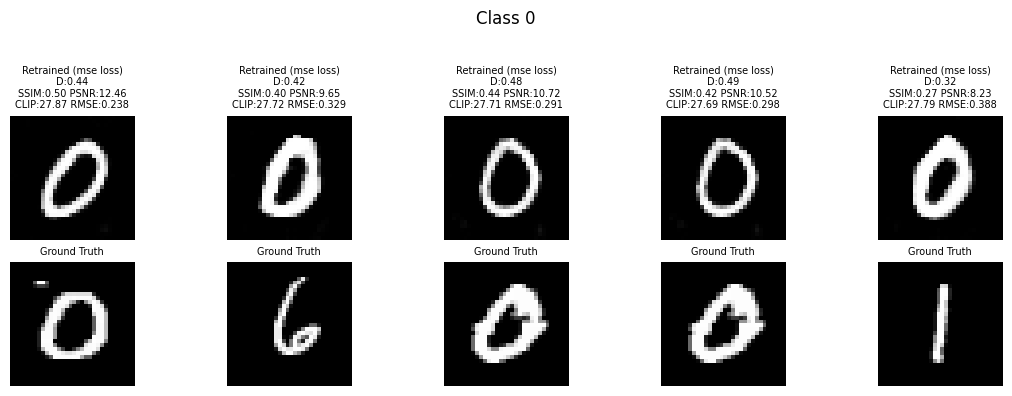

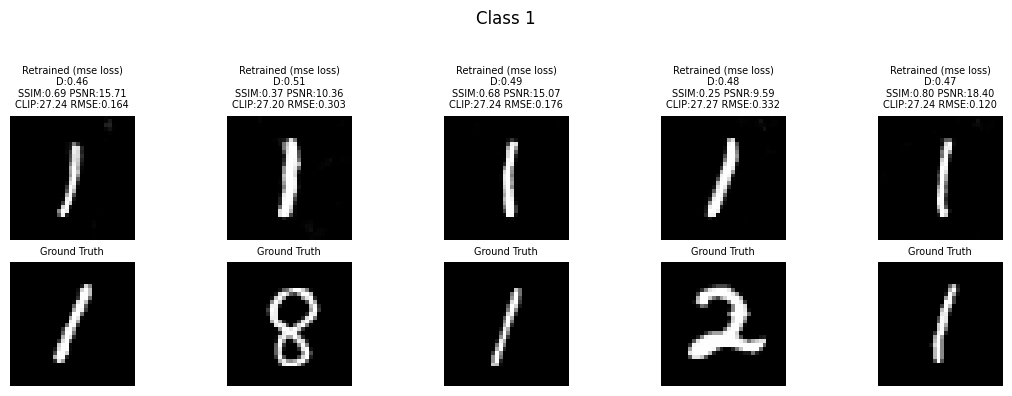

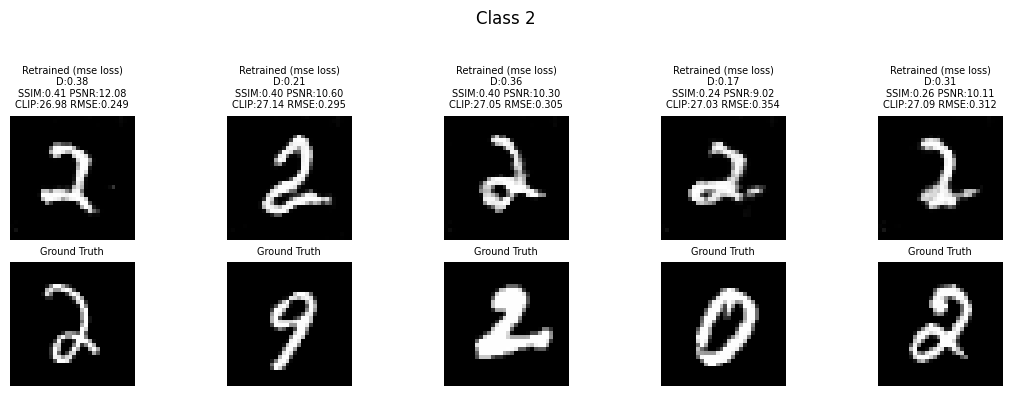

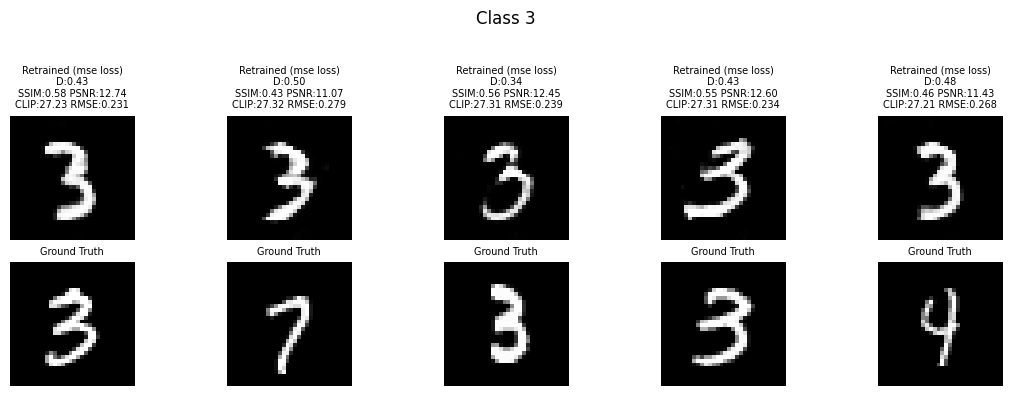

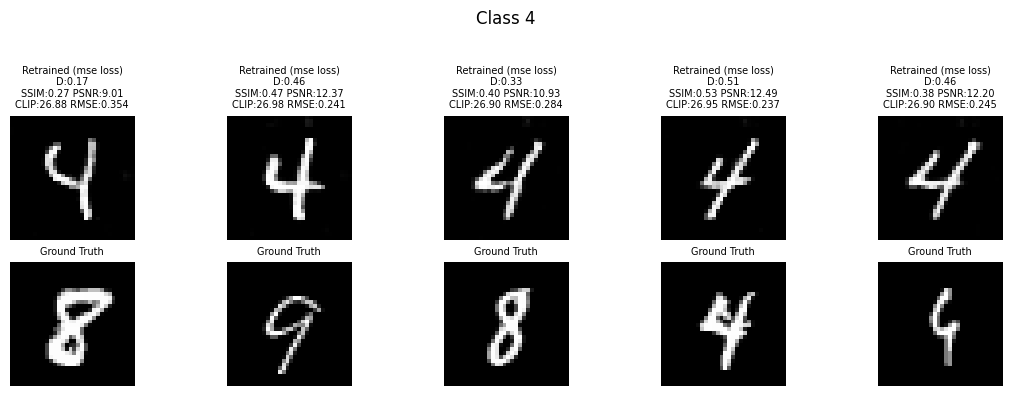

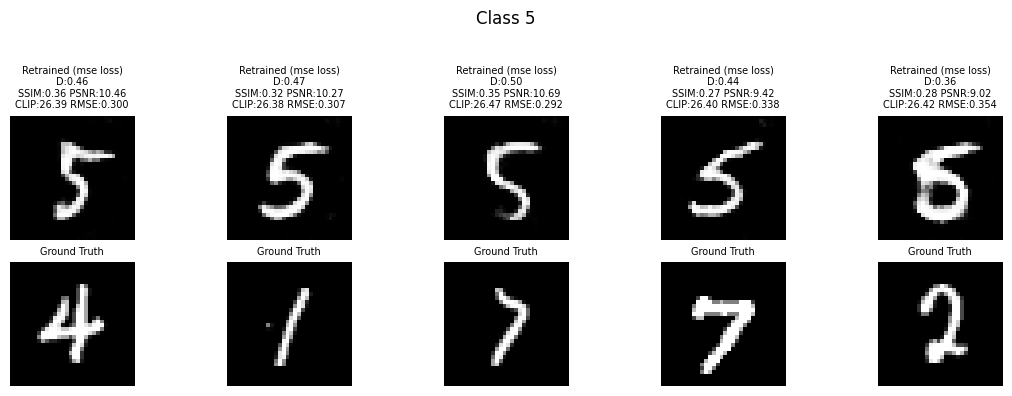

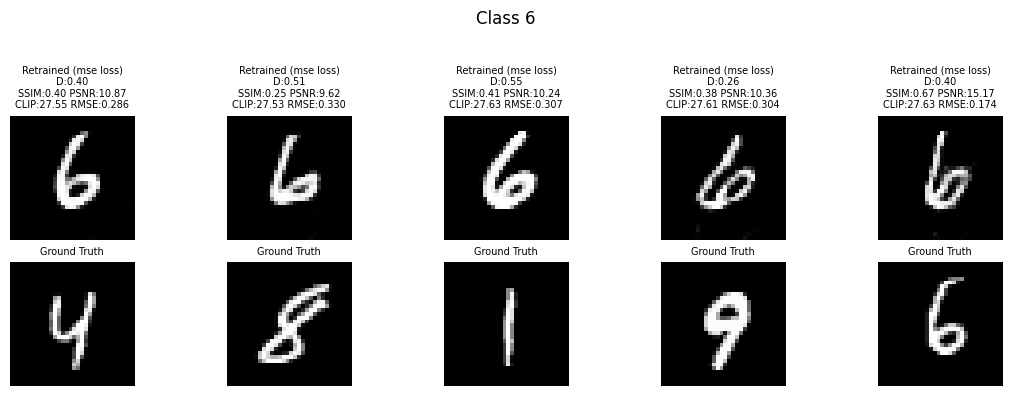

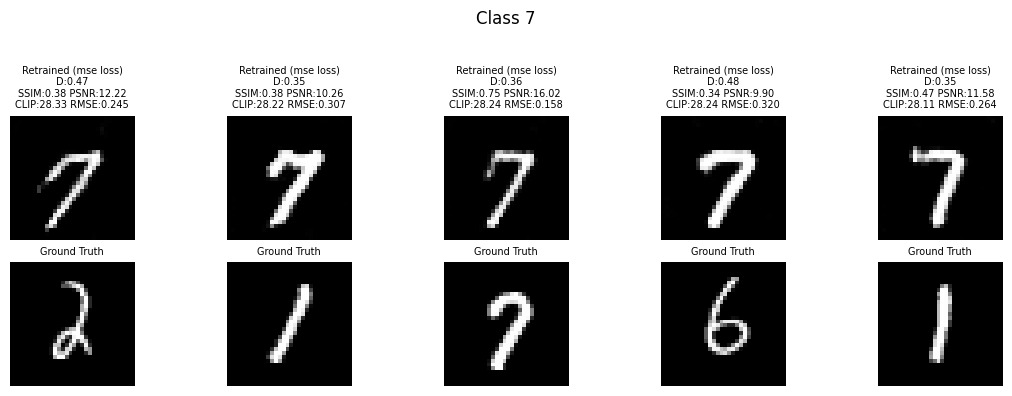

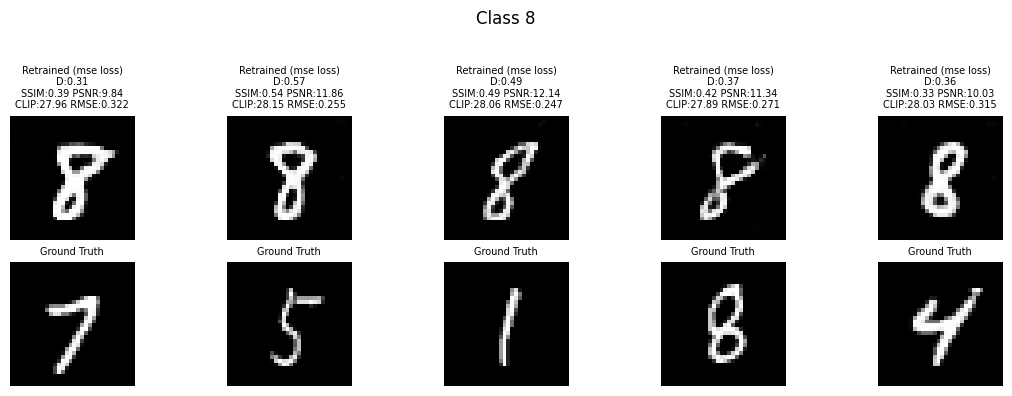

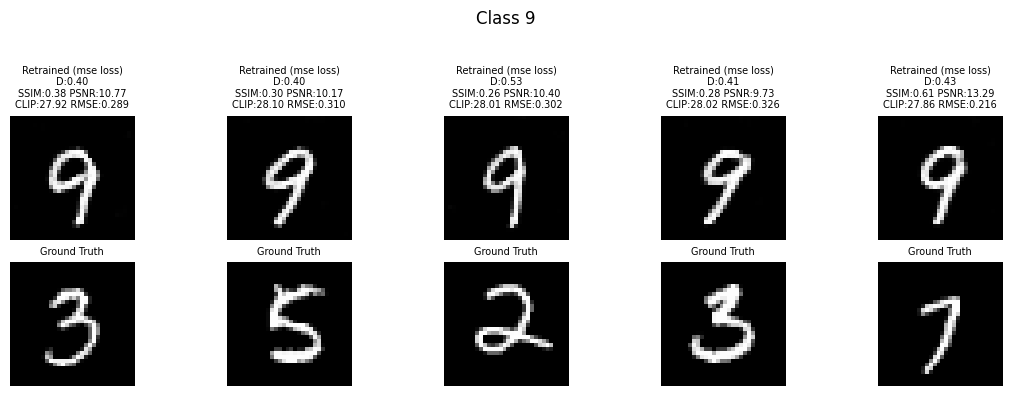


Per-Class Averages:
Class 0 - SSIM: 0.3609, PSNR: 10.08, CLIP: 27.8015, RMSE: 0.3184
Class 1 - SSIM: 0.4848, PSNR: 12.44, CLIP: 27.2585, RMSE: 0.2516
Class 2 - SSIM: 0.3671, PSNR: 10.76, CLIP: 27.0629, RMSE: 0.2920
Class 3 - SSIM: 0.4255, PSNR: 11.14, CLIP: 27.3128, RMSE: 0.2812
Class 4 - SSIM: 0.4125, PSNR: 11.38, CLIP: 26.8840, RMSE: 0.2734
Class 5 - SSIM: 0.4214, PSNR: 11.41, CLIP: 26.3994, RMSE: 0.2714
Class 6 - SSIM: 0.4371, PSNR: 11.13, CLIP: 27.6018, RMSE: 0.2819
Class 7 - SSIM: 0.4654, PSNR: 11.72, CLIP: 28.1747, RMSE: 0.2659
Class 8 - SSIM: 0.4462, PSNR: 11.20, CLIP: 28.0322, RMSE: 0.2778
Class 9 - SSIM: 0.4816, PSNR: 11.73, CLIP: 27.9791, RMSE: 0.2632

Calculating Inception Score and FID...


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 294MB/s]
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


Inception Score: 2.02 ± 0.04
FID Score: 16.55
--------------------------------------- END --------------------------------------- 
------------------------ EVALUATING MODELS OF bce ------------------------ 
Models of bce loss loaded successfully!
Evaluating per-class generation with metrics and visualization...


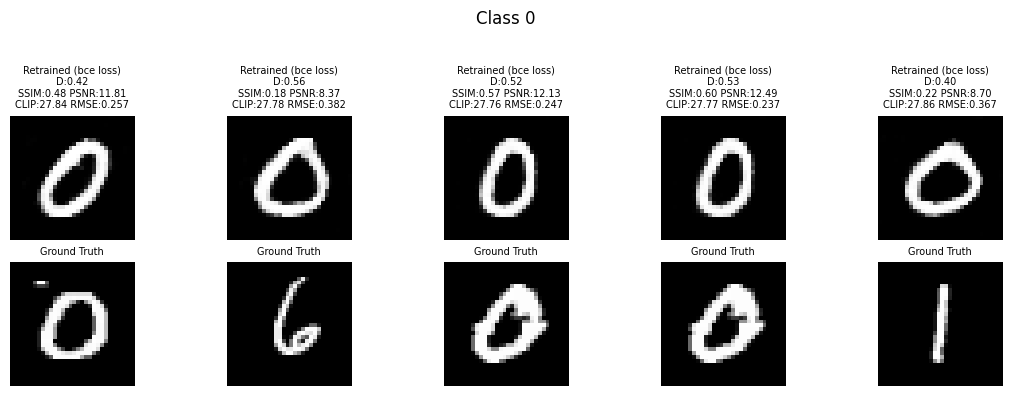

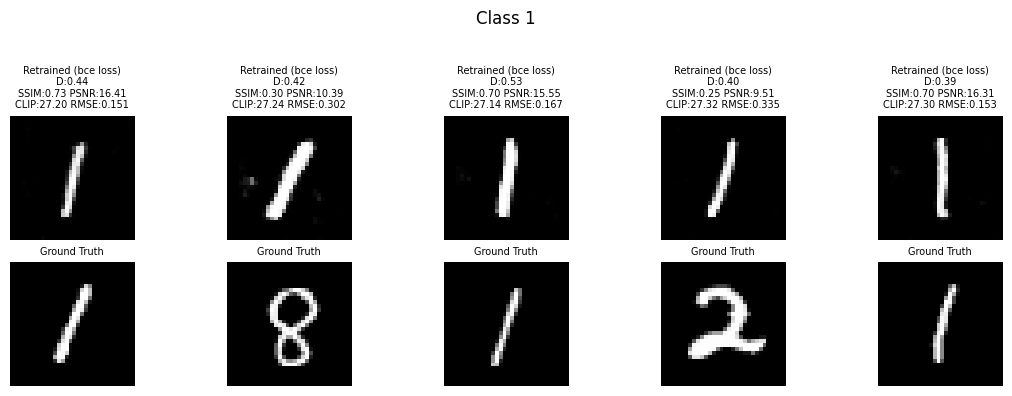

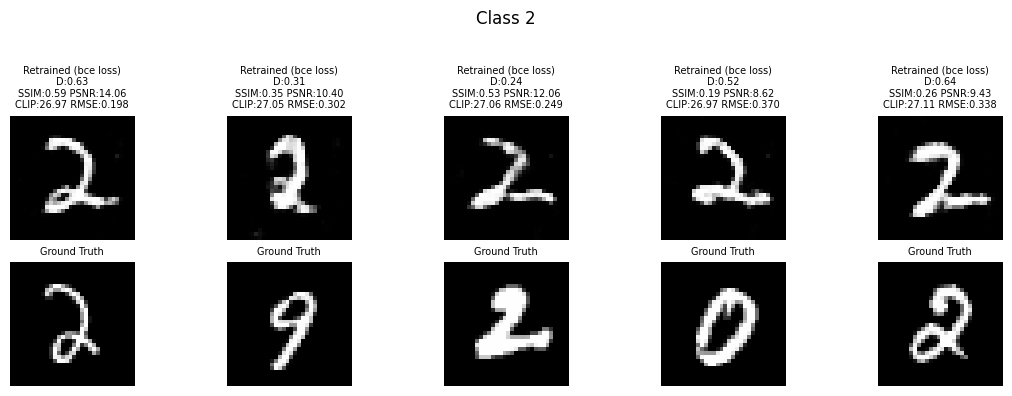

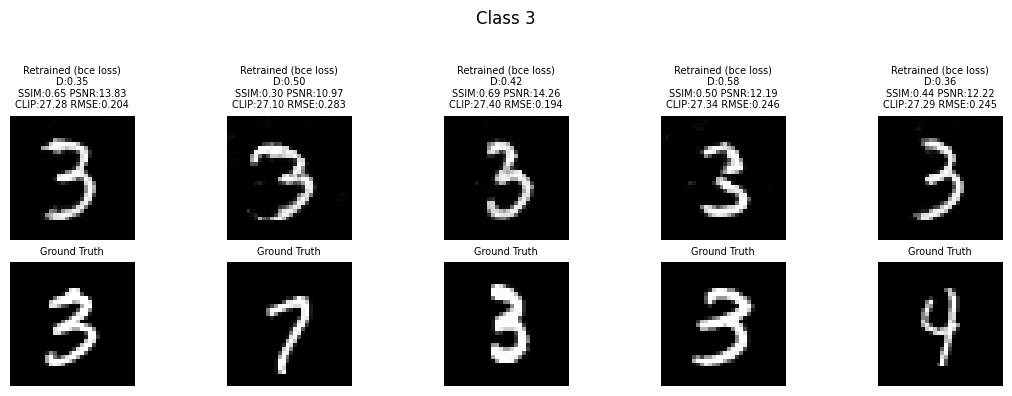

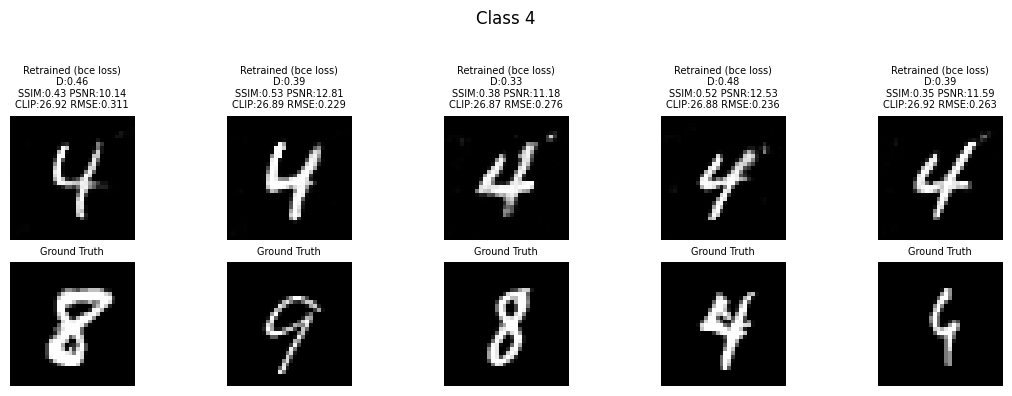

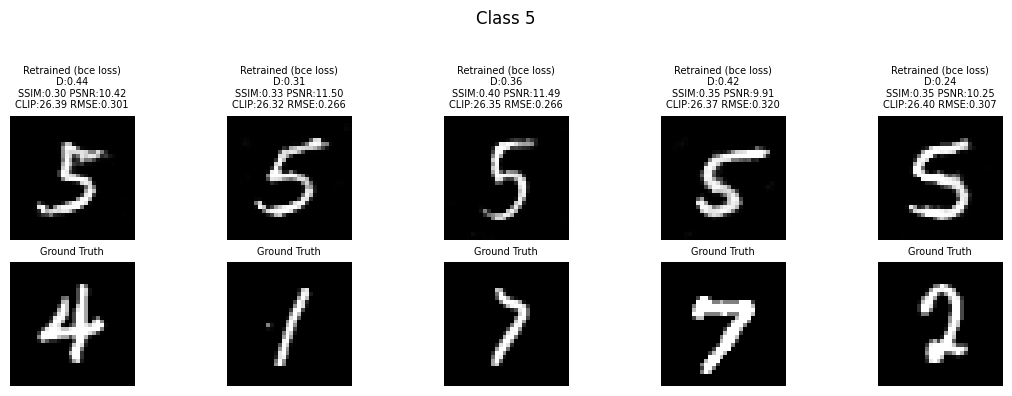

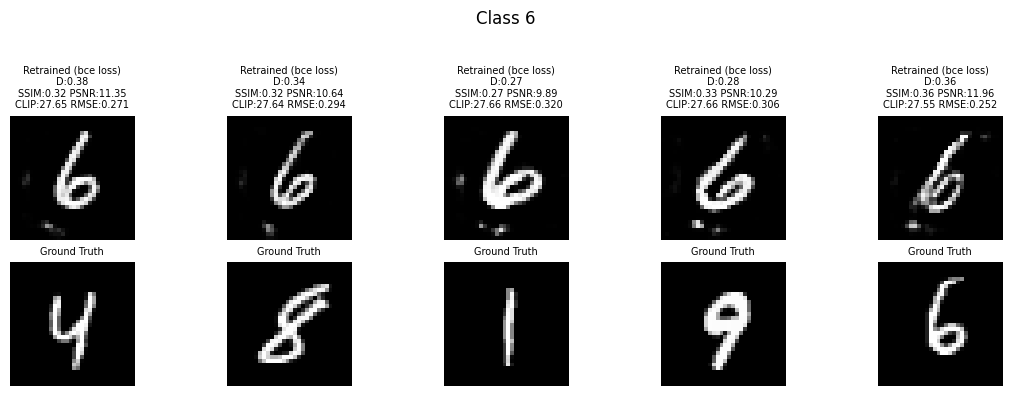

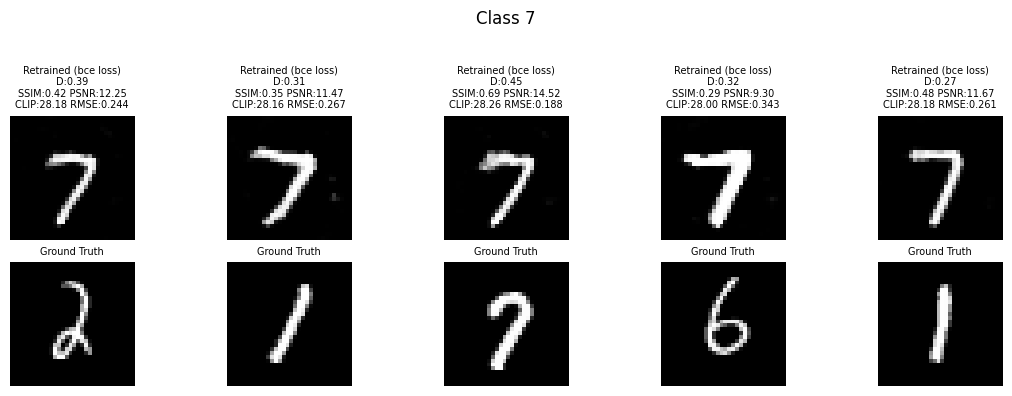

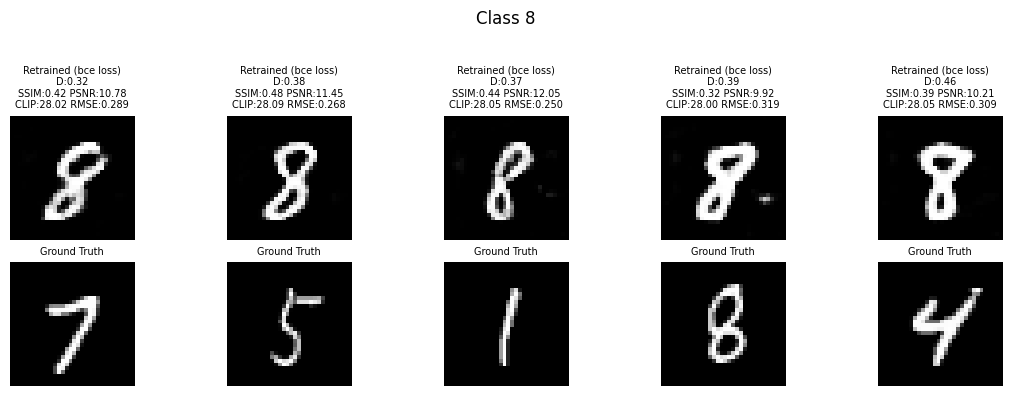

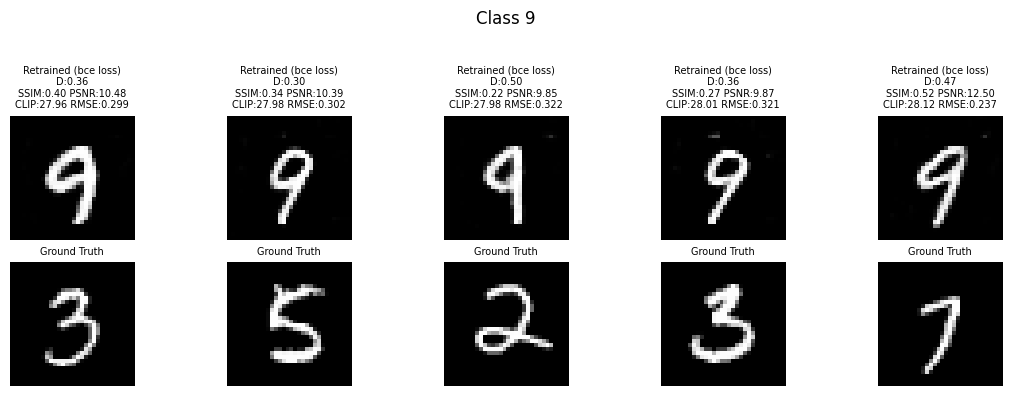


Per-Class Averages:
Class 0 - SSIM: 0.3710, PSNR: 10.23, CLIP: 27.8064, RMSE: 0.3131
Class 1 - SSIM: 0.4698, PSNR: 12.50, CLIP: 27.2383, RMSE: 0.2498
Class 2 - SSIM: 0.3464, PSNR: 10.71, CLIP: 27.0419, RMSE: 0.2939
Class 3 - SSIM: 0.3976, PSNR: 11.07, CLIP: 27.3081, RMSE: 0.2831
Class 4 - SSIM: 0.4059, PSNR: 11.42, CLIP: 26.8570, RMSE: 0.2723
Class 5 - SSIM: 0.4126, PSNR: 11.41, CLIP: 26.3779, RMSE: 0.2714
Class 6 - SSIM: 0.3598, PSNR: 10.94, CLIP: 27.5993, RMSE: 0.2884
Class 7 - SSIM: 0.4382, PSNR: 11.67, CLIP: 28.1589, RMSE: 0.2670
Class 8 - SSIM: 0.4330, PSNR: 11.15, CLIP: 28.0398, RMSE: 0.2799
Class 9 - SSIM: 0.4695, PSNR: 11.78, CLIP: 27.9706, RMSE: 0.2617

Calculating Inception Score and FID...
Inception Score: 2.05 ± 0.02
FID Score: 24.40
--------------------------------------- END --------------------------------------- 
------------------------ EVALUATING MODELS OF perceptual ------------------------ 
Models of perceptual loss loaded successfully!
Evaluating per-class generat

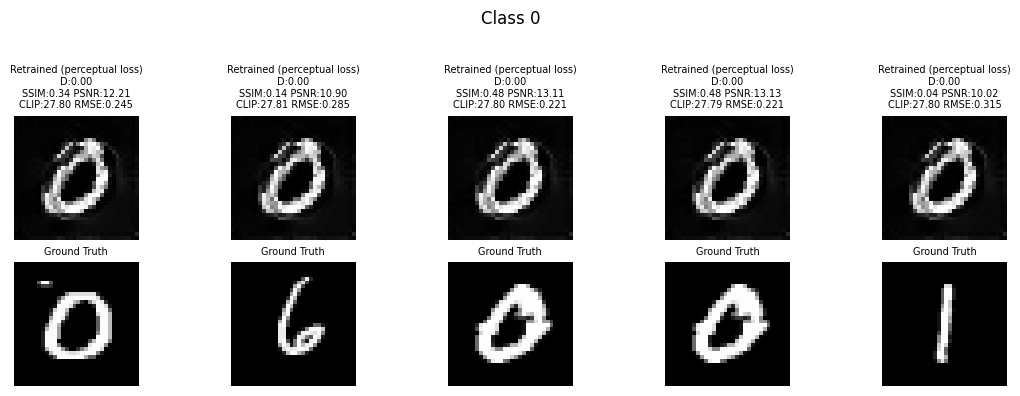

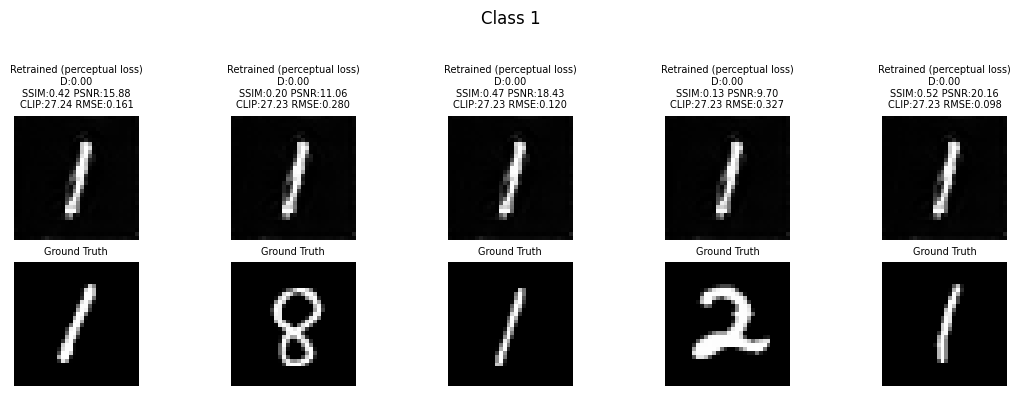

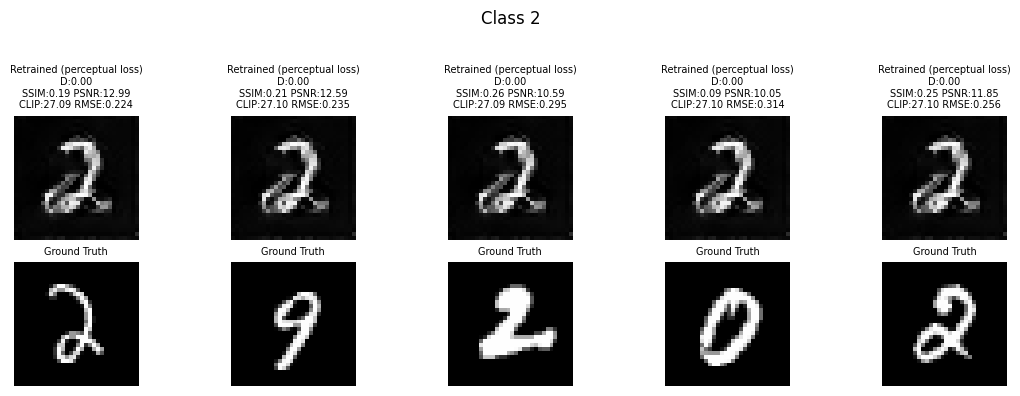

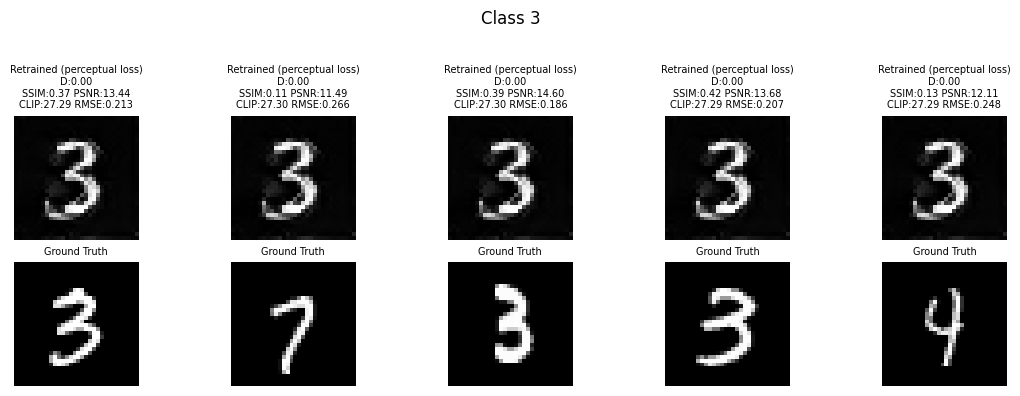

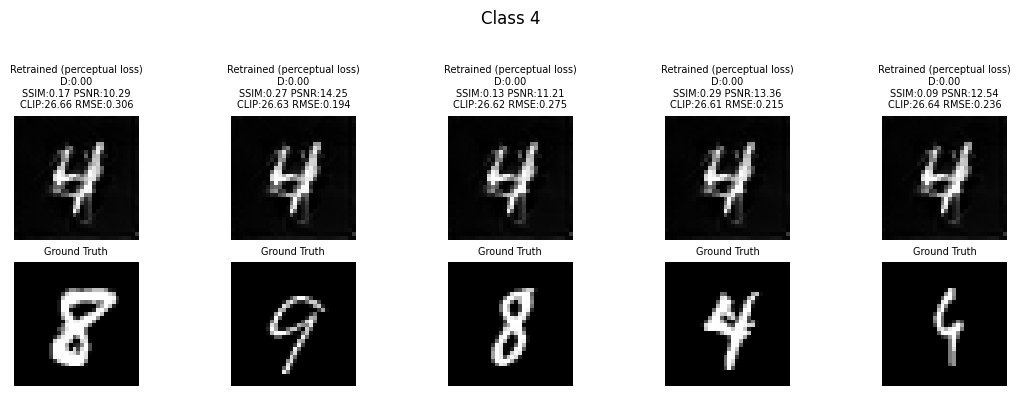

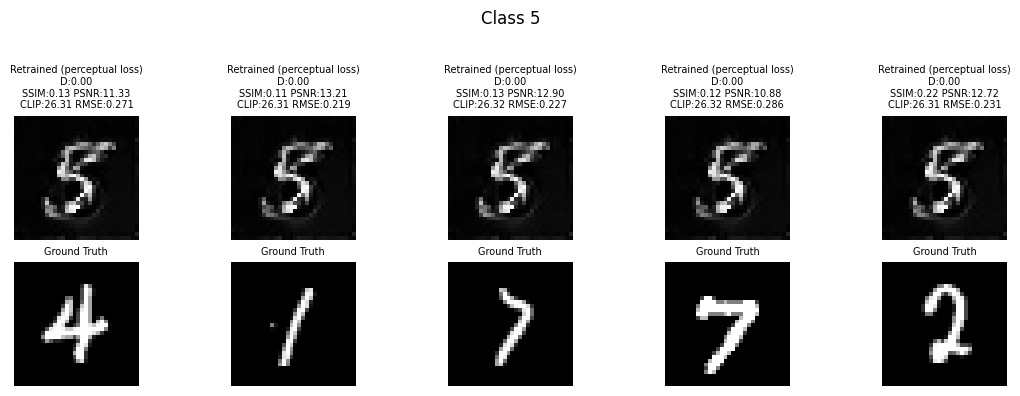

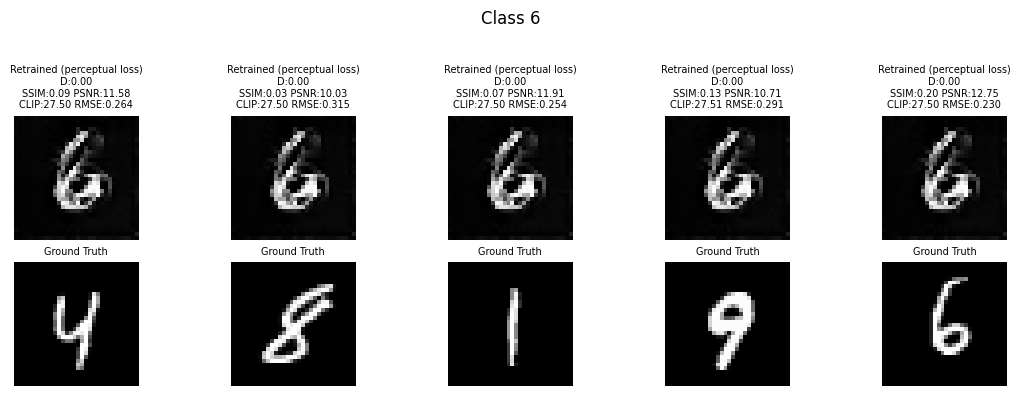

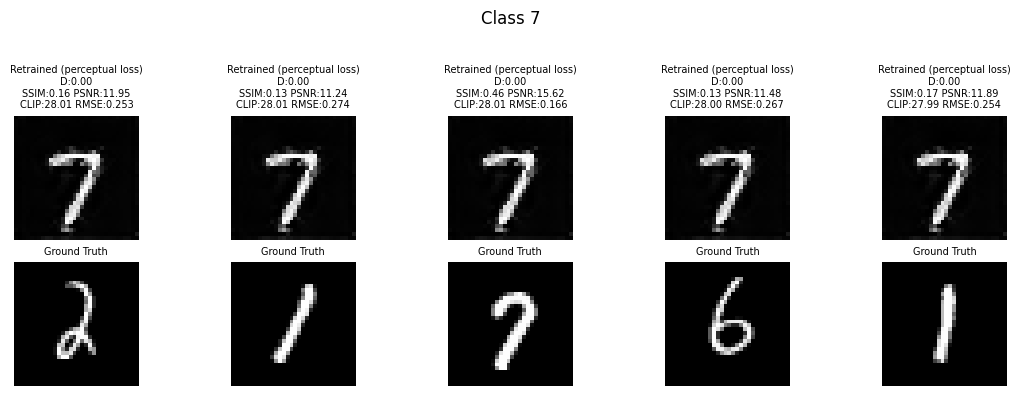

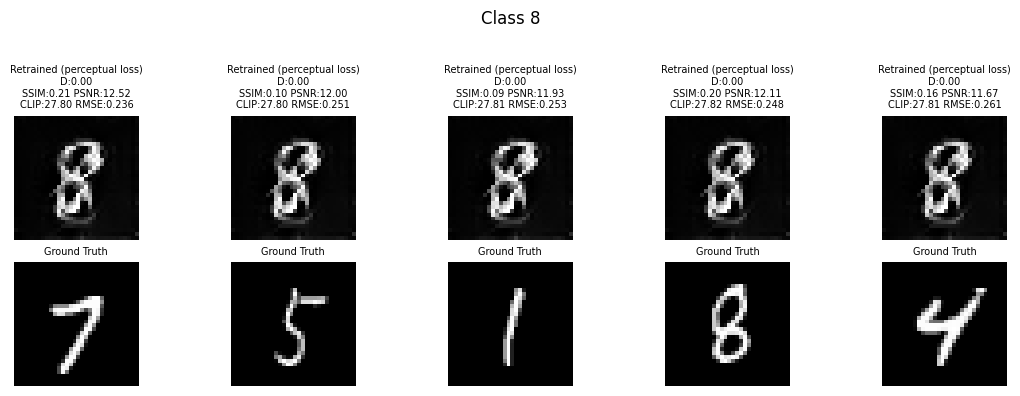

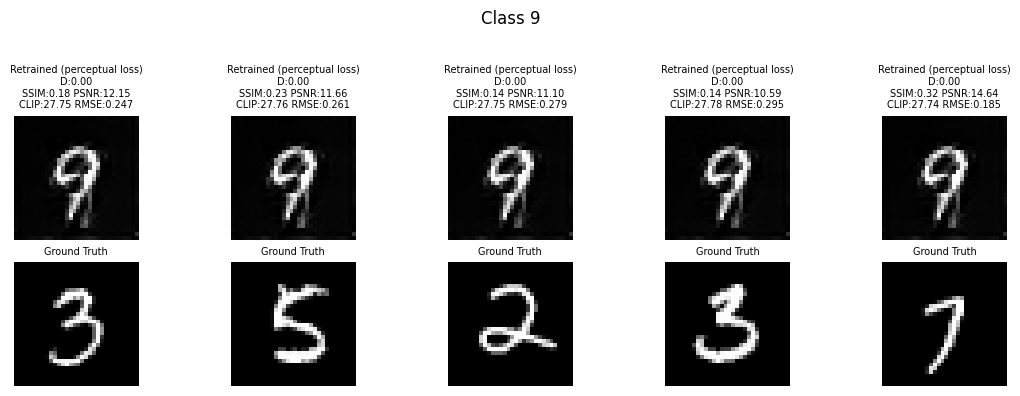


Per-Class Averages:
Class 0 - SSIM: 0.1805, PSNR: 10.83, CLIP: 27.8055, RMSE: 0.2901
Class 1 - SSIM: 0.2684, PSNR: 12.97, CLIP: 27.2373, RMSE: 0.2373
Class 2 - SSIM: 0.1523, PSNR: 11.74, CLIP: 27.0981, RMSE: 0.2604
Class 3 - SSIM: 0.1994, PSNR: 11.89, CLIP: 27.2838, RMSE: 0.2578
Class 4 - SSIM: 0.1804, PSNR: 12.17, CLIP: 26.6389, RMSE: 0.2495
Class 5 - SSIM: 0.1541, PSNR: 12.10, CLIP: 26.3109, RMSE: 0.2500
Class 6 - SSIM: 0.1443, PSNR: 11.39, CLIP: 27.5071, RMSE: 0.2713
Class 7 - SSIM: 0.2439, PSNR: 12.33, CLIP: 28.0049, RMSE: 0.2483
Class 8 - SSIM: 0.1782, PSNR: 11.75, CLIP: 27.8068, RMSE: 0.2594
Class 9 - SSIM: 0.2255, PSNR: 12.31, CLIP: 27.7543, RMSE: 0.2455

Calculating Inception Score and FID...
Inception Score: 1.99 ± 0.03
FID Score: 142.33
--------------------------------------- END --------------------------------------- 
------------------------ EVALUATING MODELS OF adversarial ------------------------ 
Models of adversarial loss loaded successfully!
Evaluating per-class gene

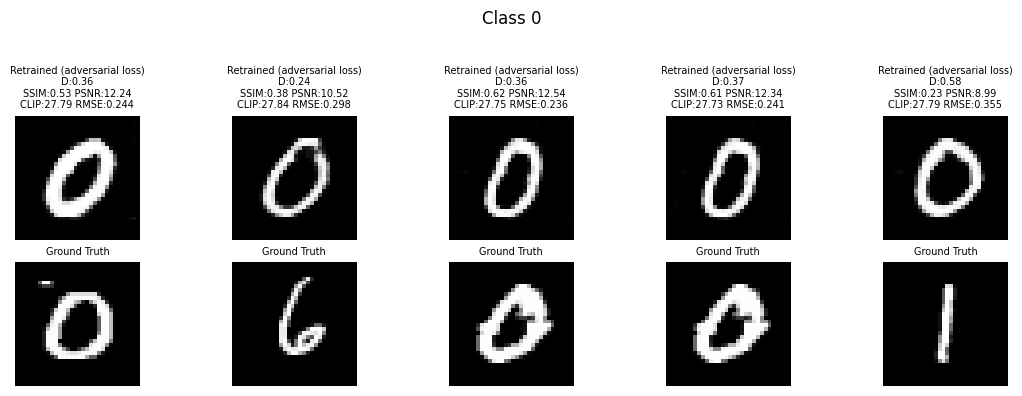

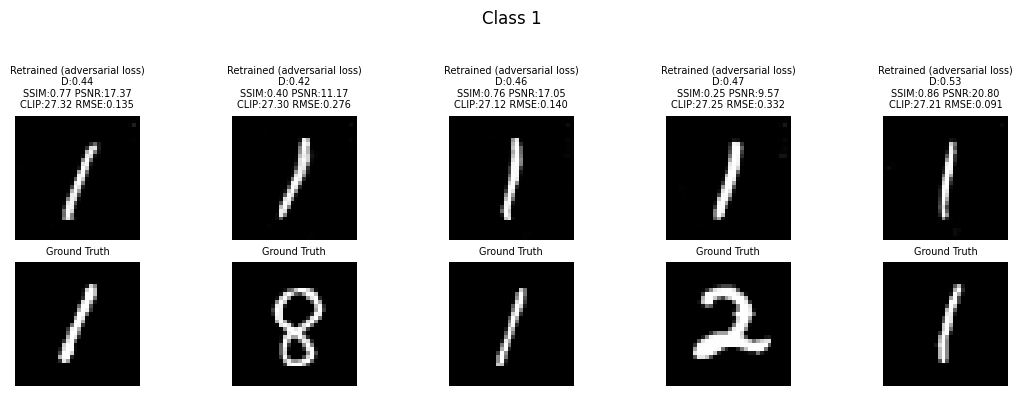

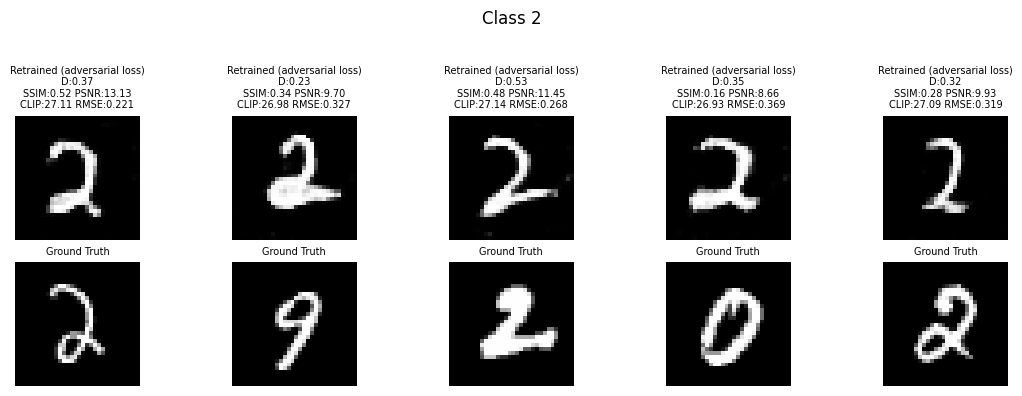

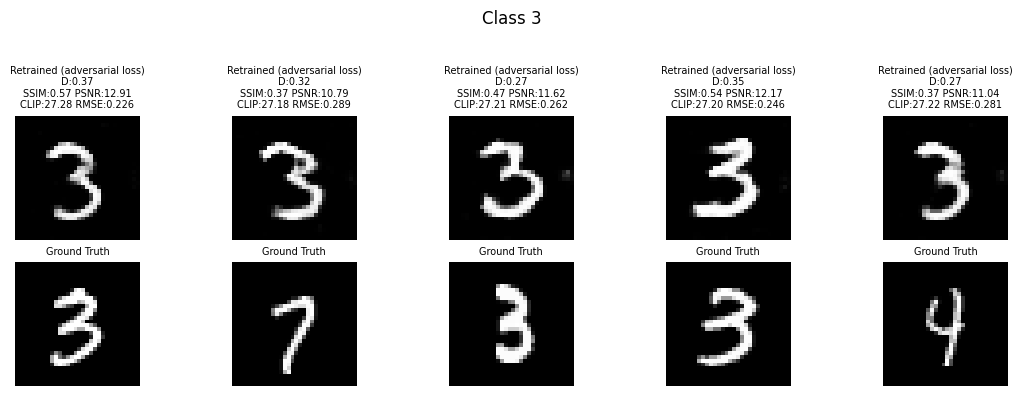

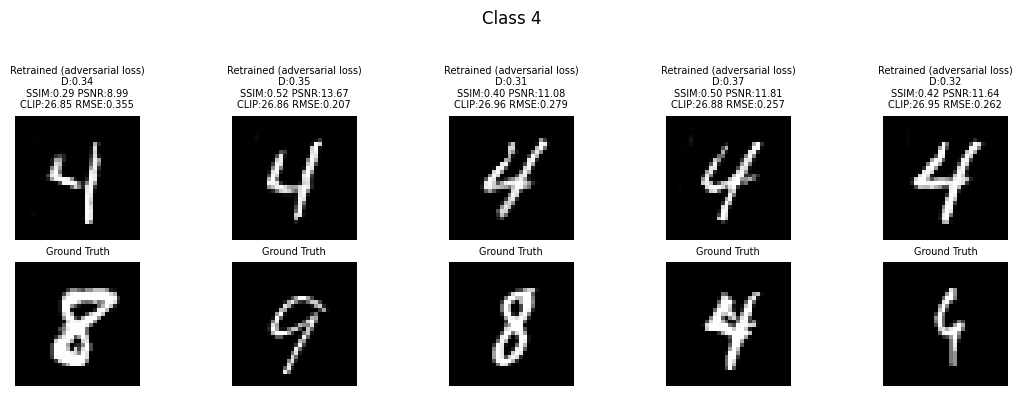

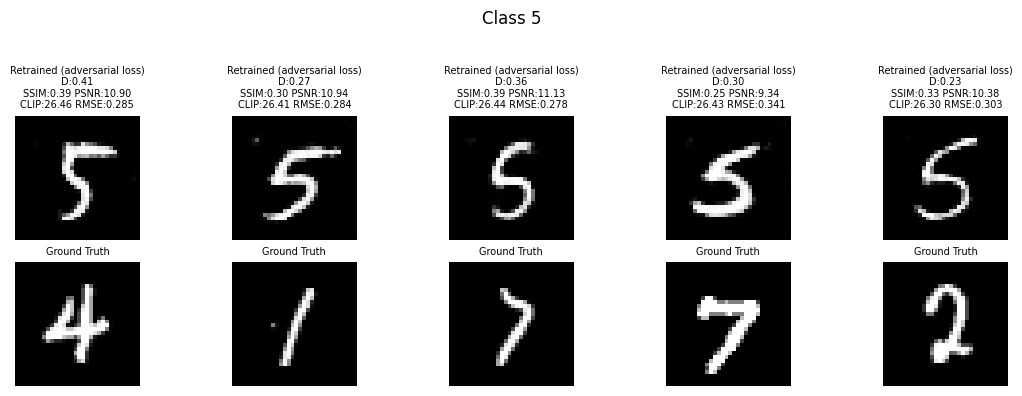

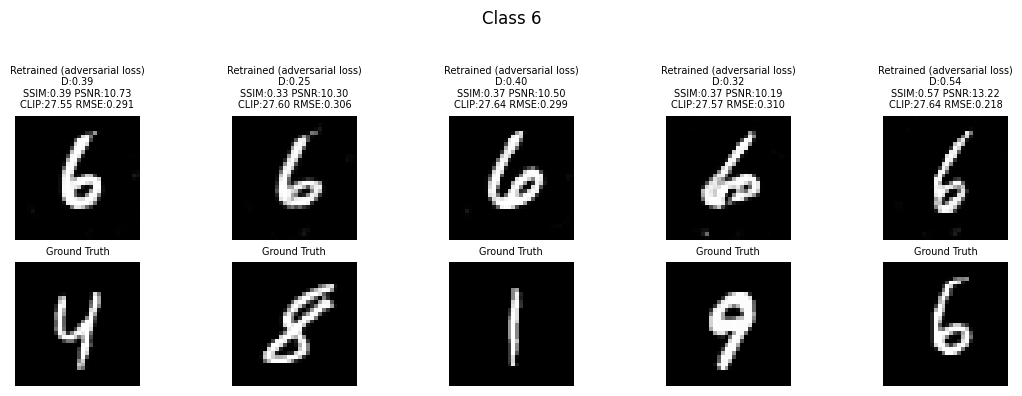

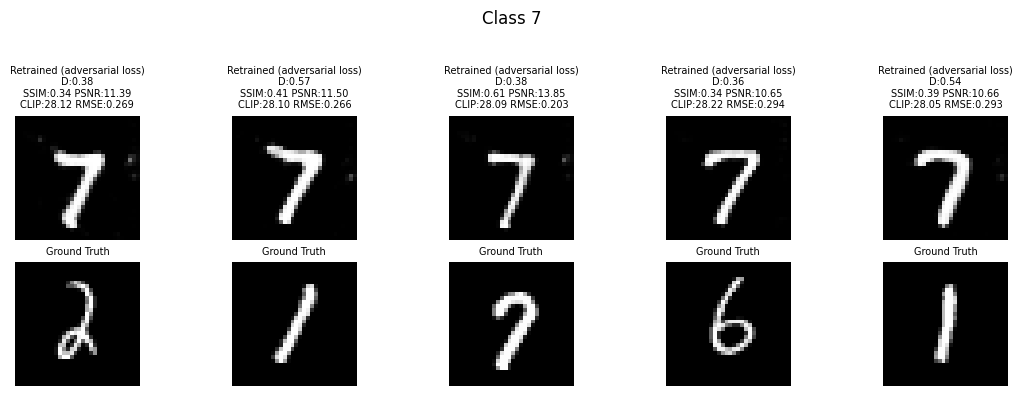

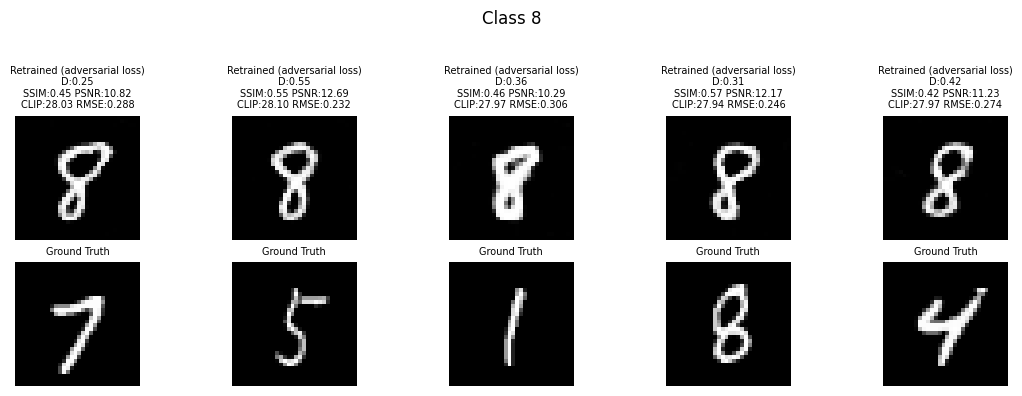

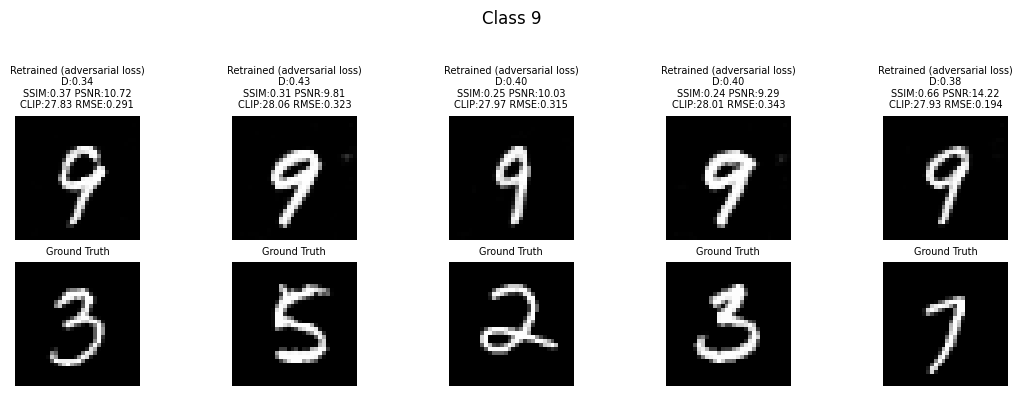


Per-Class Averages:
Class 0 - SSIM: 0.3680, PSNR: 9.99, CLIP: 27.7936, RMSE: 0.3223
Class 1 - SSIM: 0.4855, PSNR: 12.42, CLIP: 27.2433, RMSE: 0.2509
Class 2 - SSIM: 0.3582, PSNR: 10.70, CLIP: 27.0625, RMSE: 0.2940
Class 3 - SSIM: 0.3973, PSNR: 11.06, CLIP: 27.3041, RMSE: 0.2837
Class 4 - SSIM: 0.4116, PSNR: 11.48, CLIP: 26.8767, RMSE: 0.2701
Class 5 - SSIM: 0.4086, PSNR: 11.34, CLIP: 26.3785, RMSE: 0.2732
Class 6 - SSIM: 0.4217, PSNR: 11.10, CLIP: 27.6116, RMSE: 0.2828
Class 7 - SSIM: 0.4307, PSNR: 11.65, CLIP: 28.1471, RMSE: 0.2670
Class 8 - SSIM: 0.4568, PSNR: 11.17, CLIP: 28.0261, RMSE: 0.2787
Class 9 - SSIM: 0.4811, PSNR: 11.62, CLIP: 27.9522, RMSE: 0.2668

Calculating Inception Score and FID...
Inception Score: 2.09 ± 0.07
FID Score: 19.69
--------------------------------------- END --------------------------------------- 
------------------------ EVALUATING MODELS OF hybrid ------------------------ 
Models of hybrid loss loaded successfully!
Evaluating per-class generation with 

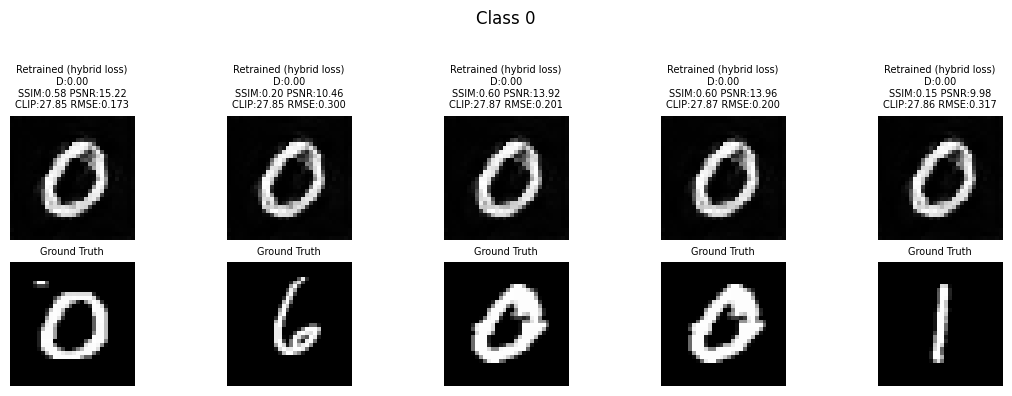

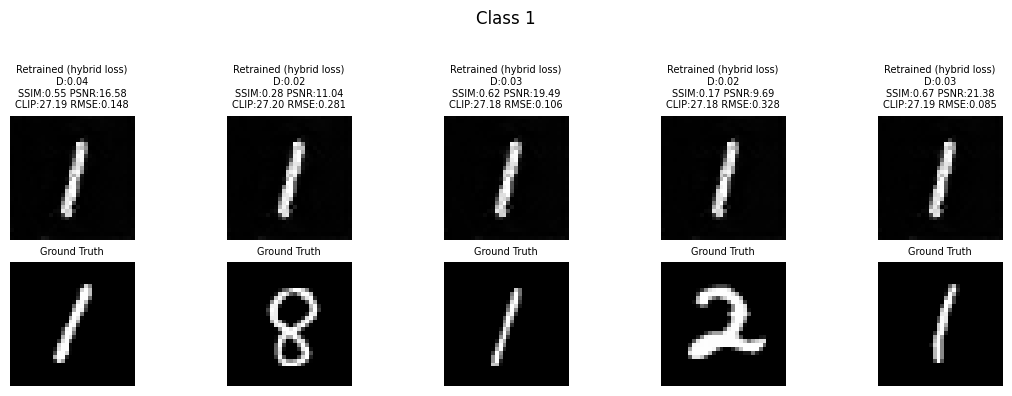

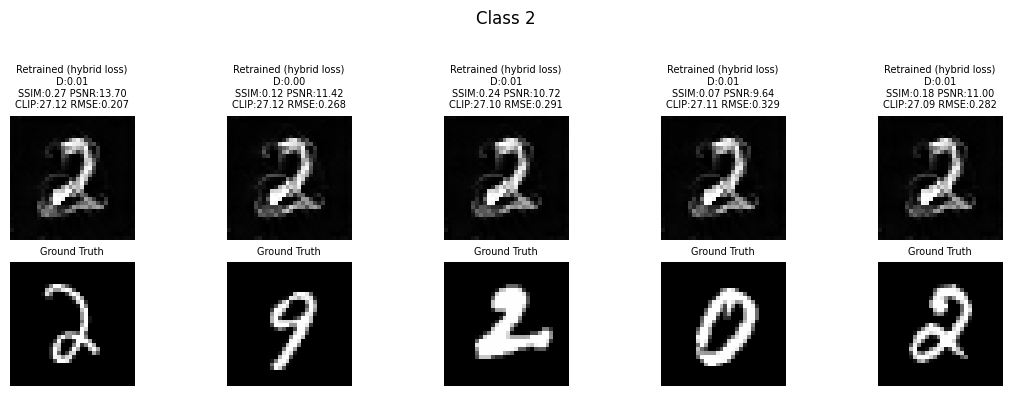

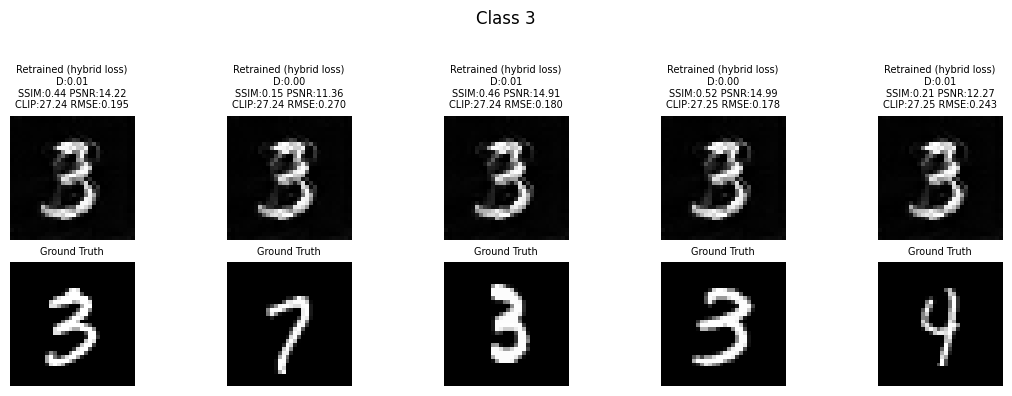

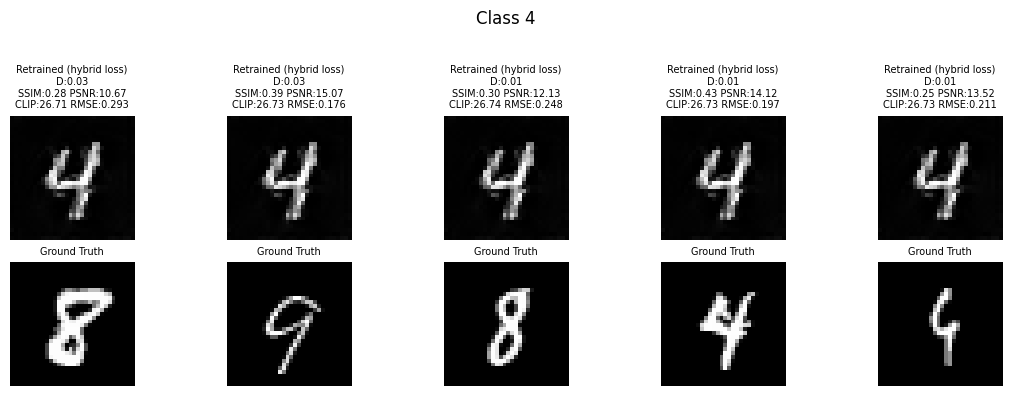

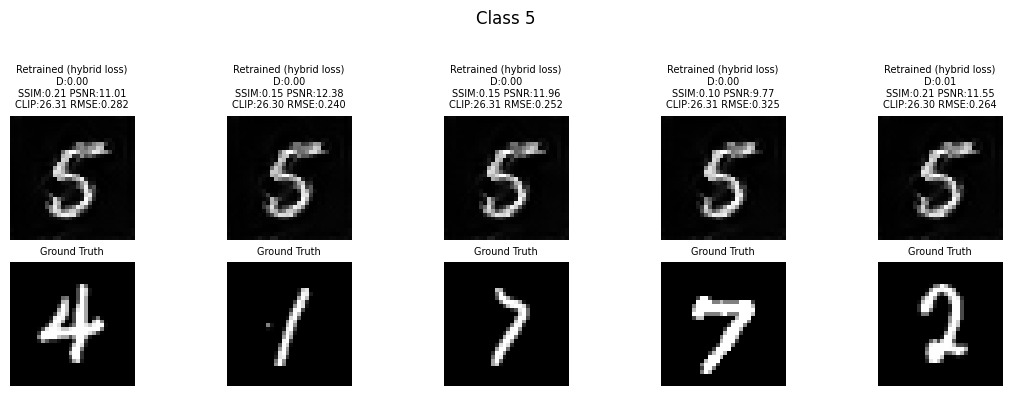

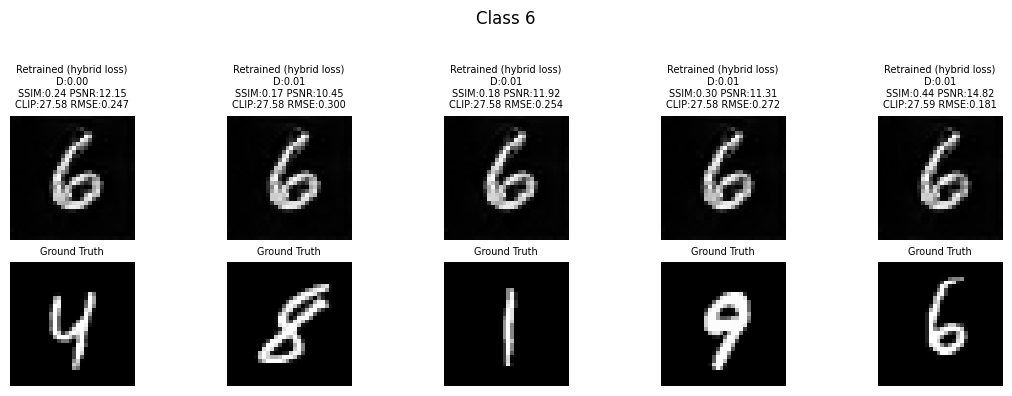

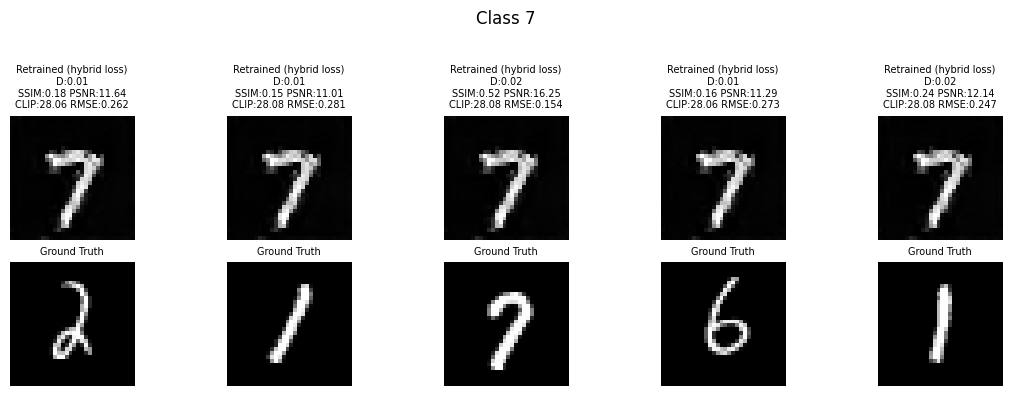

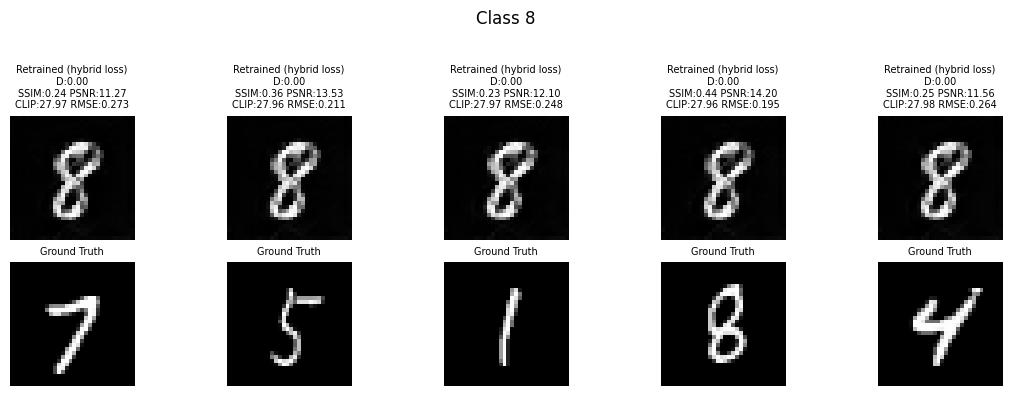

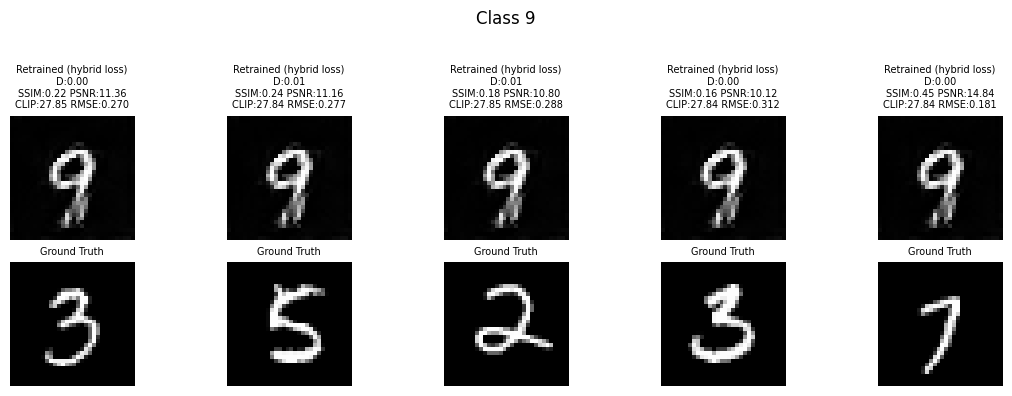


Per-Class Averages:
Class 0 - SSIM: 0.2825, PSNR: 11.11, CLIP: 27.8560, RMSE: 0.2852
Class 1 - SSIM: 0.3562, PSNR: 13.02, CLIP: 27.1882, RMSE: 0.2384
Class 2 - SSIM: 0.1803, PSNR: 11.92, CLIP: 27.1036, RMSE: 0.2555
Class 3 - SSIM: 0.2566, PSNR: 12.05, CLIP: 27.2403, RMSE: 0.2537
Class 4 - SSIM: 0.2634, PSNR: 12.39, CLIP: 26.7339, RMSE: 0.2445
Class 5 - SSIM: 0.2667, PSNR: 12.40, CLIP: 26.3016, RMSE: 0.2425
Class 6 - SSIM: 0.2919, PSNR: 12.09, CLIP: 27.5857, RMSE: 0.2533
Class 7 - SSIM: 0.2846, PSNR: 12.38, CLIP: 28.0659, RMSE: 0.2474
Class 8 - SSIM: 0.3168, PSNR: 12.33, CLIP: 27.9661, RMSE: 0.2447
Class 9 - SSIM: 0.3250, PSNR: 12.47, CLIP: 27.8418, RMSE: 0.2430

Calculating Inception Score and FID...
Inception Score: 1.83 ± 0.05
FID Score: 96.12
--------------------------------------- END --------------------------------------- 


In [90]:
import torch
import os

loss_types = ['mse', 'bce', 'perceptual', 'adversarial', 'hybrid']

for loss_type in loss_types:
    print(f"------------------------ EVALUATING MODELS OF {loss_type} ------------------------ ")
    # Path ke model
    generator_path = f"/kaggle/working/MNIST_cDCGAN_results/{loss_type}/generator_param.pkl"
    discriminator_path = f"/kaggle/working/MNIST_cDCGAN_results/{loss_type}/discriminator_param.pkl"
    
    # Load model
    G = generator(128)
    D = discriminator(128)
    
    # Load parameter
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    G.load_state_dict(torch.load(generator_path, map_location=device))
    D.load_state_dict(torch.load(discriminator_path, map_location=device))
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    G.eval().to(device)
    D.eval().to(device)
    
    print(f"Models of {loss_type} loss loaded successfully!")

    evaluate_all(G, D, final_pre_val_pairs, device)
    print(f"--------------------------------------- END --------------------------------------- ")

------------------------ EVALUATING MODELS OF mse ------------------------ 
Models of mse loss loaded successfully!
Evaluating per-class generation with metrics and visualization...


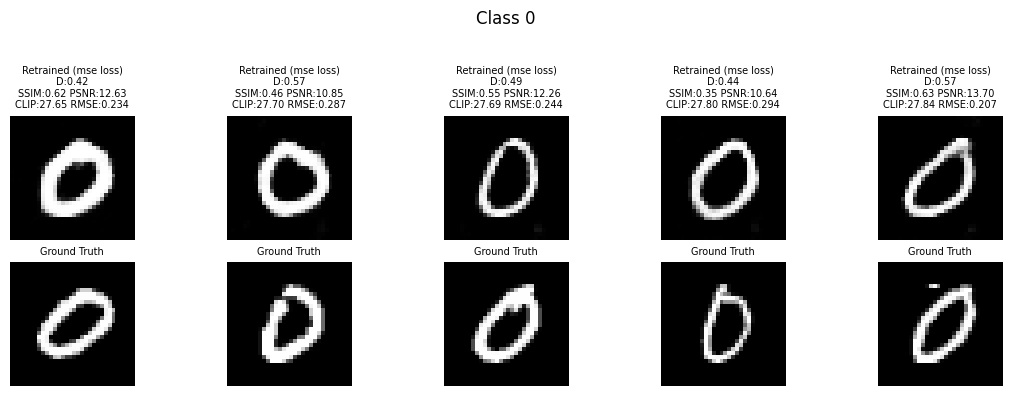

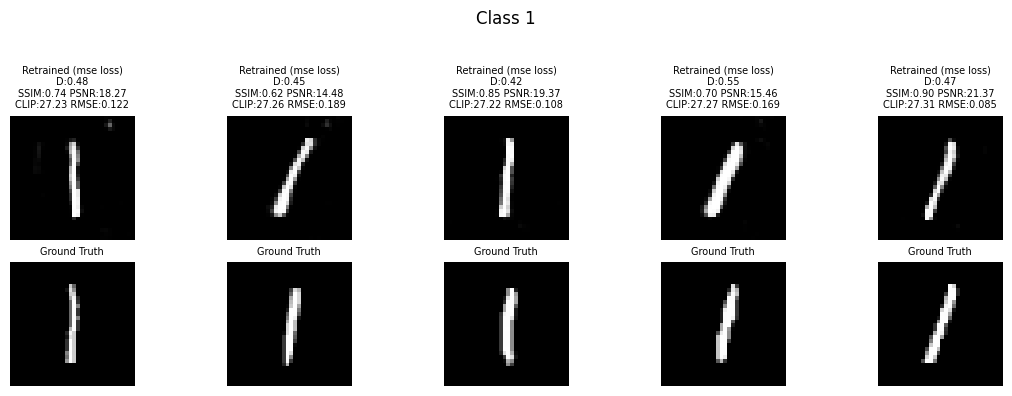

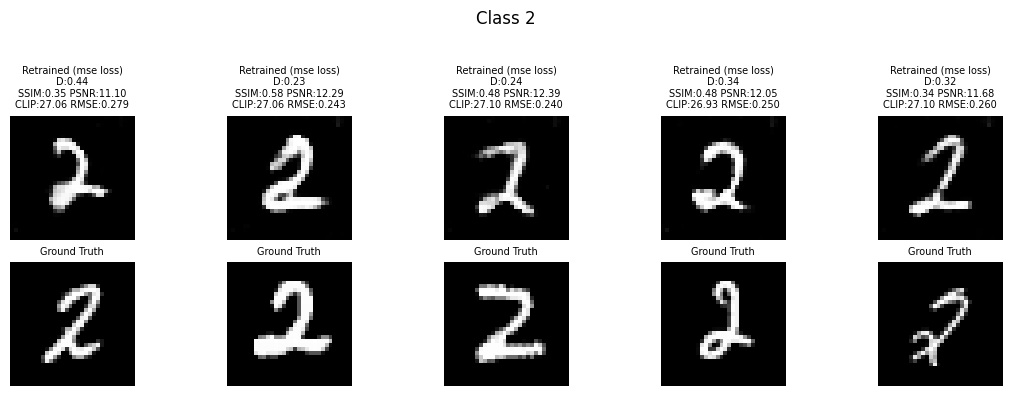

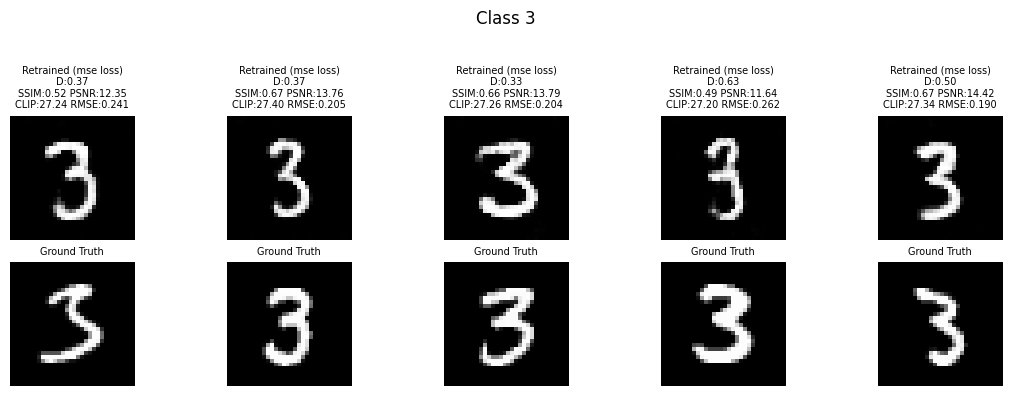

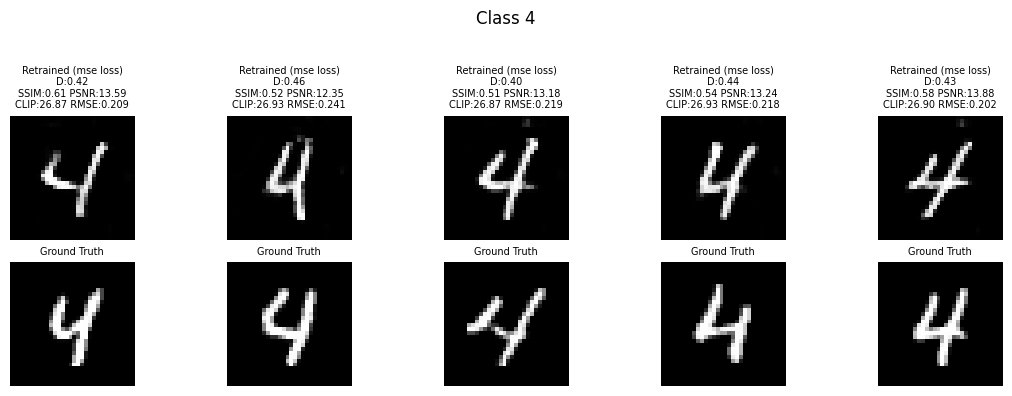

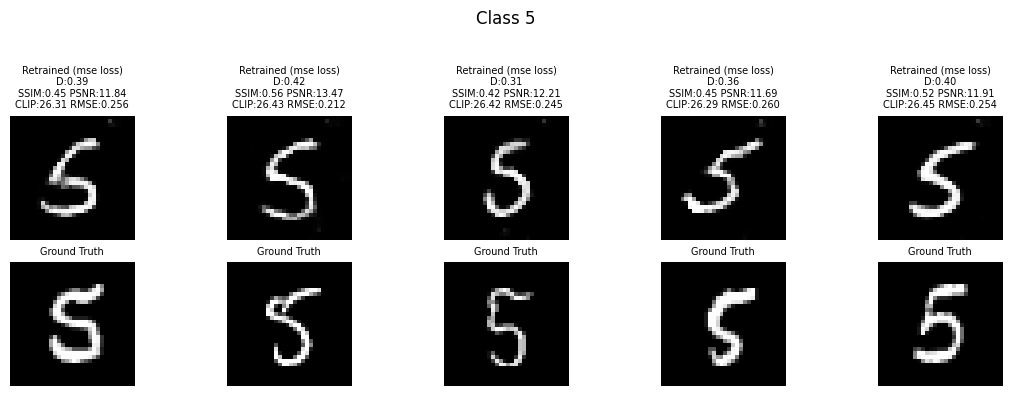

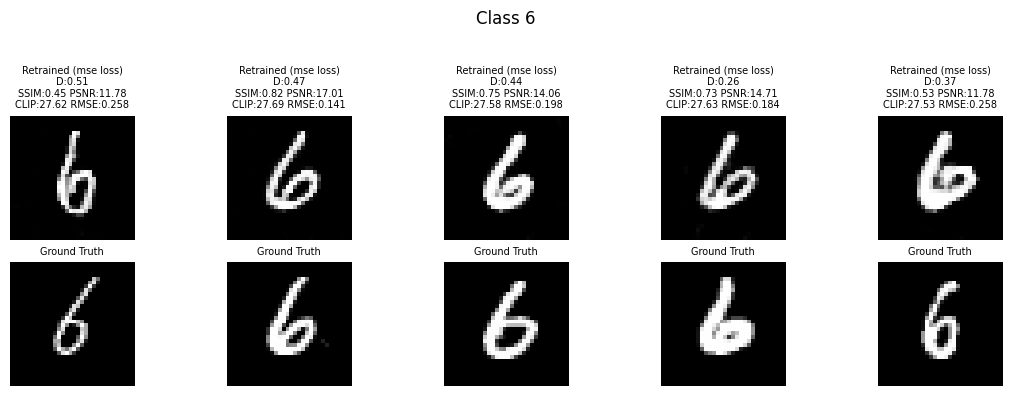

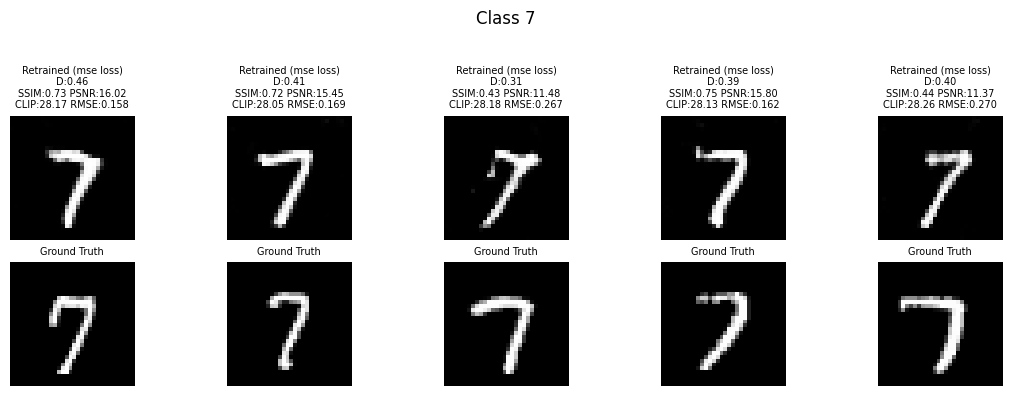

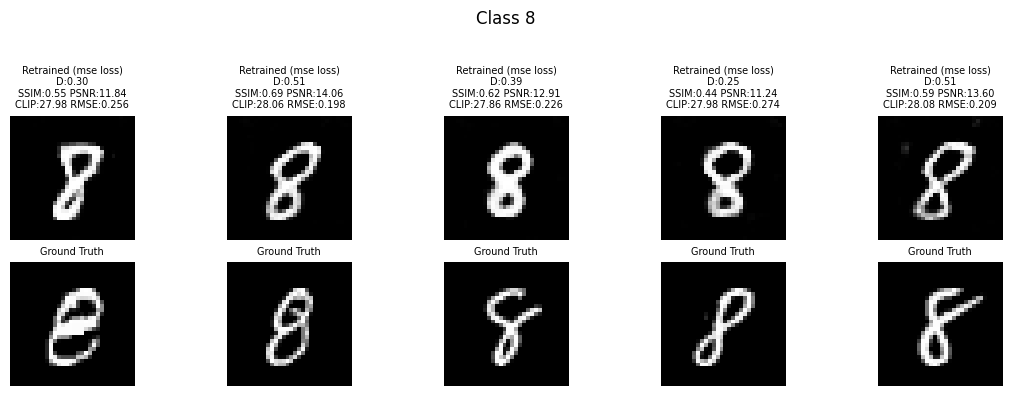

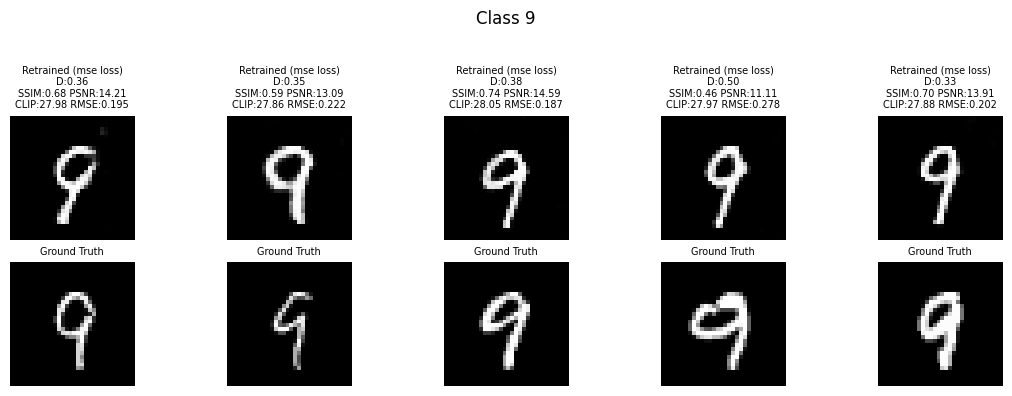


Per-Class Averages:
Class 0 - SSIM: 0.5724, PSNR: 12.43, CLIP: 27.7902, RMSE: 0.2427
Class 1 - SSIM: 0.7211, PSNR: 16.31, CLIP: 27.2619, RMSE: 0.1587
Class 2 - SSIM: 0.4184, PSNR: 11.47, CLIP: 27.0654, RMSE: 0.2698
Class 3 - SSIM: 0.5658, PSNR: 12.83, CLIP: 27.3233, RMSE: 0.2305
Class 4 - SSIM: 0.5048, PSNR: 12.78, CLIP: 26.8891, RMSE: 0.2320
Class 5 - SSIM: 0.4913, PSNR: 12.40, CLIP: 26.3943, RMSE: 0.2423
Class 6 - SSIM: 0.5784, PSNR: 12.73, CLIP: 27.6032, RMSE: 0.2350
Class 7 - SSIM: 0.6549, PSNR: 14.40, CLIP: 28.1668, RMSE: 0.1953
Class 8 - SSIM: 0.5527, PSNR: 12.40, CLIP: 28.0298, RMSE: 0.2425
Class 9 - SSIM: 0.6186, PSNR: 13.34, CLIP: 27.9701, RMSE: 0.2188

Calculating Inception Score and FID...
Inception Score: 1.96 ± 0.09
FID Score: 29.86
--------------------------------------- END --------------------------------------- 
------------------------ EVALUATING MODELS OF bce ------------------------ 
Models of bce loss loaded successfully!
Evaluating per-class generation with metri

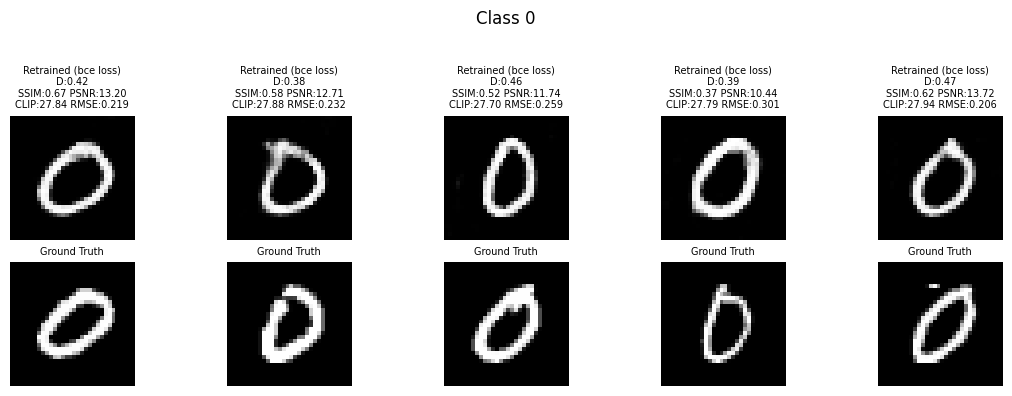

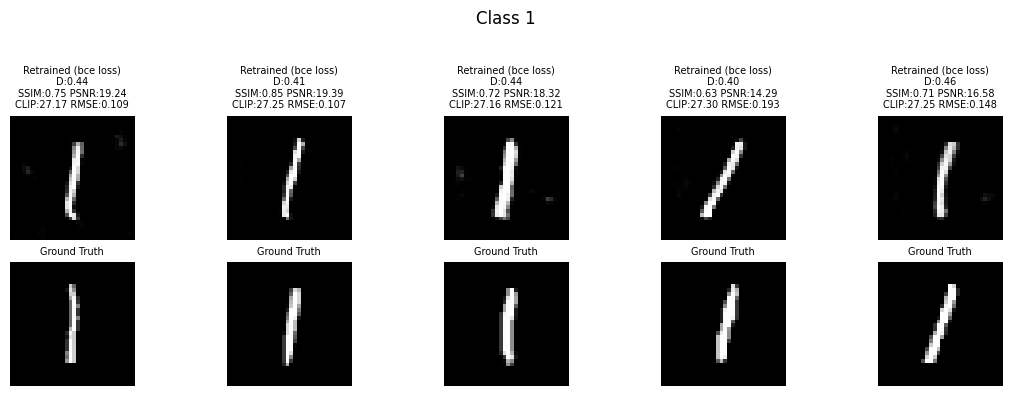

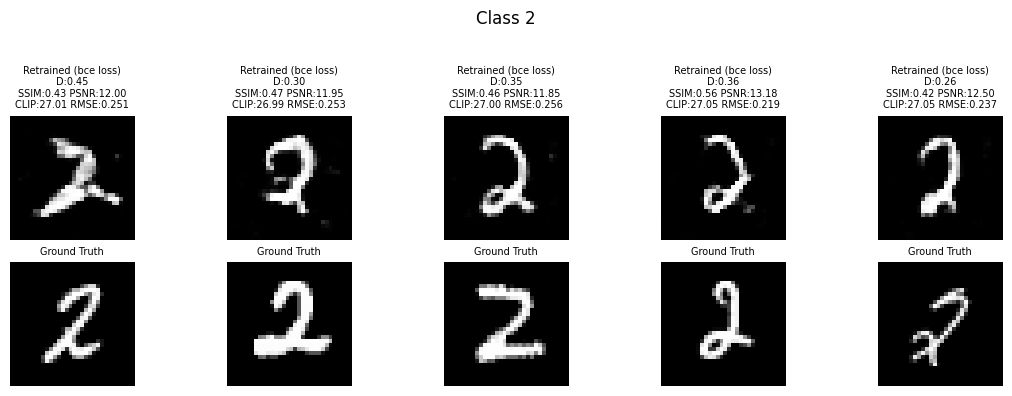

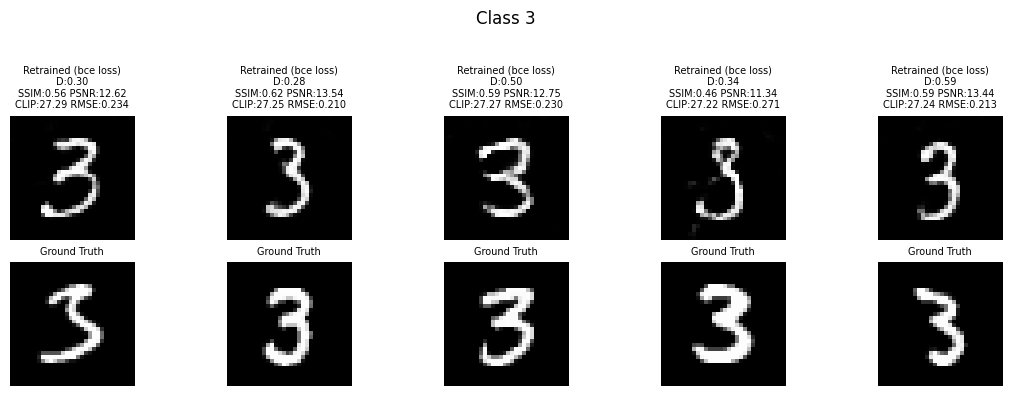

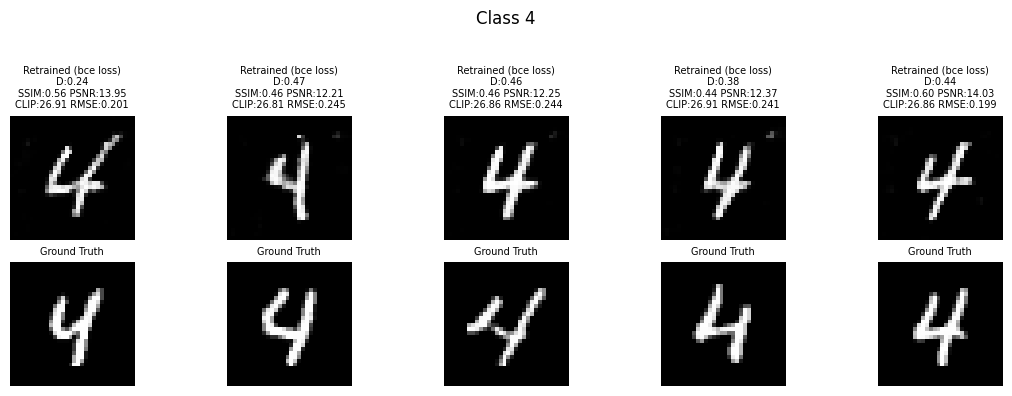

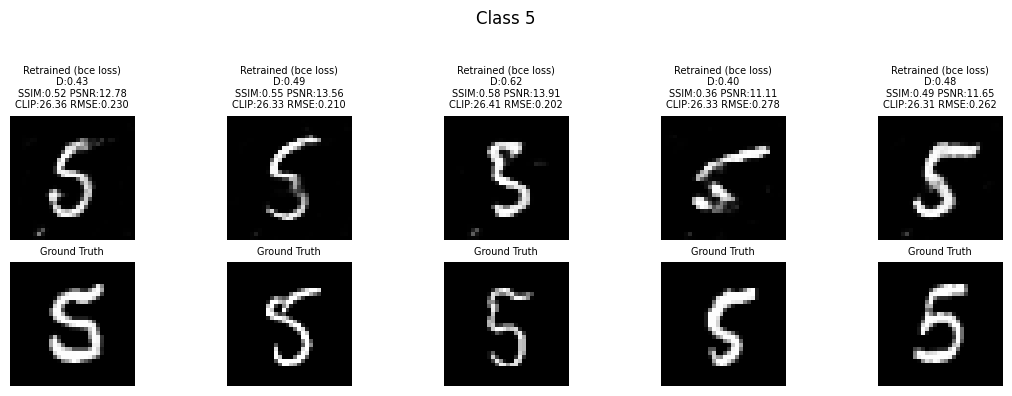

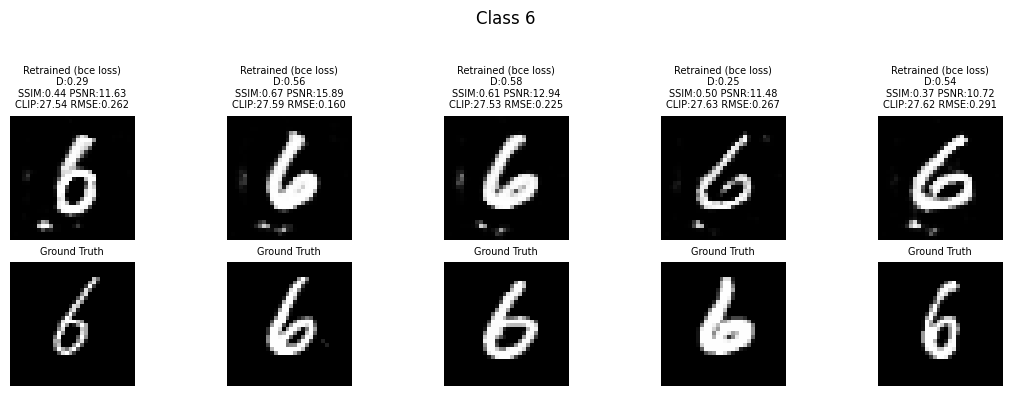

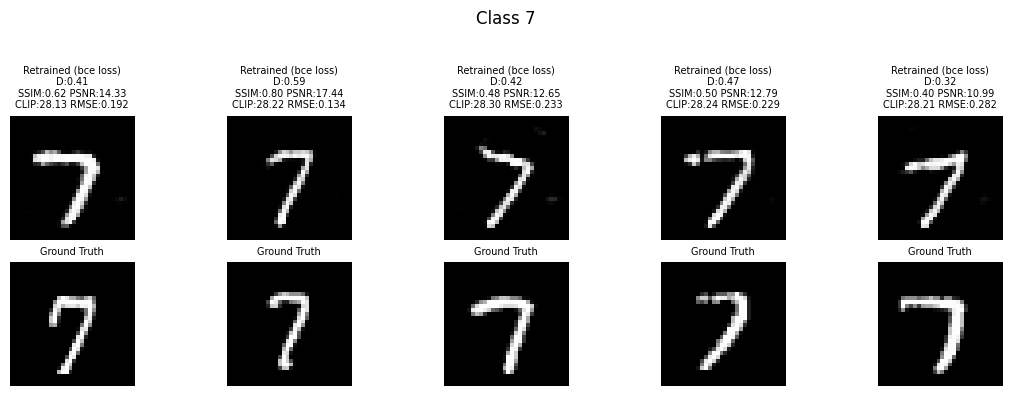

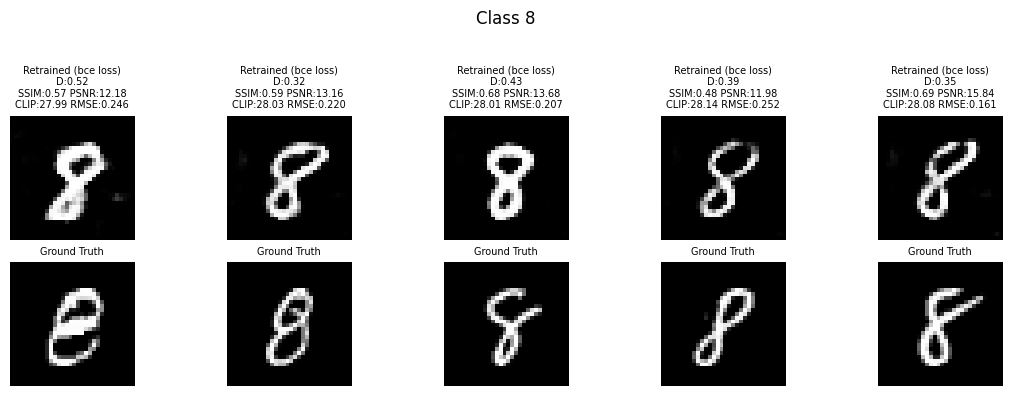

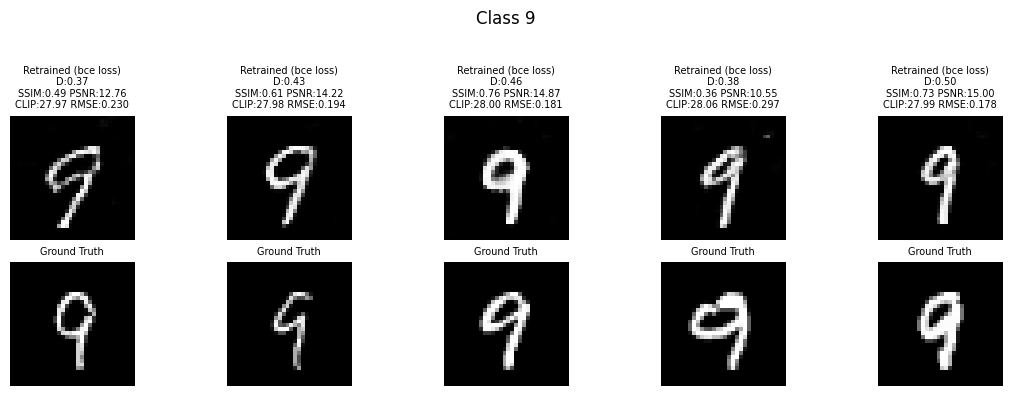


Per-Class Averages:
Class 0 - SSIM: 0.5623, PSNR: 12.32, CLIP: 27.7953, RMSE: 0.2465
Class 1 - SSIM: 0.7193, PSNR: 16.80, CLIP: 27.2357, RMSE: 0.1488
Class 2 - SSIM: 0.4304, PSNR: 11.77, CLIP: 27.0457, RMSE: 0.2604
Class 3 - SSIM: 0.5432, PSNR: 12.71, CLIP: 27.3150, RMSE: 0.2333
Class 4 - SSIM: 0.4939, PSNR: 12.75, CLIP: 26.8544, RMSE: 0.2330
Class 5 - SSIM: 0.4728, PSNR: 12.26, CLIP: 26.3708, RMSE: 0.2463
Class 6 - SSIM: 0.4767, PSNR: 12.34, CLIP: 27.5983, RMSE: 0.2451
Class 7 - SSIM: 0.6220, PSNR: 14.33, CLIP: 28.1702, RMSE: 0.1966
Class 8 - SSIM: 0.5398, PSNR: 12.37, CLIP: 28.0361, RMSE: 0.2442
Class 9 - SSIM: 0.6044, PSNR: 13.35, CLIP: 27.9825, RMSE: 0.2188

Calculating Inception Score and FID...
Inception Score: 1.93 ± 0.11
FID Score: 37.34
--------------------------------------- END --------------------------------------- 
------------------------ EVALUATING MODELS OF perceptual ------------------------ 
Models of perceptual loss loaded successfully!
Evaluating per-class generat

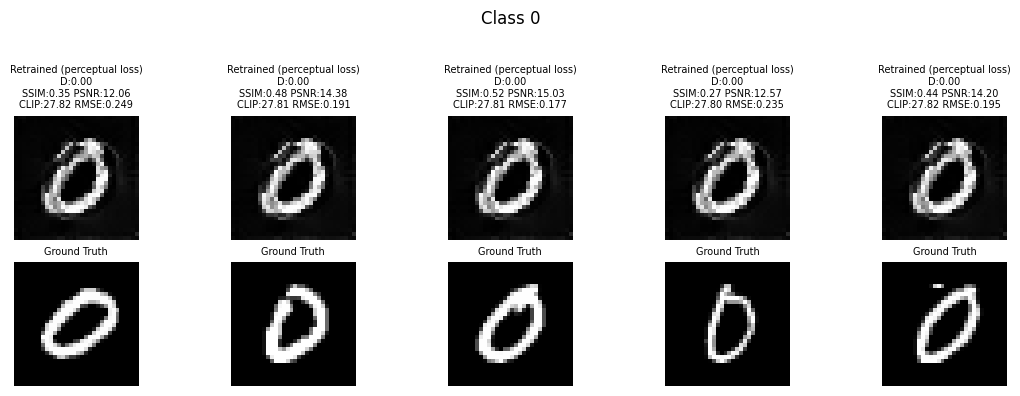

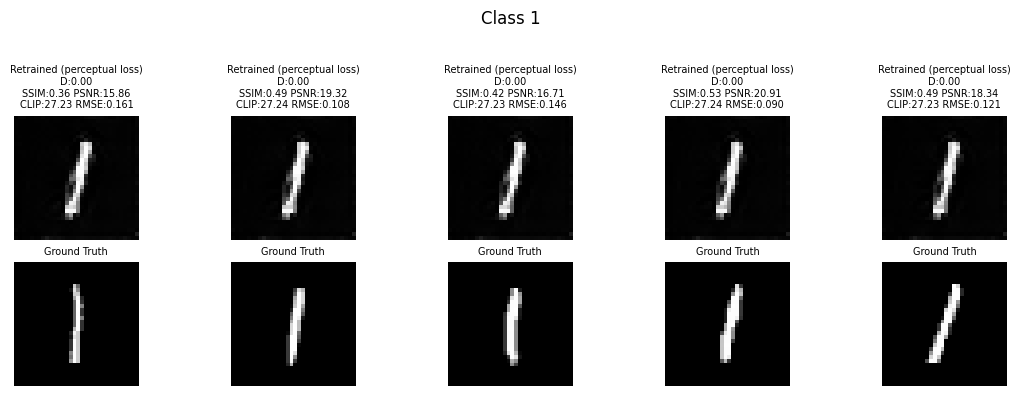

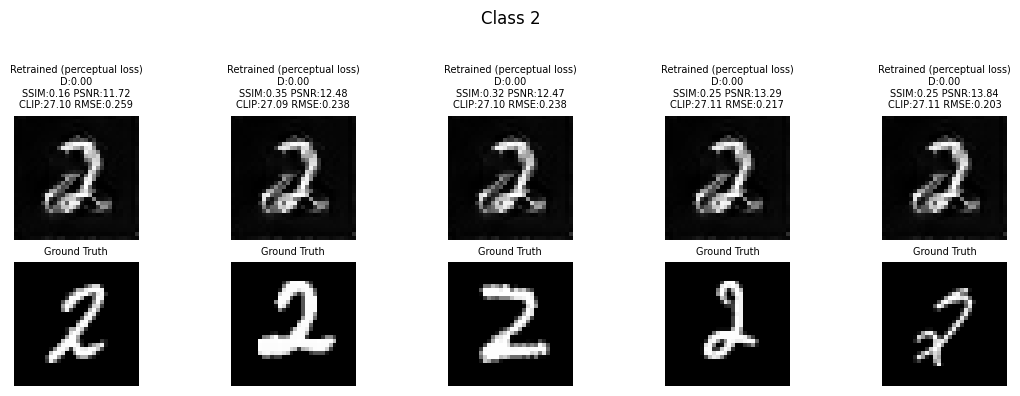

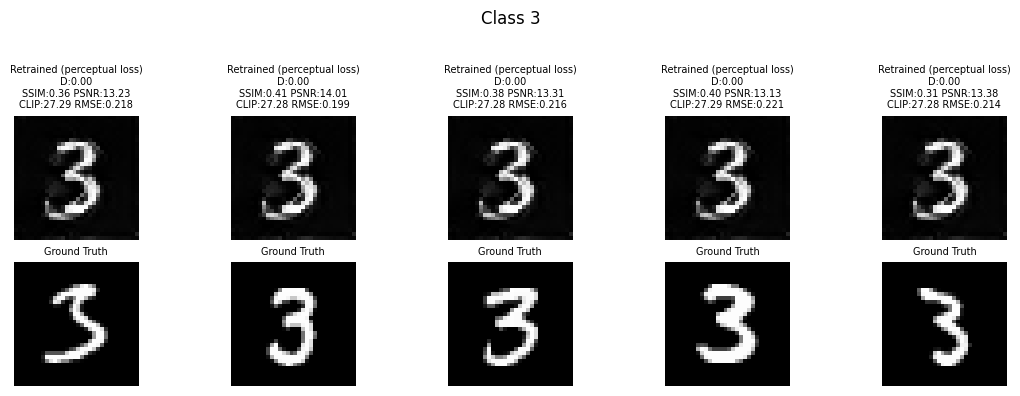

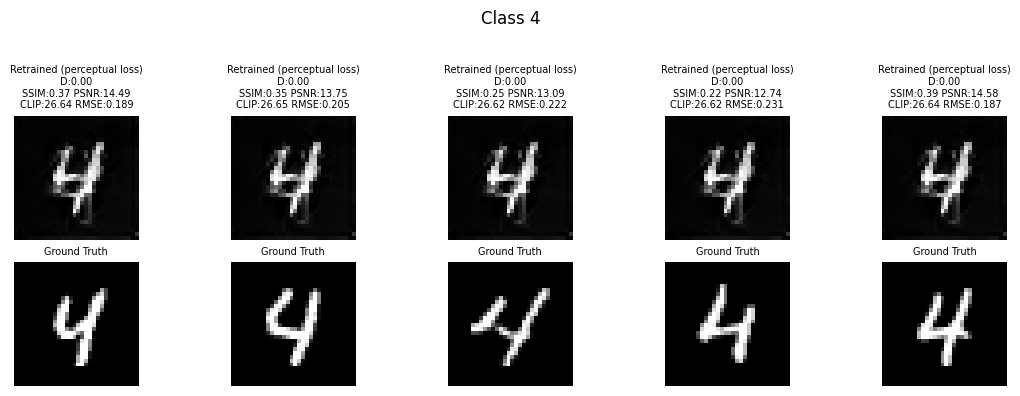

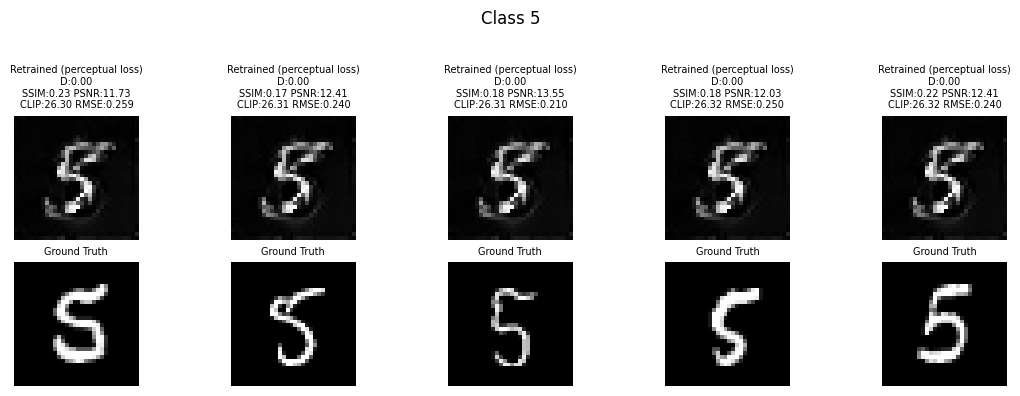

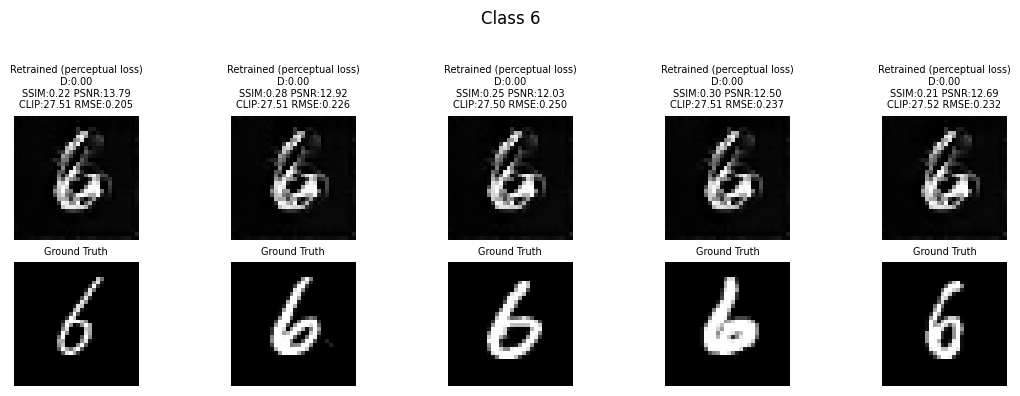

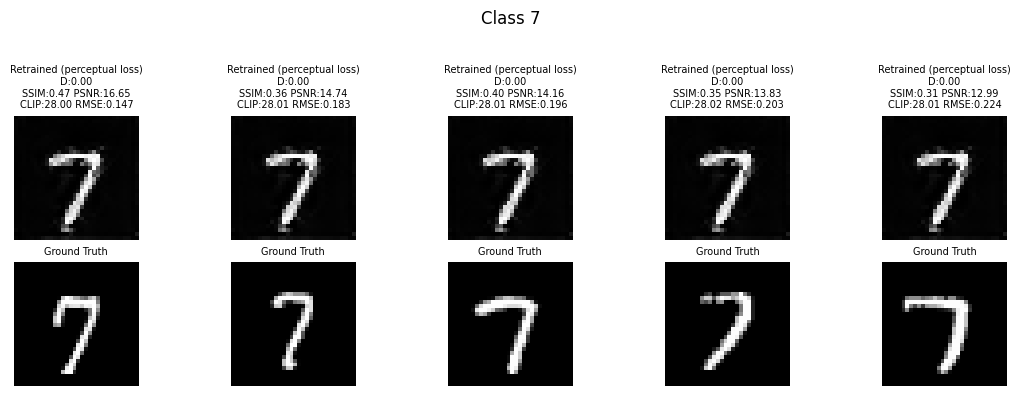

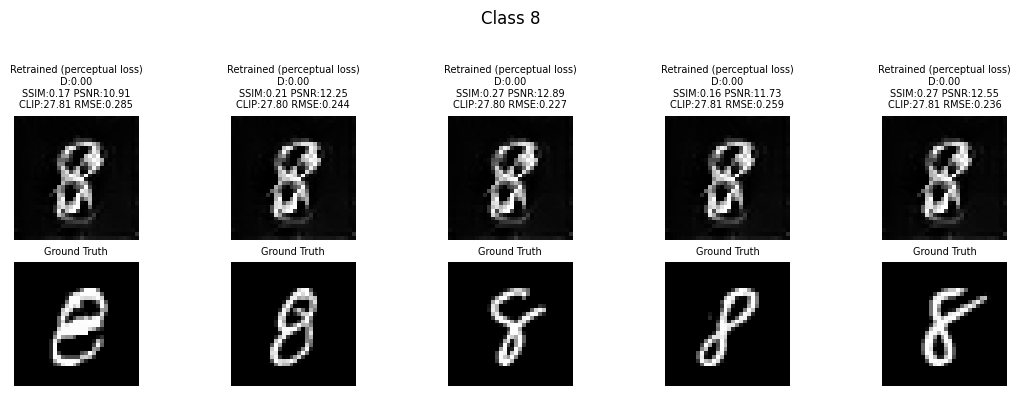

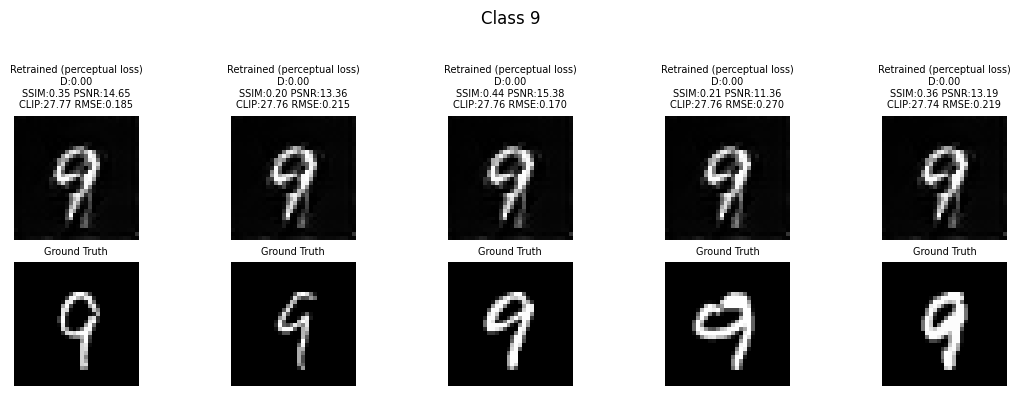


Per-Class Averages:
Class 0 - SSIM: 0.3907, PSNR: 12.81, CLIP: 27.8039, RMSE: 0.2312
Class 1 - SSIM: 0.4451, PSNR: 17.47, CLIP: 27.2370, RMSE: 0.1378
Class 2 - SSIM: 0.2429, PSNR: 12.55, CLIP: 27.0980, RMSE: 0.2366
Class 3 - SSIM: 0.3521, PSNR: 13.52, CLIP: 27.2814, RMSE: 0.2125
Class 4 - SSIM: 0.2649, PSNR: 13.48, CLIP: 26.6398, RMSE: 0.2129
Class 5 - SSIM: 0.1893, PSNR: 12.54, CLIP: 26.3105, RMSE: 0.2371
Class 6 - SSIM: 0.2285, PSNR: 12.48, CLIP: 27.5082, RMSE: 0.2383
Class 7 - SSIM: 0.4238, PSNR: 15.50, CLIP: 28.0063, RMSE: 0.1702
Class 8 - SSIM: 0.2496, PSNR: 12.28, CLIP: 27.8056, RMSE: 0.2437
Class 9 - SSIM: 0.3449, PSNR: 13.96, CLIP: 27.7543, RMSE: 0.2015

Calculating Inception Score and FID...
Inception Score: 1.98 ± 0.06
FID Score: 146.22
--------------------------------------- END --------------------------------------- 
------------------------ EVALUATING MODELS OF adversarial ------------------------ 
Models of adversarial loss loaded successfully!
Evaluating per-class gene

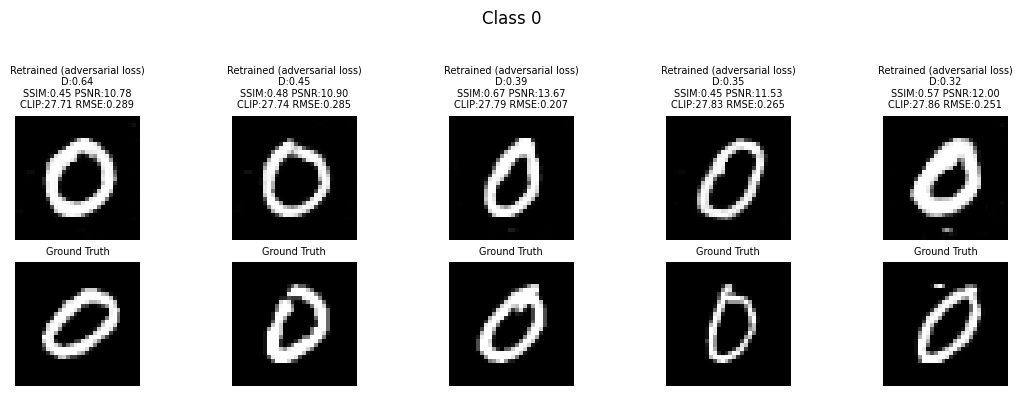

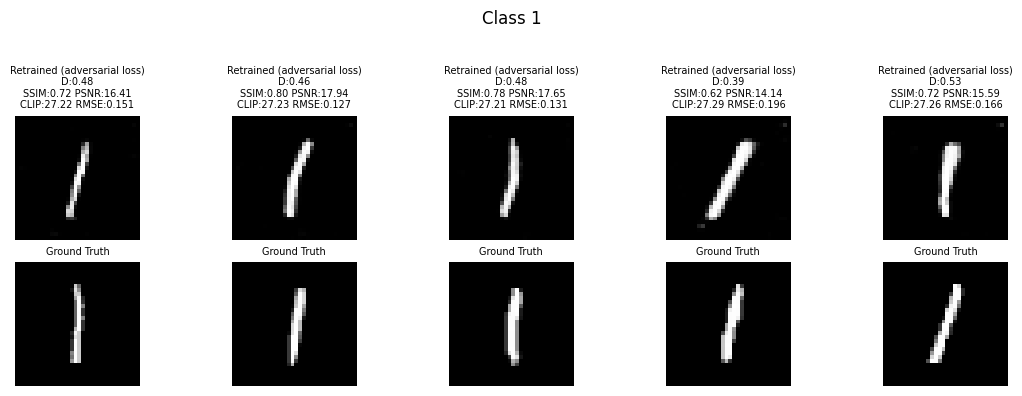

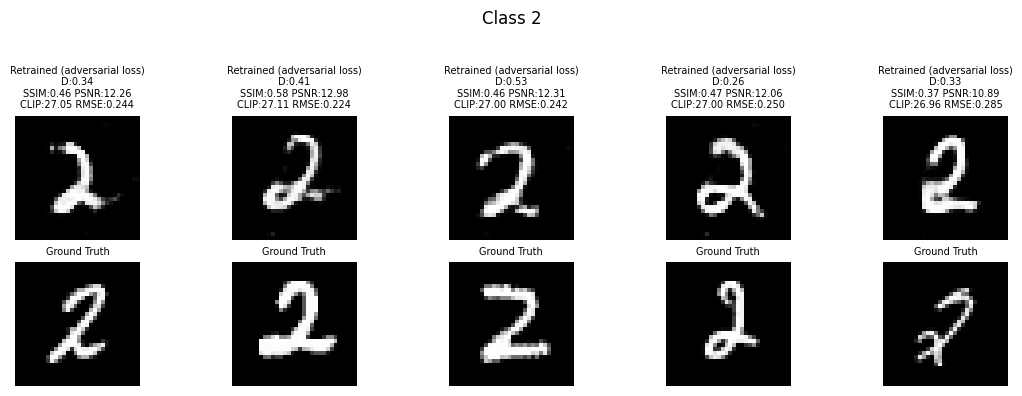

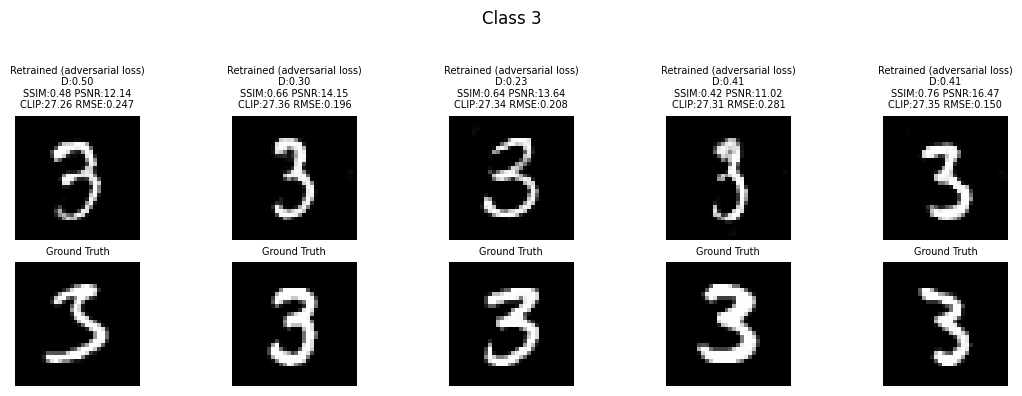

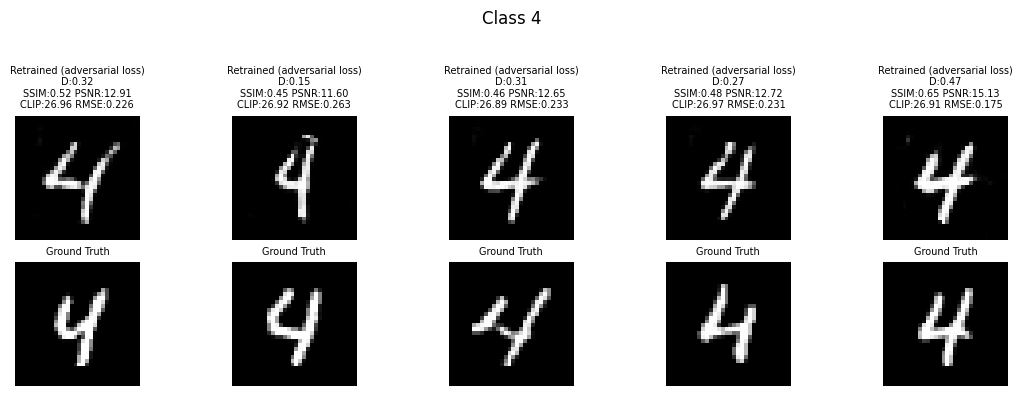

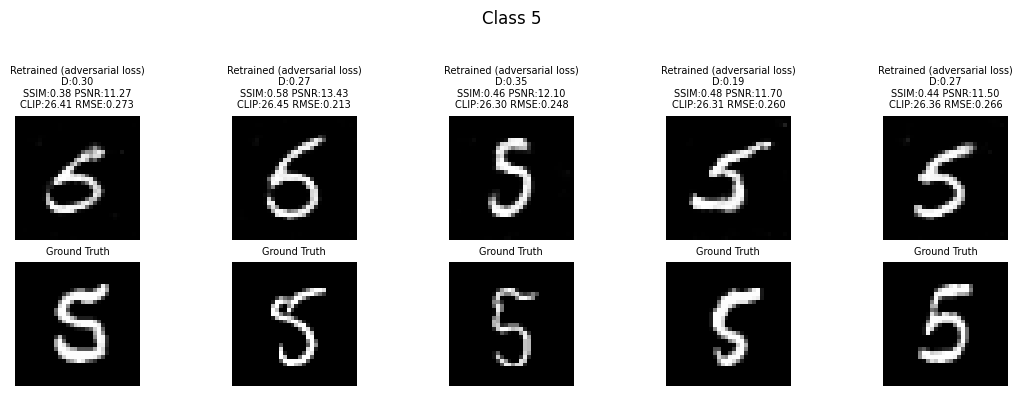

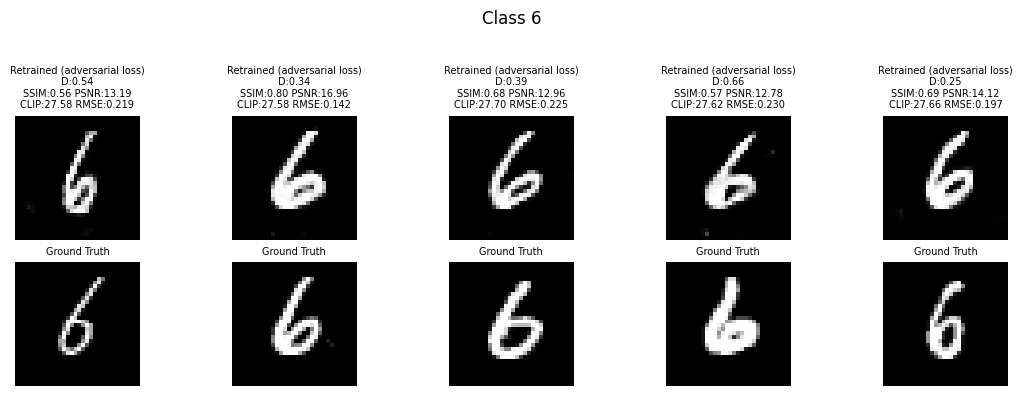

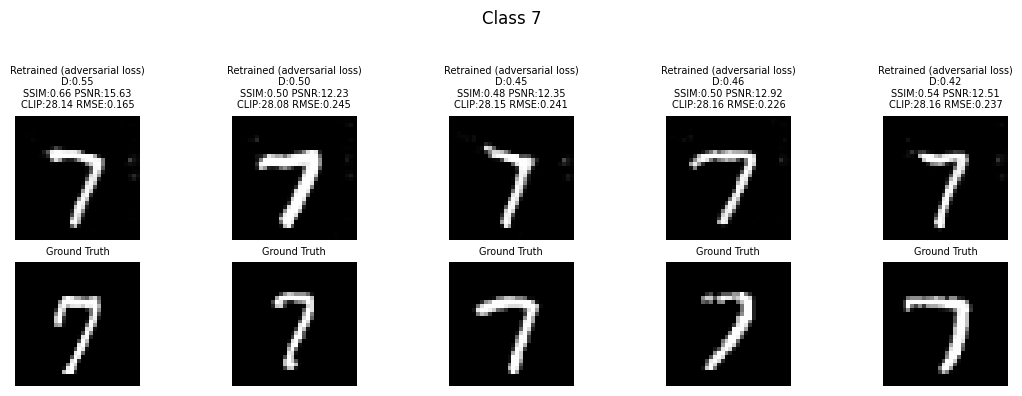

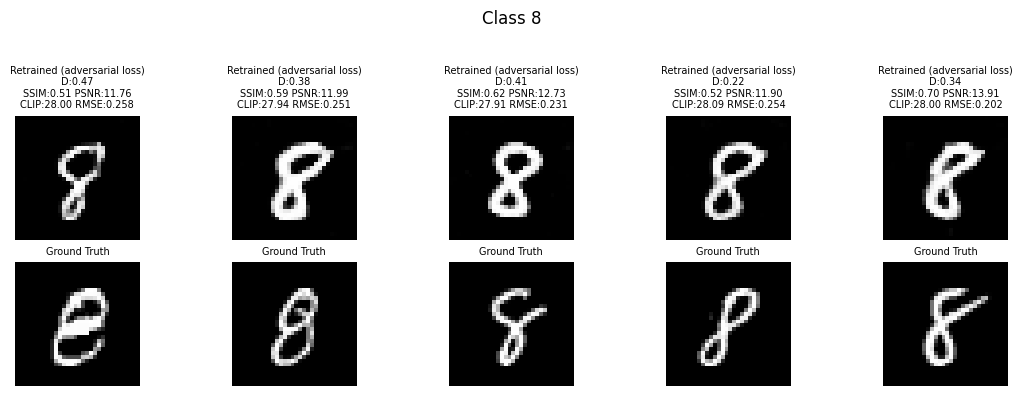

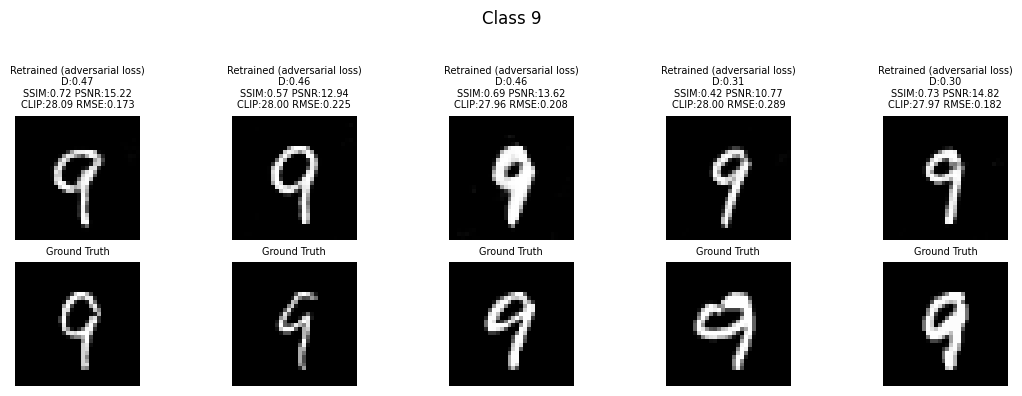


Per-Class Averages:
Class 0 - SSIM: 0.5859, PSNR: 12.57, CLIP: 27.8017, RMSE: 0.2398
Class 1 - SSIM: 0.7282, PSNR: 16.56, CLIP: 27.2408, RMSE: 0.1533
Class 2 - SSIM: 0.4478, PSNR: 11.77, CLIP: 27.0663, RMSE: 0.2602
Class 3 - SSIM: 0.5405, PSNR: 12.66, CLIP: 27.3079, RMSE: 0.2354
Class 4 - SSIM: 0.5012, PSNR: 12.91, CLIP: 26.8845, RMSE: 0.2287
Class 5 - SSIM: 0.4553, PSNR: 12.06, CLIP: 26.3848, RMSE: 0.2519
Class 6 - SSIM: 0.5678, PSNR: 12.83, CLIP: 27.6197, RMSE: 0.2323
Class 7 - SSIM: 0.6212, PSNR: 14.25, CLIP: 28.1336, RMSE: 0.1984
Class 8 - SSIM: 0.5743, PSNR: 12.50, CLIP: 28.0170, RMSE: 0.2398
Class 9 - SSIM: 0.6332, PSNR: 13.44, CLIP: 27.9521, RMSE: 0.2164

Calculating Inception Score and FID...
Inception Score: 2.06 ± 0.11
FID Score: 31.38
--------------------------------------- END --------------------------------------- 
------------------------ EVALUATING MODELS OF hybrid ------------------------ 
Models of hybrid loss loaded successfully!
Evaluating per-class generation with

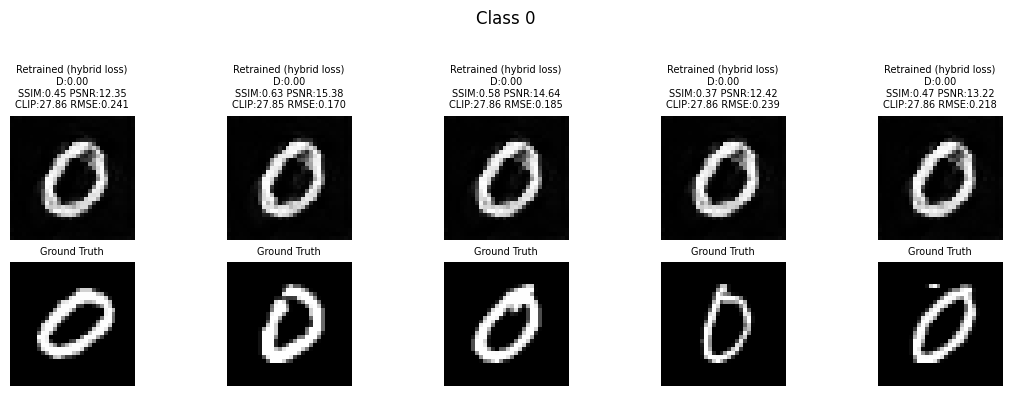

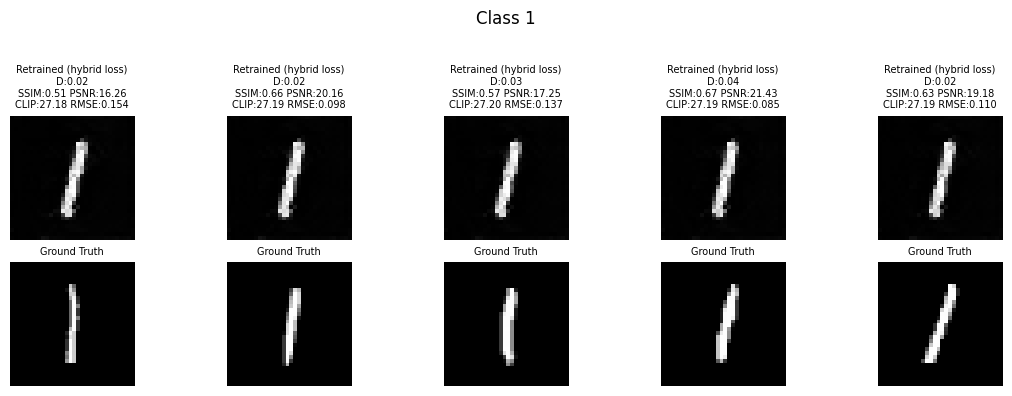

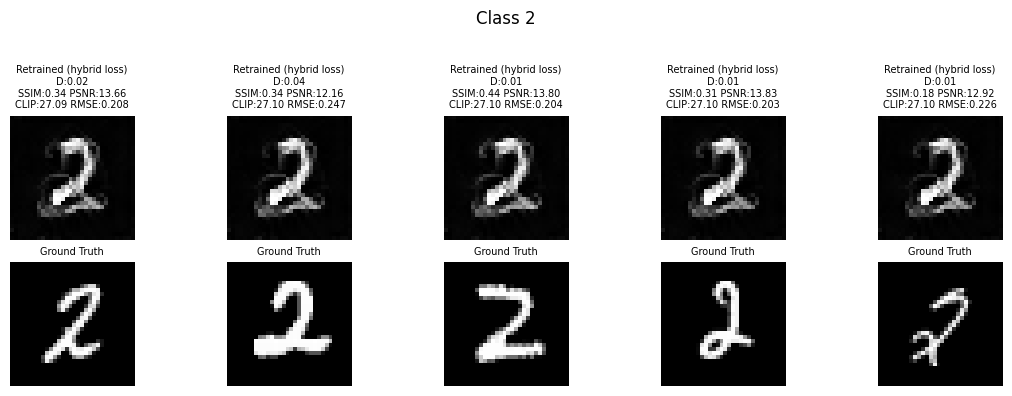

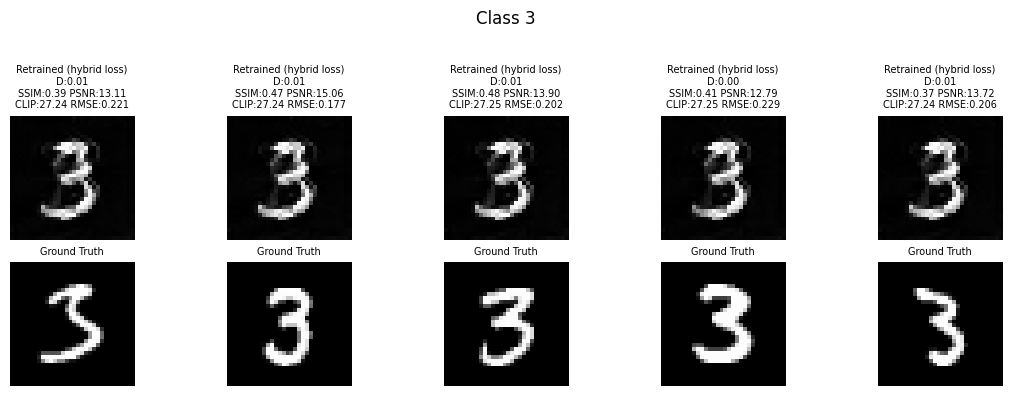

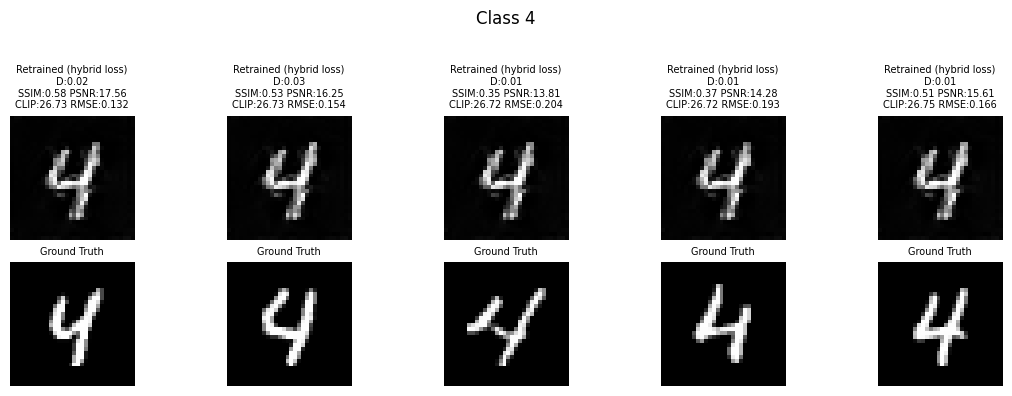

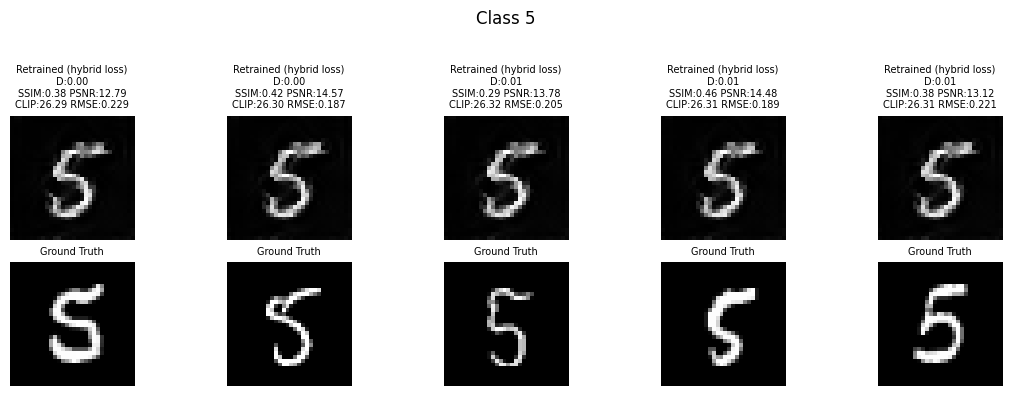

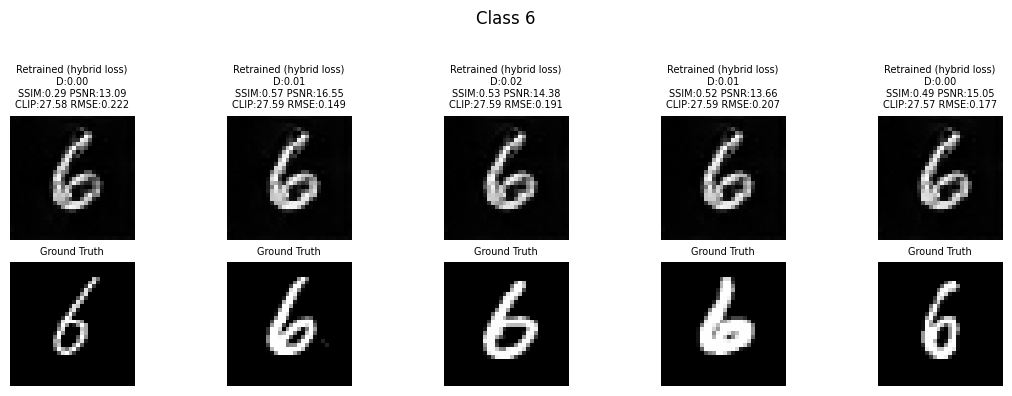

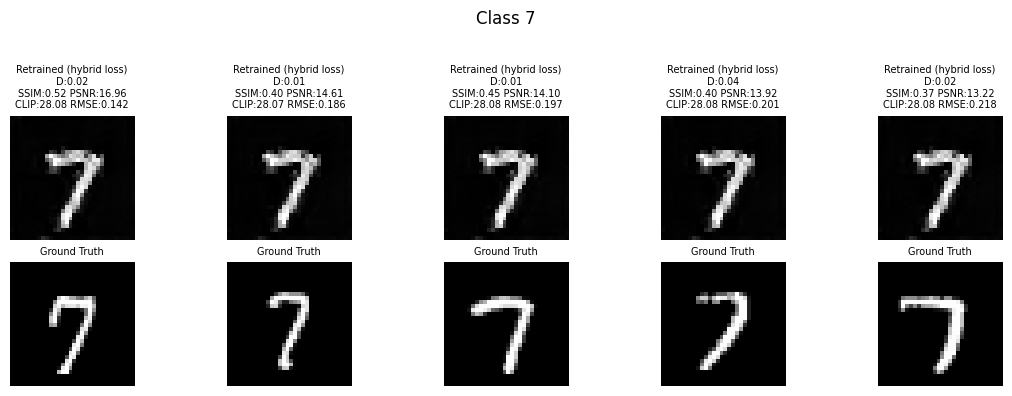

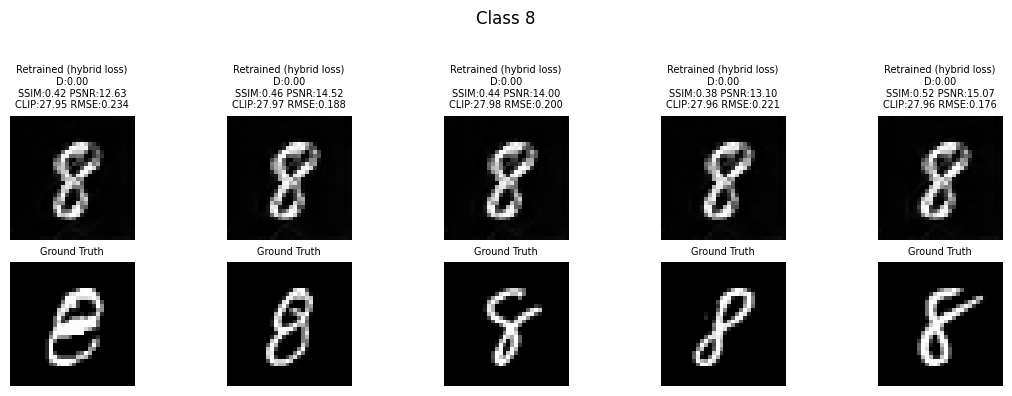

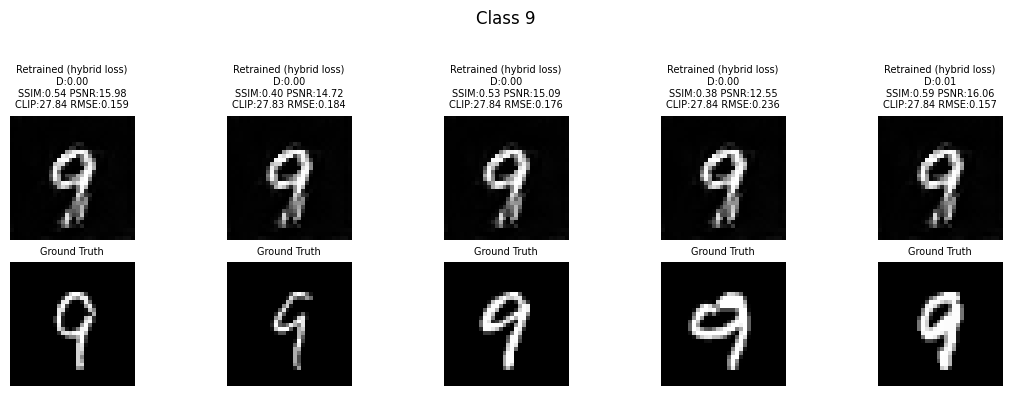


Per-Class Averages:
Class 0 - SSIM: 0.5483, PSNR: 14.08, CLIP: 27.8559, RMSE: 0.2008
Class 1 - SSIM: 0.5835, PSNR: 18.13, CLIP: 27.1876, RMSE: 0.1293
Class 2 - SSIM: 0.2880, PSNR: 13.07, CLIP: 27.1048, RMSE: 0.2236
Class 3 - SSIM: 0.4165, PSNR: 13.89, CLIP: 27.2405, RMSE: 0.2030
Class 4 - SSIM: 0.3749, PSNR: 14.16, CLIP: 26.7334, RMSE: 0.1977
Class 5 - SSIM: 0.3685, PSNR: 13.71, CLIP: 26.3019, RMSE: 0.2079
Class 6 - SSIM: 0.4655, PSNR: 14.38, CLIP: 27.5856, RMSE: 0.1932
Class 7 - SSIM: 0.4726, PSNR: 15.58, CLIP: 28.0687, RMSE: 0.1682
Class 8 - SSIM: 0.4685, PSNR: 14.16, CLIP: 27.9674, RMSE: 0.1980
Class 9 - SSIM: 0.4819, PSNR: 14.80, CLIP: 27.8416, RMSE: 0.1836

Calculating Inception Score and FID...
Inception Score: 1.83 ± 0.07
FID Score: 97.17
--------------------------------------- END --------------------------------------- 


In [98]:
import torch
import os

loss_types = ['mse', 'bce', 'perceptual', 'adversarial', 'hybrid']

for loss_type in loss_types:
    print(f"------------------------ EVALUATING MODELS OF {loss_type} ------------------------ ")
    # Path ke model
    generator_path = f"/kaggle/working/MNIST_cDCGAN_results/{loss_type}/generator_param.pkl"
    discriminator_path = f"/kaggle/working/MNIST_cDCGAN_results/{loss_type}/discriminator_param.pkl"
    
    # Load model
    G = generator(128)
    D = discriminator(128)
    
    # Load parameter
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    G.load_state_dict(torch.load(generator_path, map_location=device))
    D.load_state_dict(torch.load(discriminator_path, map_location=device))
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    G.eval().to(device)
    D.eval().to(device)
    
    print(f"Models of {loss_type} loss loaded successfully!")

    evaluate_all(G, D, final_true_val_pairs[:500], device, 5)
    print(f"--------------------------------------- END --------------------------------------- ")

------------------------ EVALUATING MODELS OF mse ------------------------ 
Models of mse loss loaded successfully!
Evaluating per-class generation with metrics and visualization...


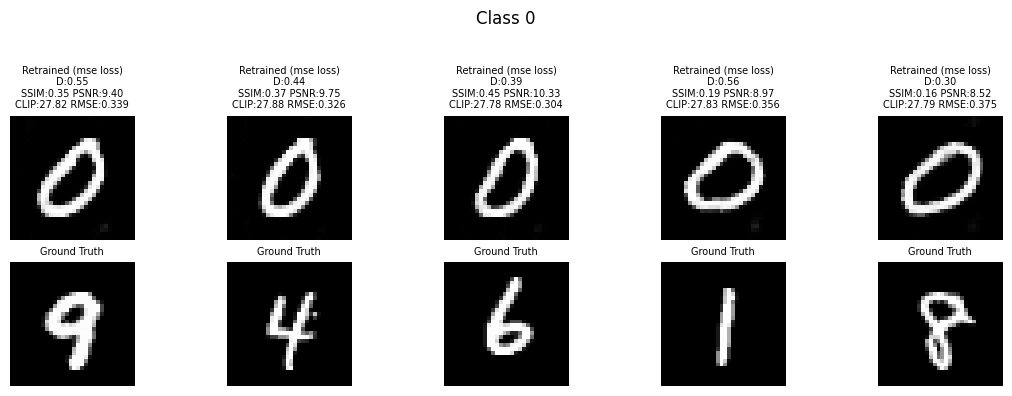

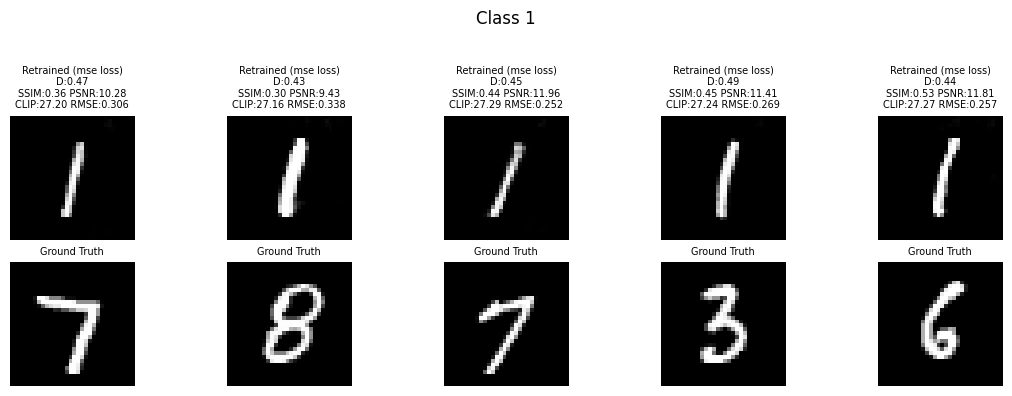

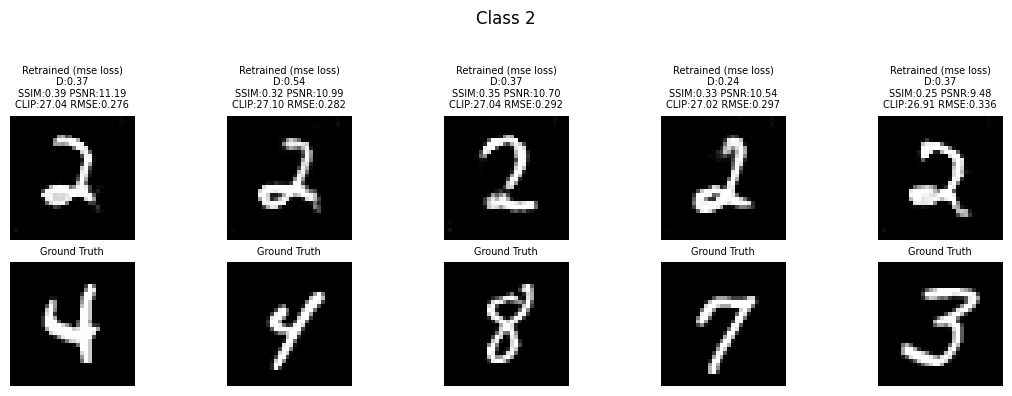

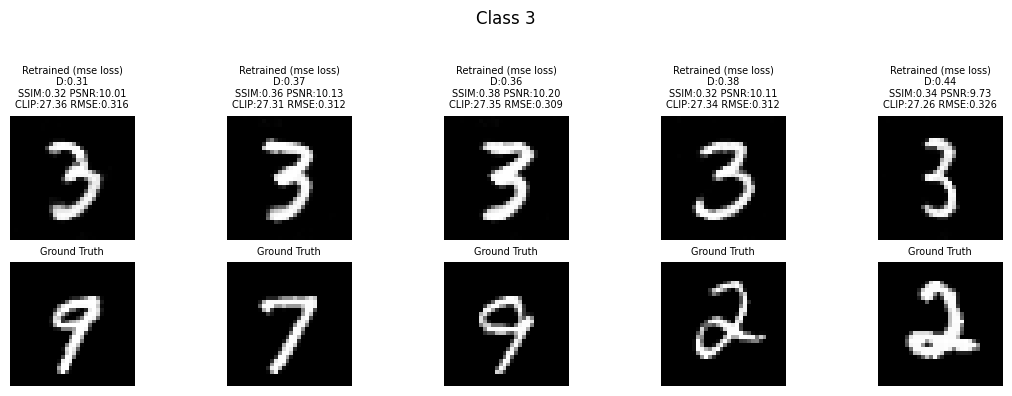

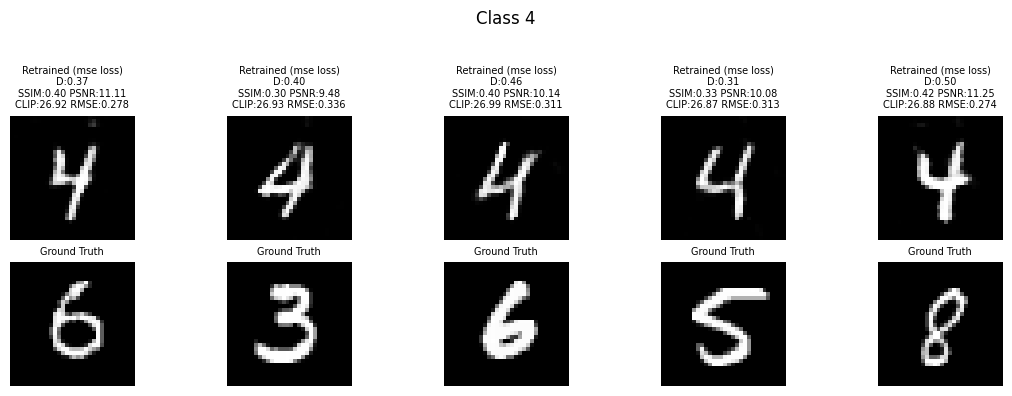

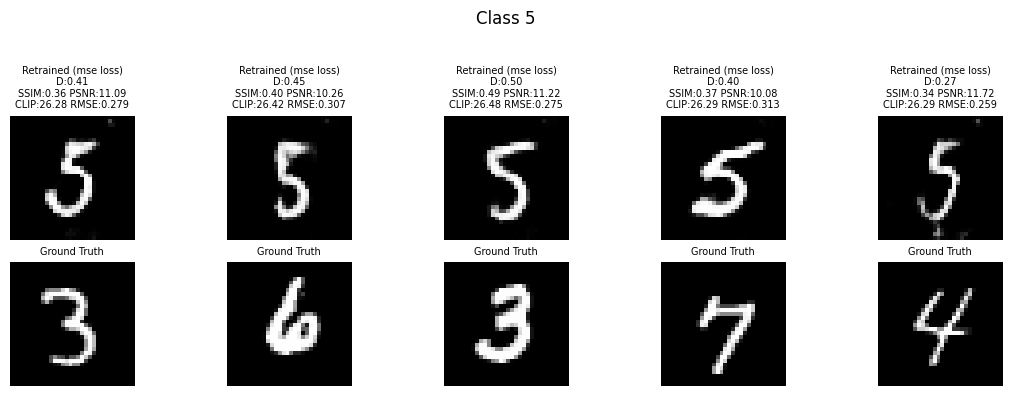

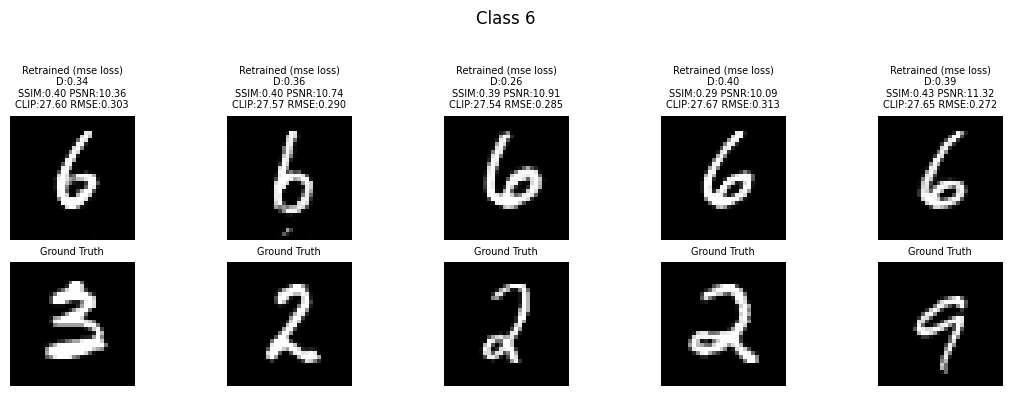

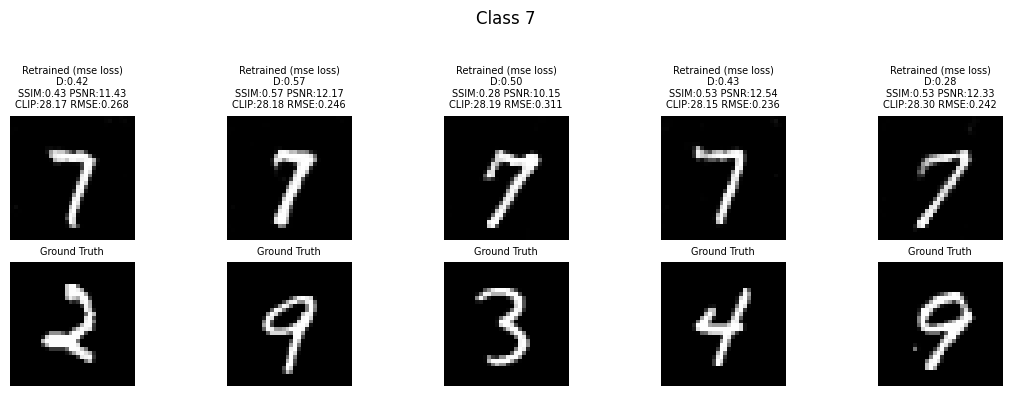

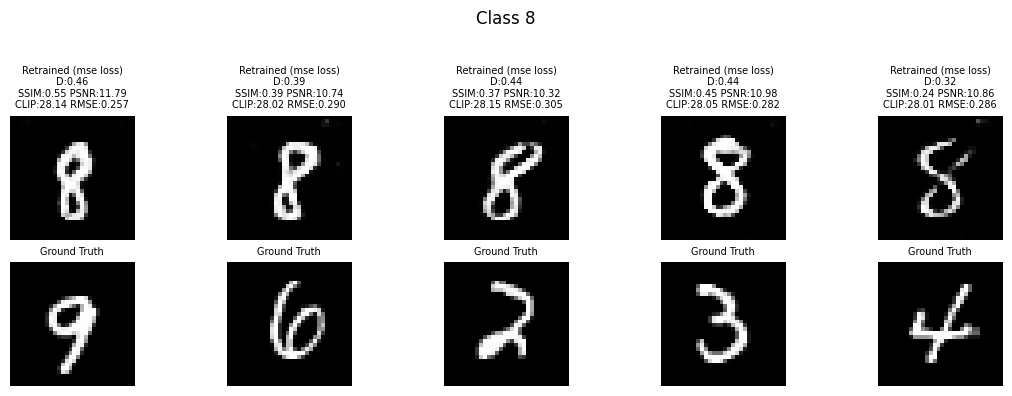

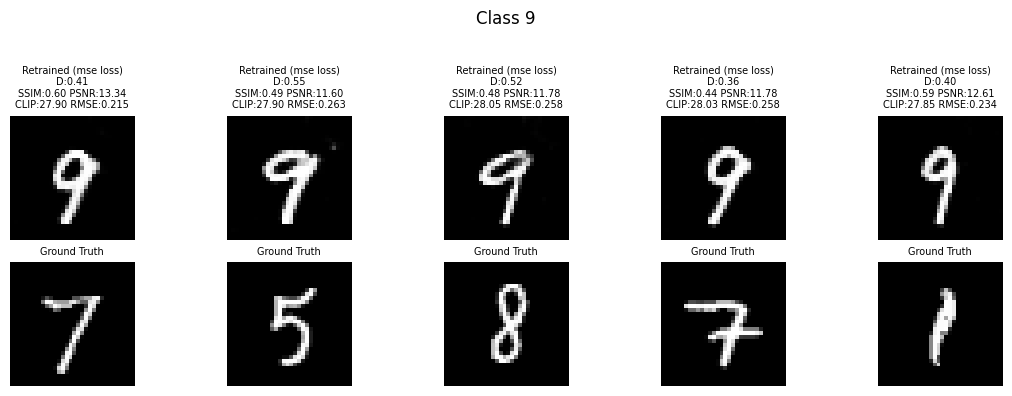


Per-Class Averages:
Class 0 - SSIM: 0.3171, PSNR: 9.55, CLIP: 27.8181, RMSE: 0.3349
Class 1 - SSIM: 0.4113, PSNR: 11.05, CLIP: 27.2560, RMSE: 0.2820
Class 2 - SSIM: 0.3252, PSNR: 10.42, CLIP: 27.0688, RMSE: 0.3032
Class 3 - SSIM: 0.3815, PSNR: 10.64, CLIP: 27.3135, RMSE: 0.2948
Class 4 - SSIM: 0.4032, PSNR: 11.05, CLIP: 26.8761, RMSE: 0.2823
Class 5 - SSIM: 0.4195, PSNR: 11.17, CLIP: 26.3954, RMSE: 0.2784
Class 6 - SSIM: 0.3785, PSNR: 10.53, CLIP: 27.6168, RMSE: 0.2991
Class 7 - SSIM: 0.4282, PSNR: 11.11, CLIP: 28.1680, RMSE: 0.2806
Class 8 - SSIM: 0.4059, PSNR: 10.89, CLIP: 28.0549, RMSE: 0.2869
Class 9 - SSIM: 0.4737, PSNR: 11.60, CLIP: 27.9743, RMSE: 0.2653

Calculating Inception Score and FID...
Inception Score: 1.92 ± 0.09
FID Score: 33.45
--------------------------------------- END --------------------------------------- 
------------------------ EVALUATING MODELS OF bce ------------------------ 
Models of bce loss loaded successfully!
Evaluating per-class generation with metric

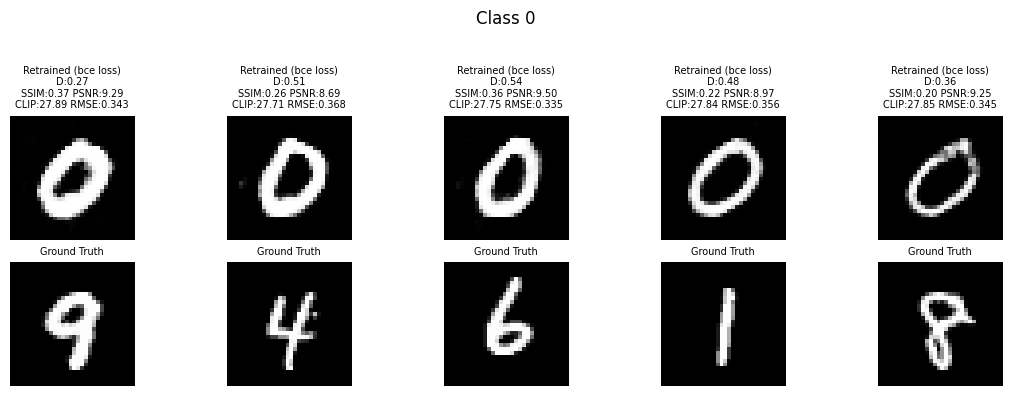

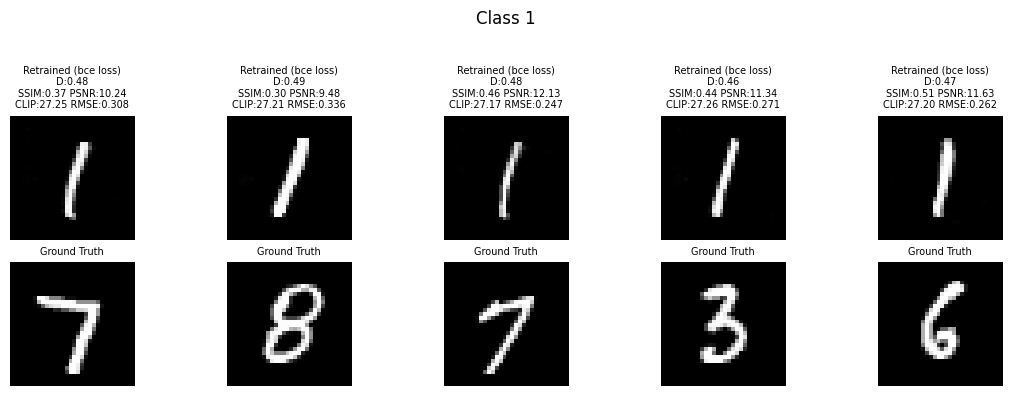

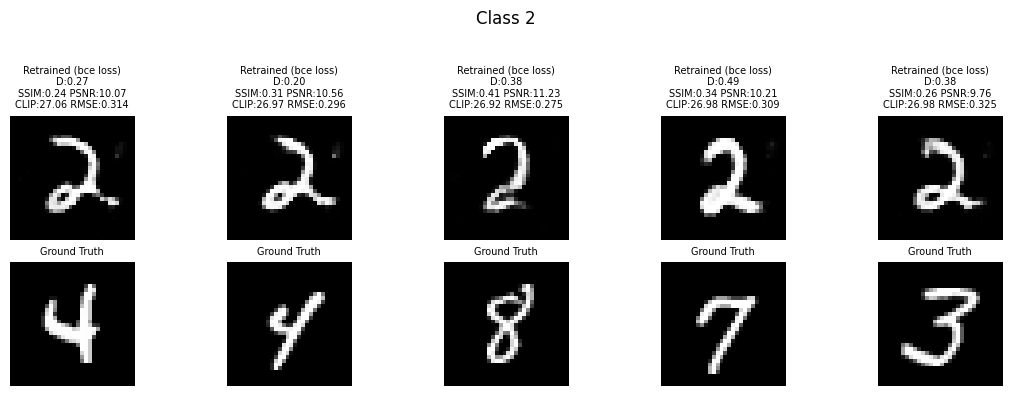

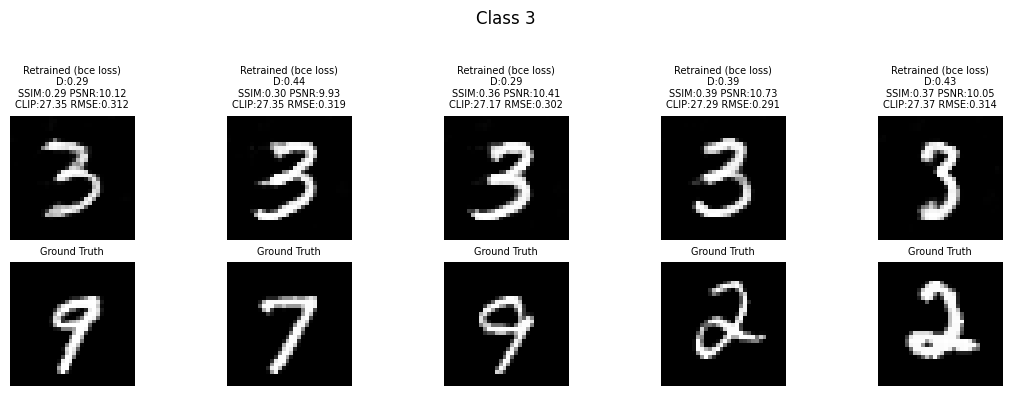

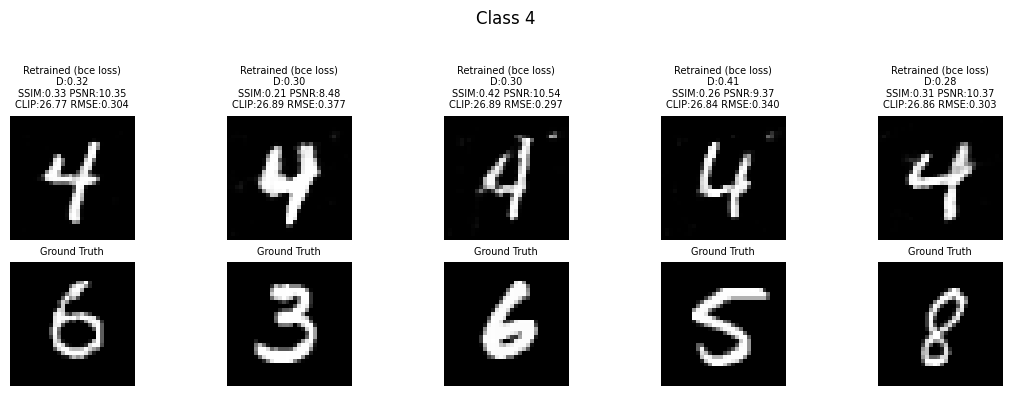

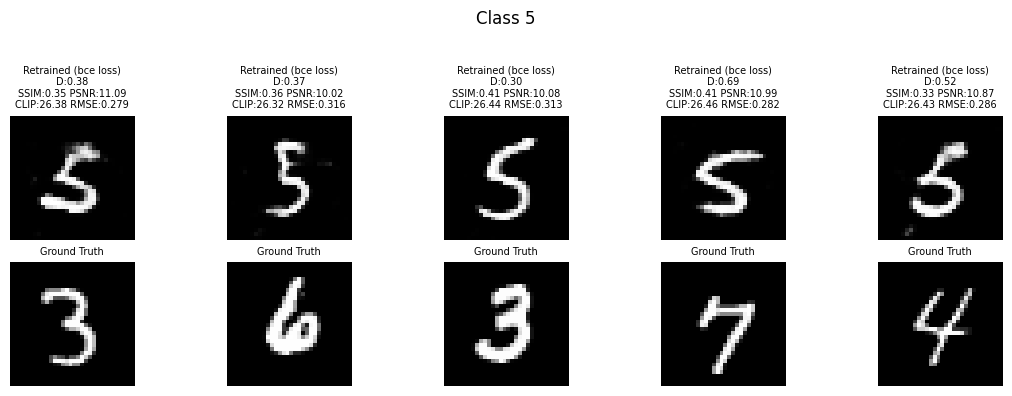

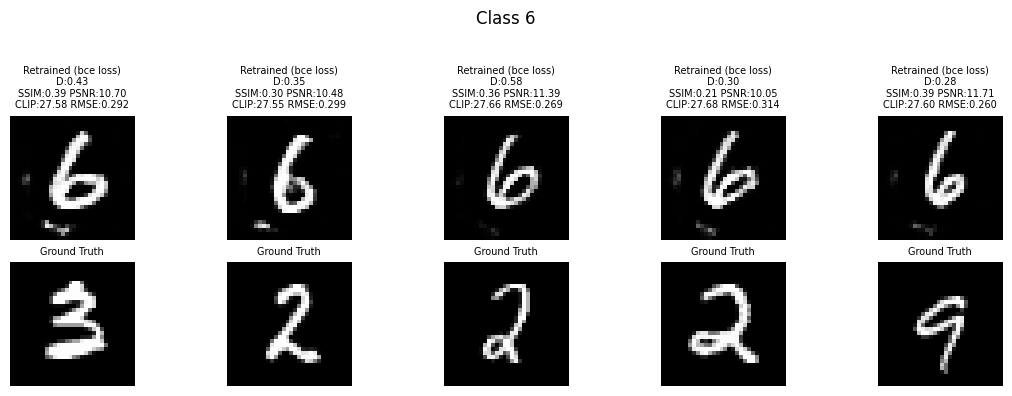

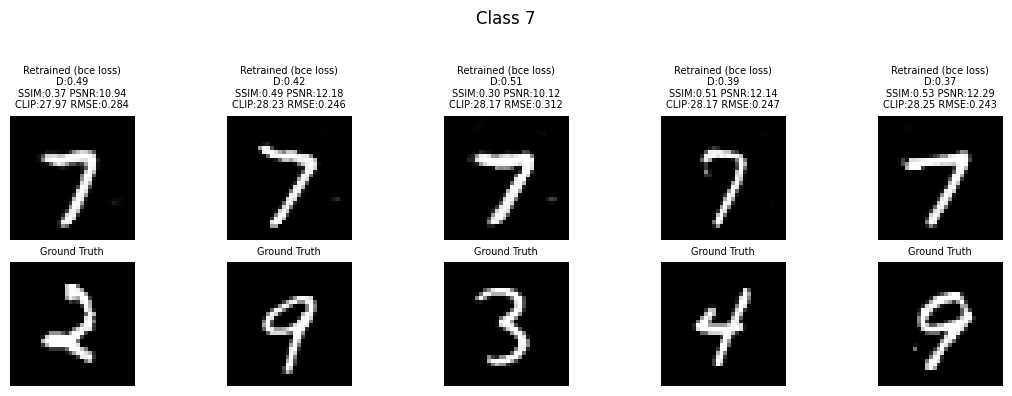

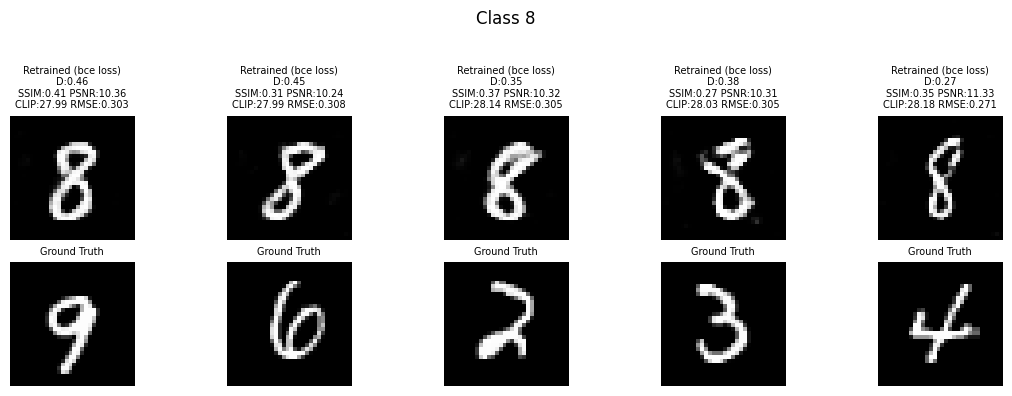

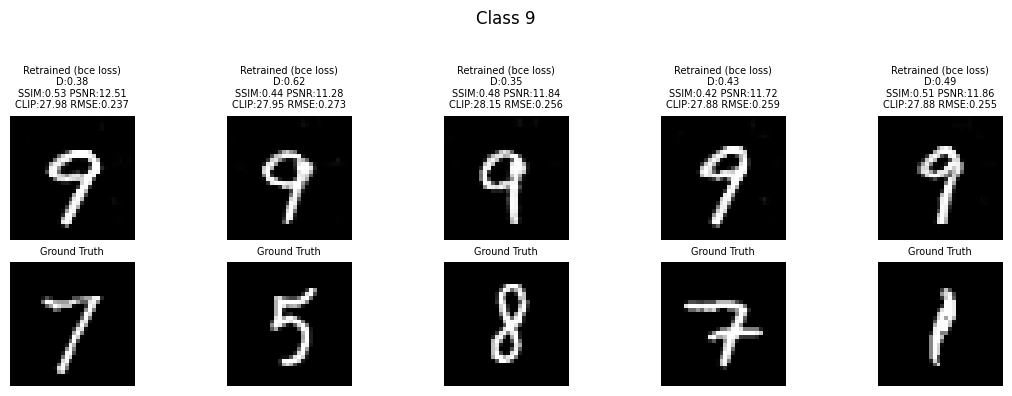


Per-Class Averages:
Class 0 - SSIM: 0.3222, PSNR: 9.61, CLIP: 27.8063, RMSE: 0.3327
Class 1 - SSIM: 0.4008, PSNR: 11.08, CLIP: 27.2366, RMSE: 0.2807
Class 2 - SSIM: 0.3069, PSNR: 10.35, CLIP: 27.0411, RMSE: 0.3054
Class 3 - SSIM: 0.3531, PSNR: 10.57, CLIP: 27.3085, RMSE: 0.2975
Class 4 - SSIM: 0.3901, PSNR: 11.02, CLIP: 26.8628, RMSE: 0.2839
Class 5 - SSIM: 0.3988, PSNR: 11.11, CLIP: 26.3906, RMSE: 0.2803
Class 6 - SSIM: 0.3122, PSNR: 10.40, CLIP: 27.6130, RMSE: 0.3037
Class 7 - SSIM: 0.3994, PSNR: 11.06, CLIP: 28.1399, RMSE: 0.2820
Class 8 - SSIM: 0.4007, PSNR: 10.80, CLIP: 28.0519, RMSE: 0.2901
Class 9 - SSIM: 0.4435, PSNR: 11.51, CLIP: 27.9997, RMSE: 0.2679

Calculating Inception Score and FID...
Inception Score: 2.00 ± 0.07
FID Score: 40.56
--------------------------------------- END --------------------------------------- 
------------------------ EVALUATING MODELS OF perceptual ------------------------ 
Models of perceptual loss loaded successfully!
Evaluating per-class generati

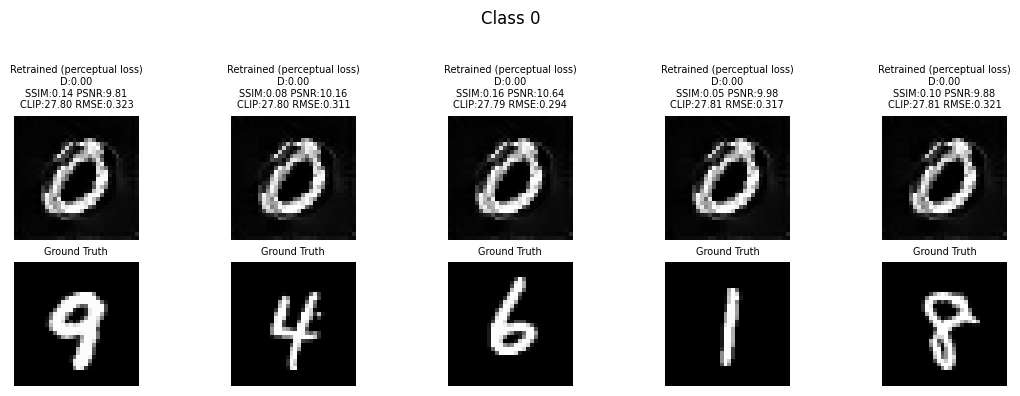

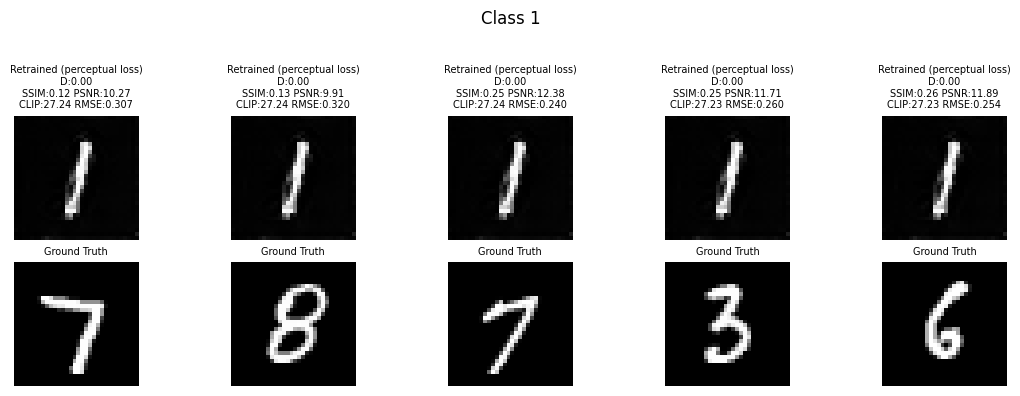

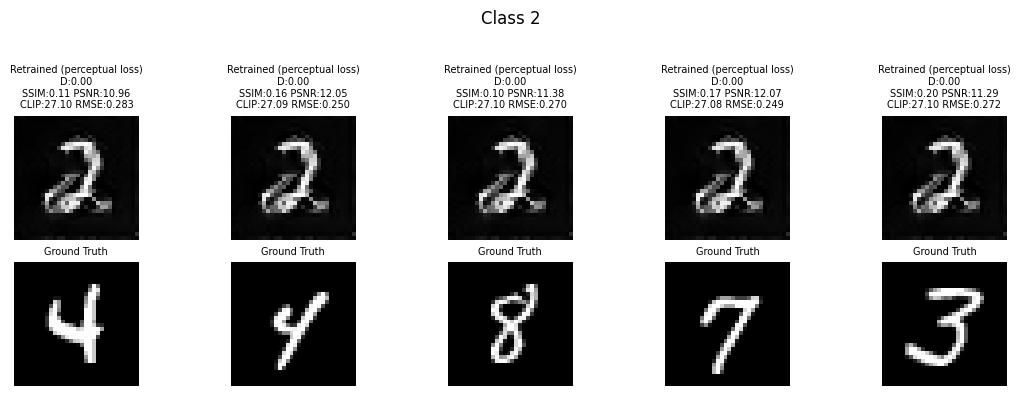

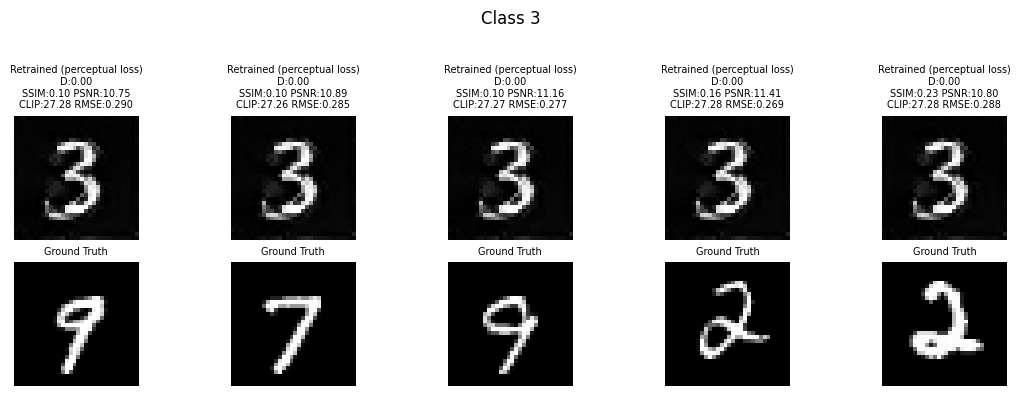

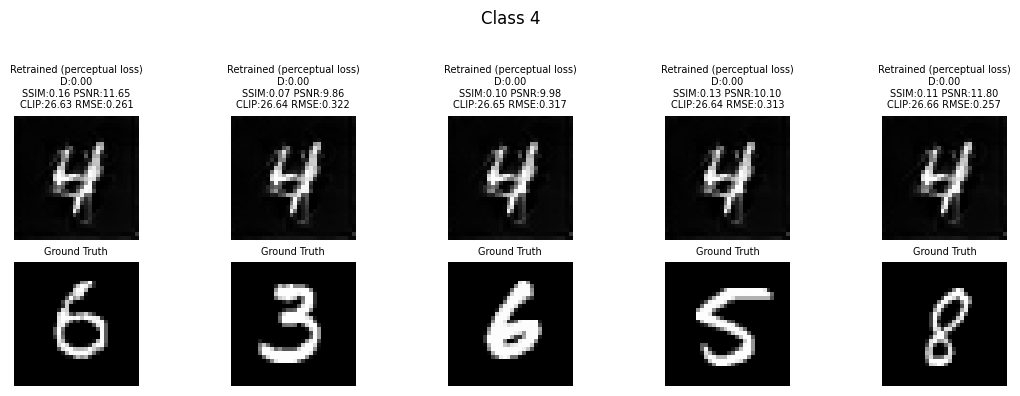

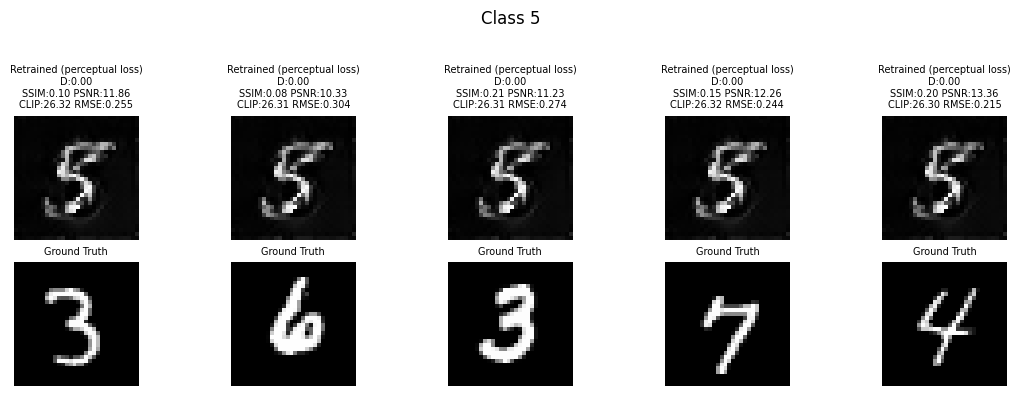

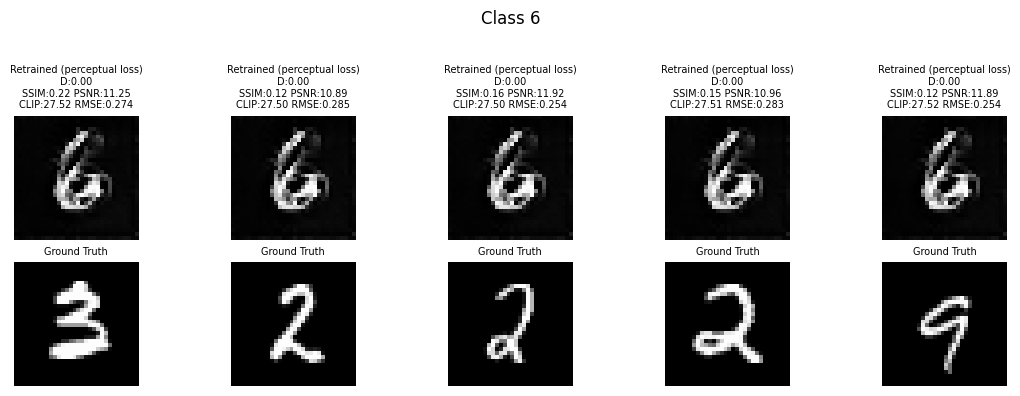

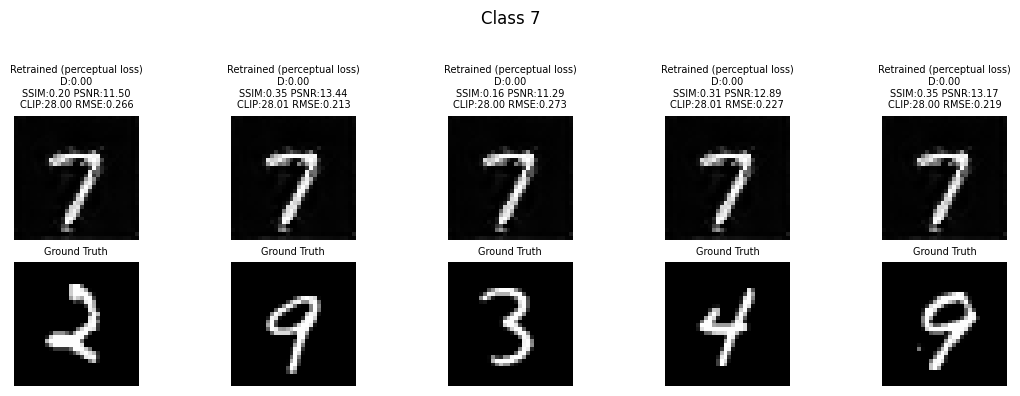

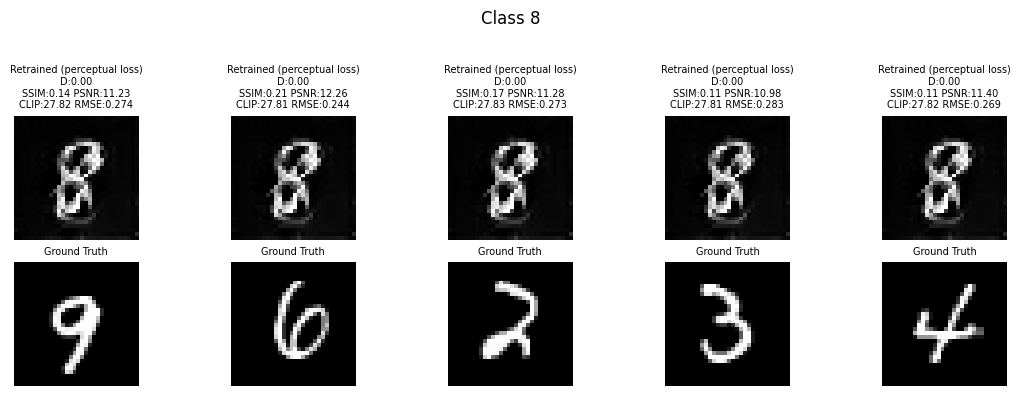

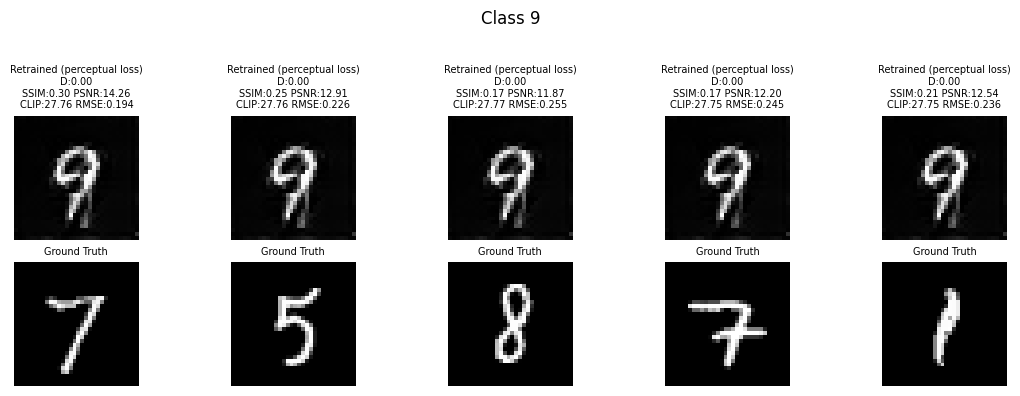


Per-Class Averages:
Class 0 - SSIM: 0.1201, PSNR: 10.35, CLIP: 27.8053, RMSE: 0.3044
Class 1 - SSIM: 0.2085, PSNR: 11.39, CLIP: 27.2367, RMSE: 0.2710
Class 2 - SSIM: 0.1147, PSNR: 11.44, CLIP: 27.0975, RMSE: 0.2693
Class 3 - SSIM: 0.1450, PSNR: 11.31, CLIP: 27.2811, RMSE: 0.2732
Class 4 - SSIM: 0.1586, PSNR: 11.82, CLIP: 26.6395, RMSE: 0.2588
Class 5 - SSIM: 0.1454, PSNR: 11.99, CLIP: 26.3120, RMSE: 0.2529
Class 6 - SSIM: 0.1030, PSNR: 11.05, CLIP: 27.5074, RMSE: 0.2815
Class 7 - SSIM: 0.2056, PSNR: 11.81, CLIP: 28.0040, RMSE: 0.2584
Class 8 - SSIM: 0.1409, PSNR: 11.51, CLIP: 27.8091, RMSE: 0.2669
Class 9 - SSIM: 0.2051, PSNR: 12.02, CLIP: 27.7541, RMSE: 0.2528

Calculating Inception Score and FID...
Inception Score: 1.92 ± 0.09
FID Score: 152.26
--------------------------------------- END --------------------------------------- 
------------------------ EVALUATING MODELS OF adversarial ------------------------ 
Models of adversarial loss loaded successfully!
Evaluating per-class gene

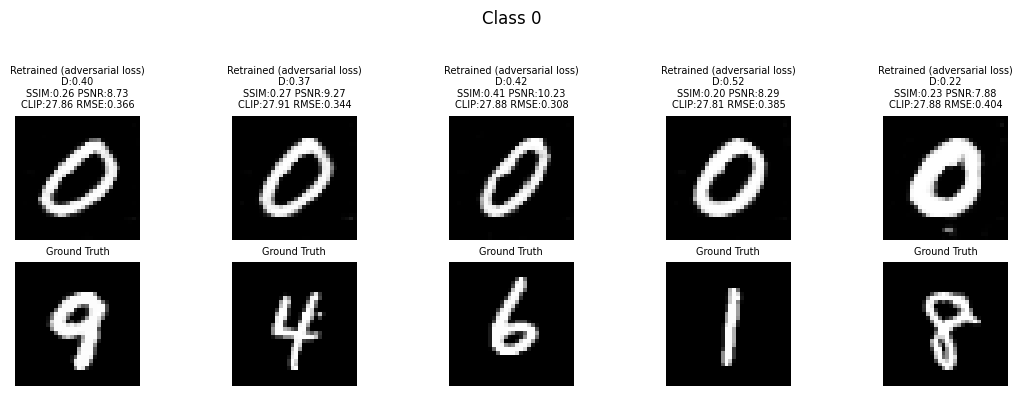

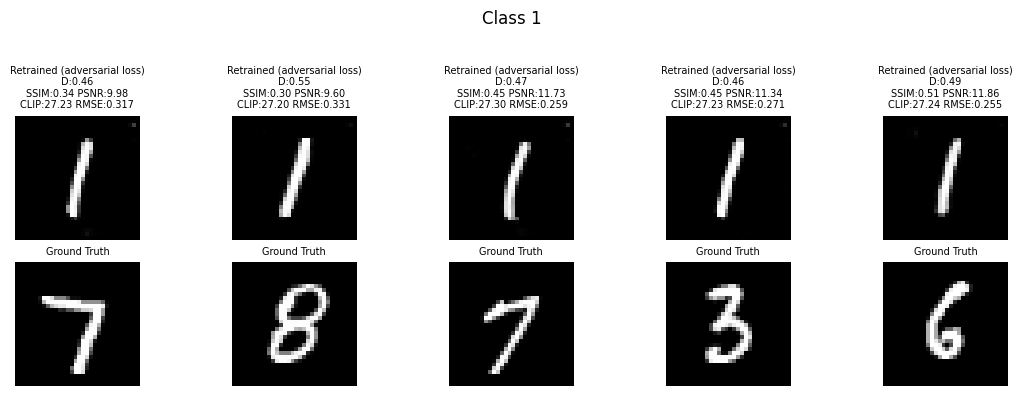

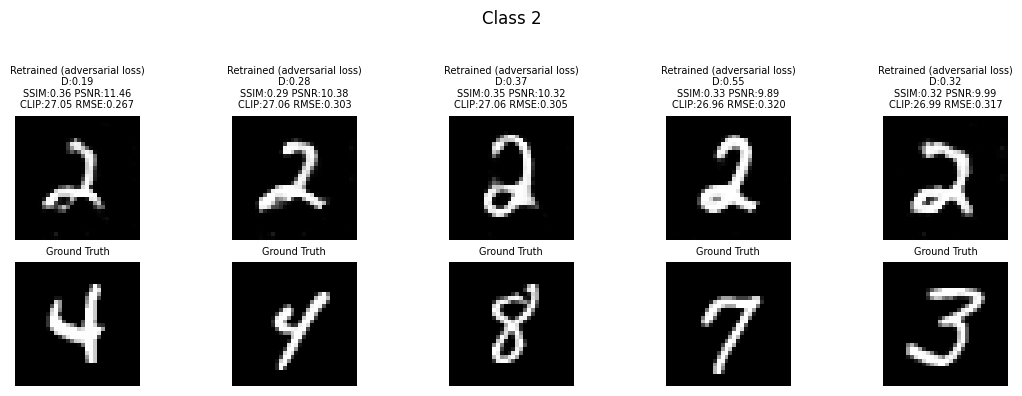

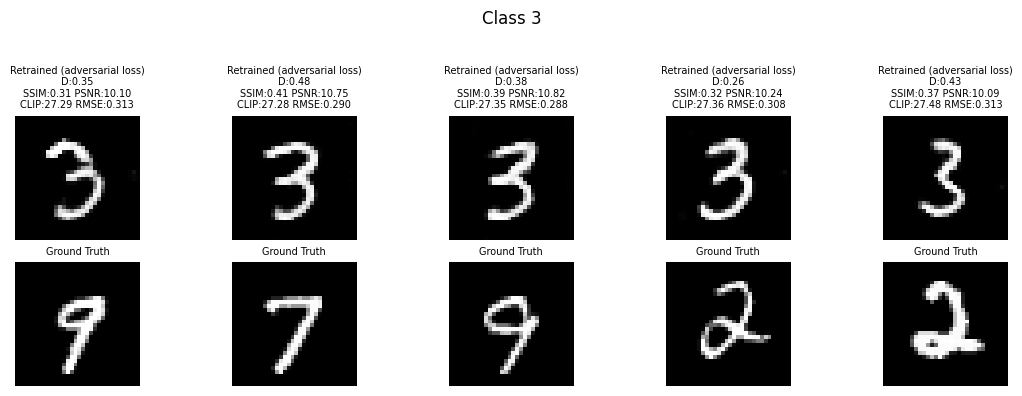

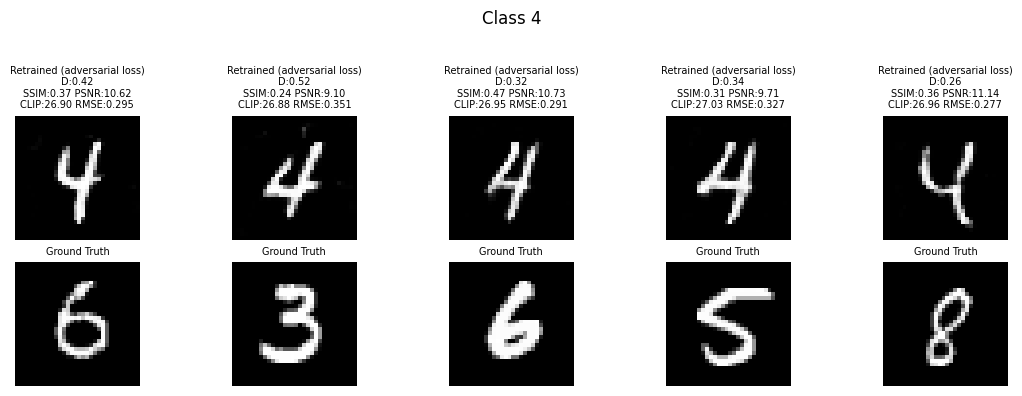

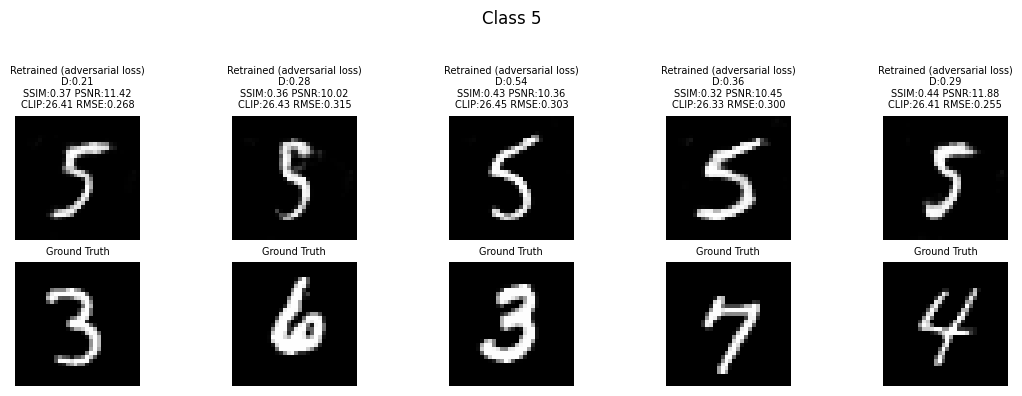

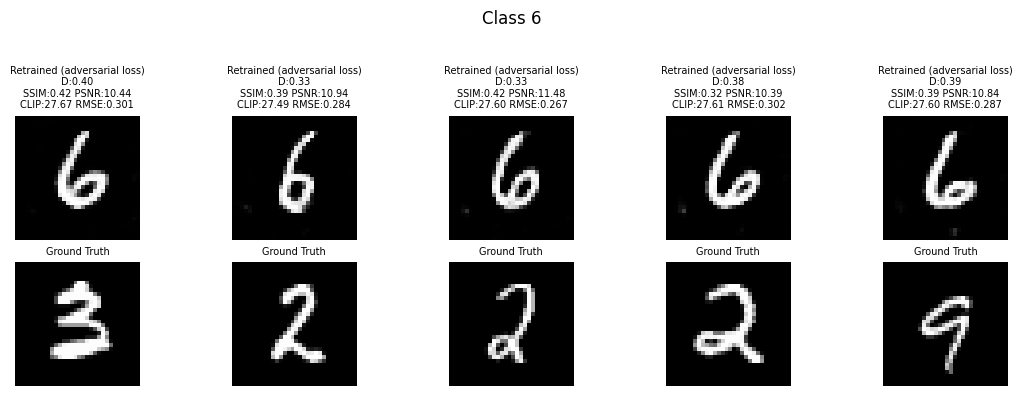

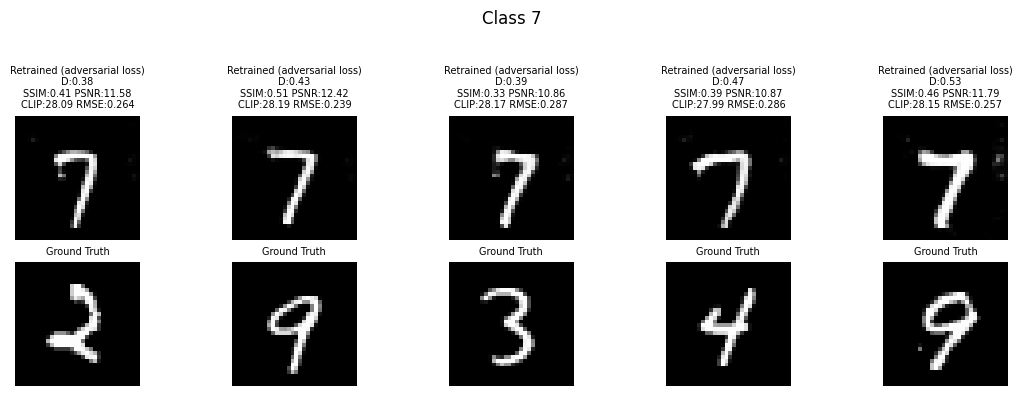

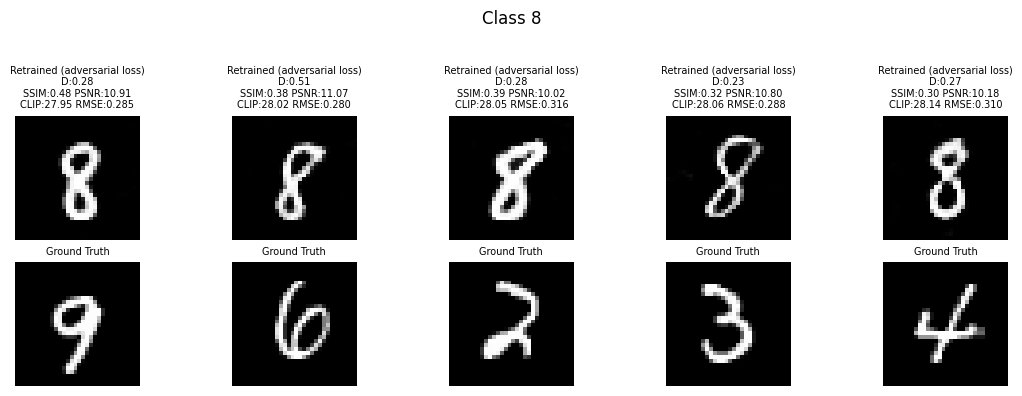

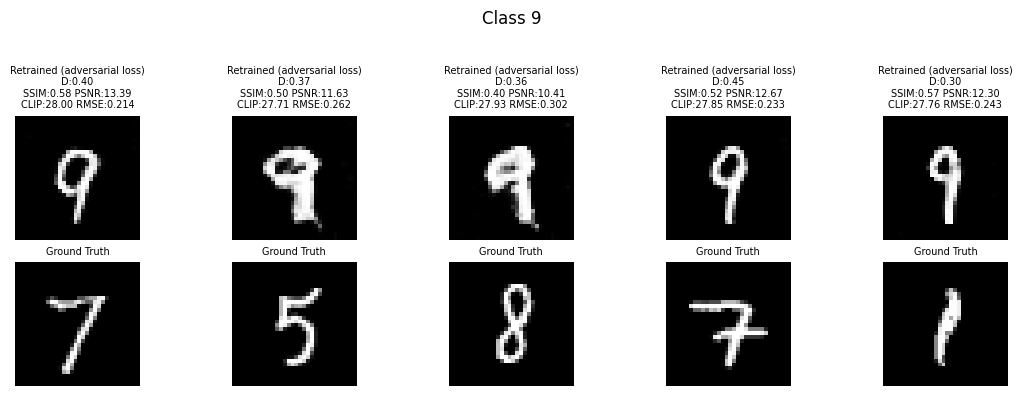


Per-Class Averages:
Class 0 - SSIM: 0.3122, PSNR: 9.37, CLIP: 27.7983, RMSE: 0.3418
Class 1 - SSIM: 0.4086, PSNR: 11.04, CLIP: 27.2333, RMSE: 0.2822
Class 2 - SSIM: 0.3169, PSNR: 10.28, CLIP: 27.0828, RMSE: 0.3083
Class 3 - SSIM: 0.3574, PSNR: 10.61, CLIP: 27.3212, RMSE: 0.2967
Class 4 - SSIM: 0.3930, PSNR: 11.11, CLIP: 26.8783, RMSE: 0.2802
Class 5 - SSIM: 0.4111, PSNR: 11.25, CLIP: 26.3898, RMSE: 0.2755
Class 6 - SSIM: 0.3660, PSNR: 10.48, CLIP: 27.6115, RMSE: 0.3005
Class 7 - SSIM: 0.3941, PSNR: 11.12, CLIP: 28.1479, RMSE: 0.2795
Class 8 - SSIM: 0.4073, PSNR: 10.71, CLIP: 28.0319, RMSE: 0.2927
Class 9 - SSIM: 0.4582, PSNR: 11.34, CLIP: 27.9442, RMSE: 0.2734

Calculating Inception Score and FID...
Inception Score: 2.07 ± 0.15
FID Score: 36.30
--------------------------------------- END --------------------------------------- 
------------------------ EVALUATING MODELS OF hybrid ------------------------ 
Models of hybrid loss loaded successfully!
Evaluating per-class generation with 

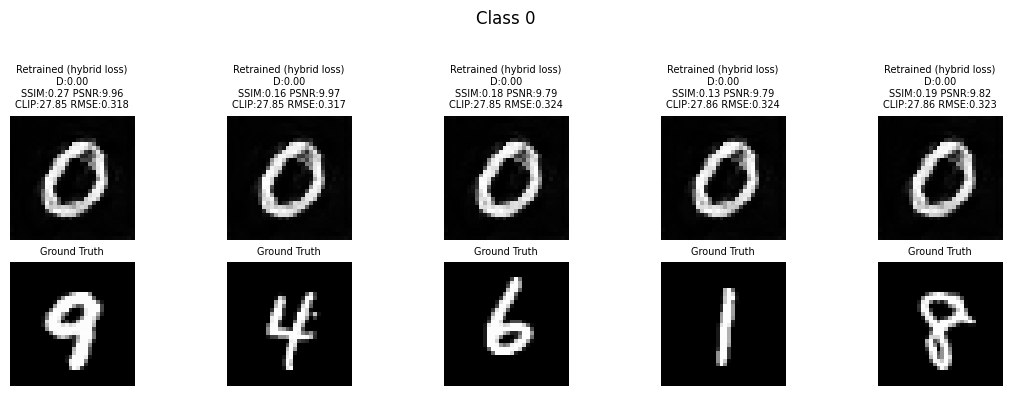

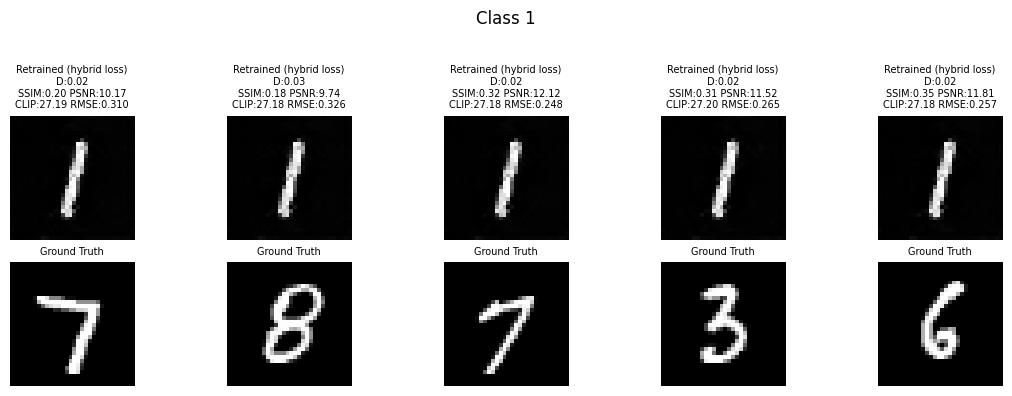

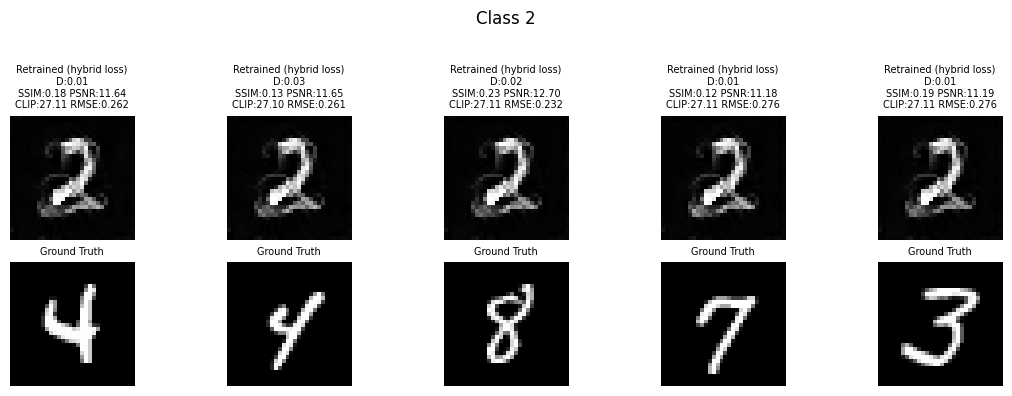

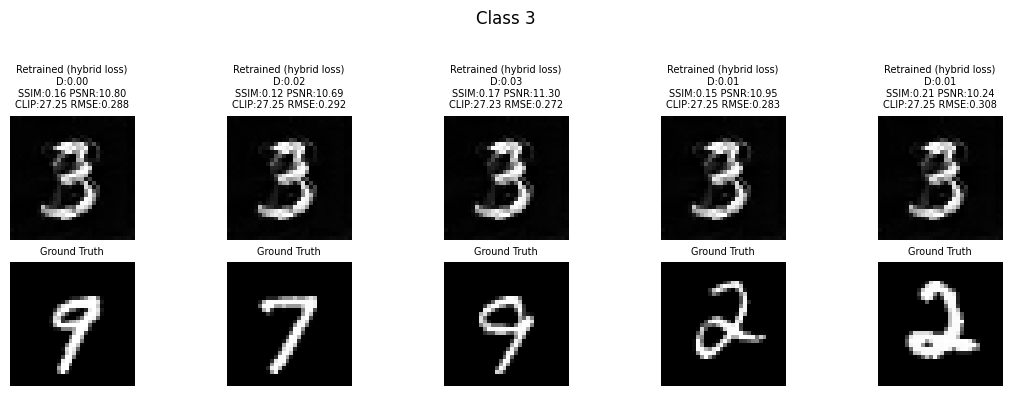

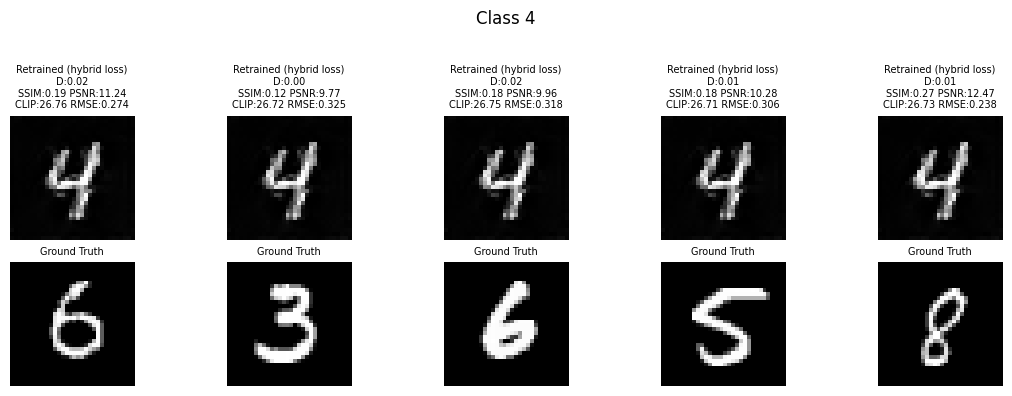

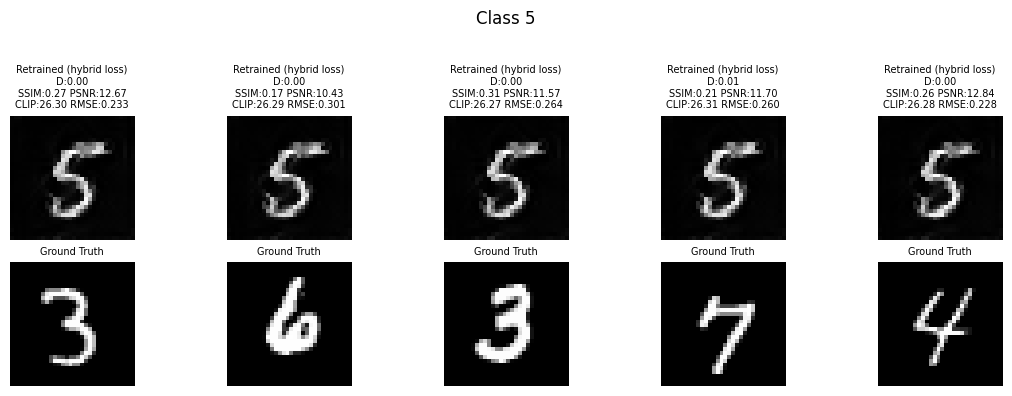

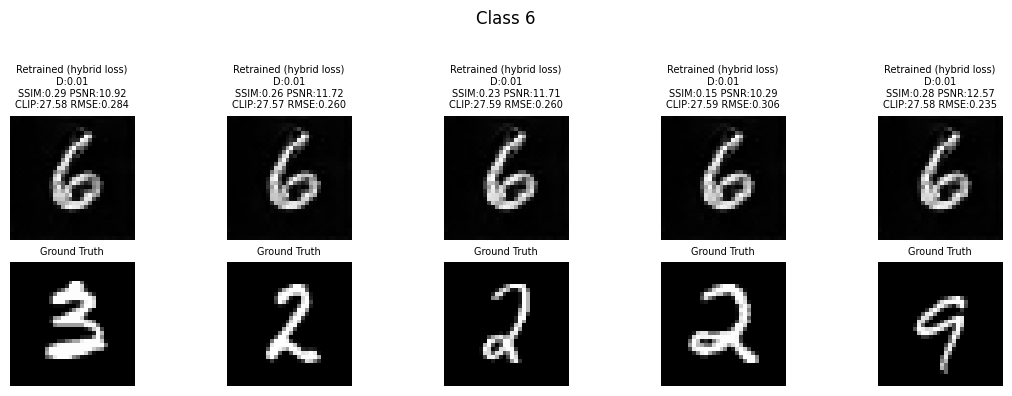

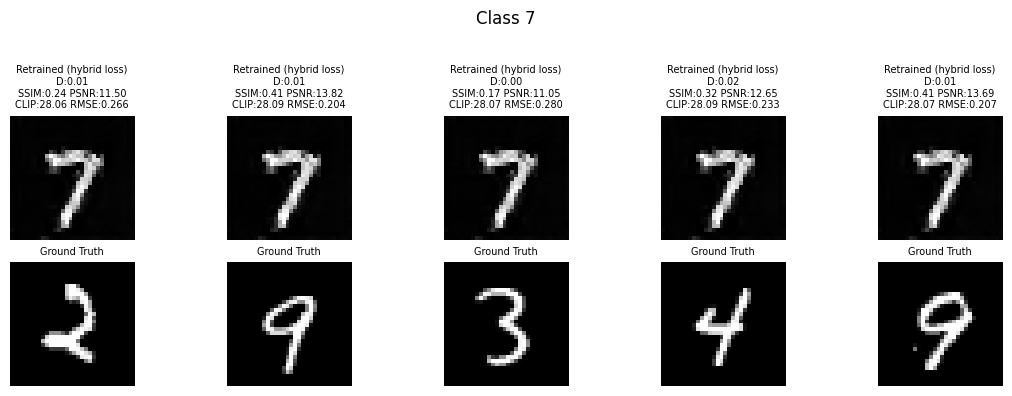

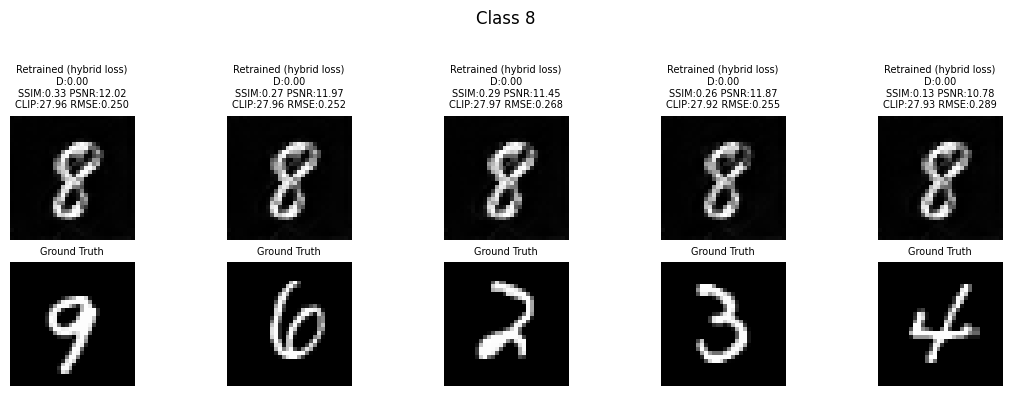

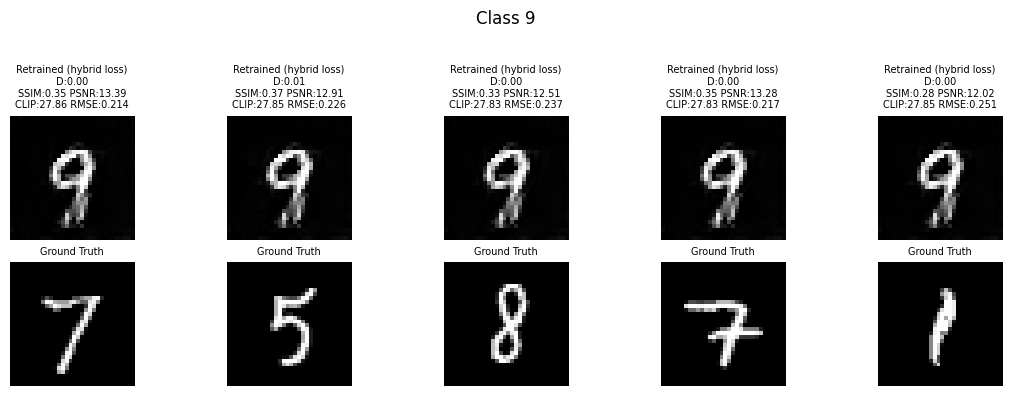


Per-Class Averages:
Class 0 - SSIM: 0.1980, PSNR: 10.14, CLIP: 27.8552, RMSE: 0.3117
Class 1 - SSIM: 0.2810, PSNR: 11.29, CLIP: 27.1877, RMSE: 0.2743
Class 2 - SSIM: 0.1390, PSNR: 11.56, CLIP: 27.1022, RMSE: 0.2659
Class 3 - SSIM: 0.1975, PSNR: 11.39, CLIP: 27.2423, RMSE: 0.2710
Class 4 - SSIM: 0.2298, PSNR: 11.80, CLIP: 26.7335, RMSE: 0.2597
Class 5 - SSIM: 0.2507, PSNR: 12.09, CLIP: 26.3058, RMSE: 0.2503
Class 6 - SSIM: 0.2272, PSNR: 11.36, CLIP: 27.5853, RMSE: 0.2715
Class 7 - SSIM: 0.2419, PSNR: 11.75, CLIP: 28.0684, RMSE: 0.2602
Class 8 - SSIM: 0.2580, PSNR: 11.72, CLIP: 27.9670, RMSE: 0.2605
Class 9 - SSIM: 0.2992, PSNR: 12.02, CLIP: 27.8433, RMSE: 0.2531

Calculating Inception Score and FID...
Inception Score: 1.78 ± 0.06
FID Score: 108.36
--------------------------------------- END --------------------------------------- 


In [100]:
import torch
import os

loss_types = ['mse', 'bce', 'perceptual', 'adversarial', 'hybrid']

for loss_type in loss_types:
    print(f"------------------------ EVALUATING MODELS OF {loss_type} ------------------------ ")
    # Path ke model
    generator_path = f"/kaggle/working/MNIST_cDCGAN_results/{loss_type}/generator_param.pkl"
    discriminator_path = f"/kaggle/working/MNIST_cDCGAN_results/{loss_type}/discriminator_param.pkl"
    
    # Load model
    G = generator(128)
    D = discriminator(128)
    
    # Load parameter
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    G.load_state_dict(torch.load(generator_path, map_location=device))
    D.load_state_dict(torch.load(discriminator_path, map_location=device))
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    G.eval().to(device)
    D.eval().to(device)
    
    print(f"Models of {loss_type} loss loaded successfully!")

    evaluate_all(G, D, final_false_val_pairs[:500], device, 5)
    print(f"--------------------------------------- END --------------------------------------- ")